# Neighbour features

Crear neighbour_features, dado las características de las variables meteorológicas y las variables iniciales

## Imports

In [26]:
import datetime
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
import xgboost

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score

from src.data.utils import (
    get_general_path, join_paths, save_dataframe, save_as_pickle
)

## Configuration

In [2]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 1000)

## Constants

In [21]:
RAW_DATA = 'data/raw/'
INTERIM_DATA = 'data/interim/'
PROCESSED_DATA = 'data/processed/'
MUNICIPAL_DATA = 'municipal_data.pkl'

ALL_FEATURES_FILE = 'all_features.pkl'
TARGET_FILE = 'target_datasets.pkl'

RANDOM_SEED = 69

MIN_TRAINING_DATE = '2017-01-01'
MAX_TRAINING_DATE = '2023-06-05'

MODEL_PATH = 'models/'
MODEL_FILE = 'SeGuia.pkl'

## Helper functions

## Read data


In [5]:
general_path = get_general_path()

features_path = join_paths(general_path, INTERIM_DATA, ALL_FEATURES_FILE)
features = pd.read_parquet(features_path)

target_file_path = join_paths(general_path, INTERIM_DATA, TARGET_FILE)
targets = pd.read_pickle(target_file_path)

municipal_information_path = join_paths(general_path, INTERIM_DATA, MUNICIPAL_DATA)
municipal_information = pd.read_pickle(municipal_information_path)

## Process data

In [6]:
features = features[features.standard_date >= pd.to_datetime(MIN_TRAINING_DATE)]
target = targets['6M']

In [7]:
f = features[['mun_id', 'standard_date', ]]
X = features.drop(['mun_id', 'standard_date'], axis=1)

Y = target[['num_drought_index_future']]
Y = (target.num_drought_index_future > 0).astype('int')

In [8]:
training_window = pd.to_datetime(MIN_TRAINING_DATE), pd.to_datetime(MAX_TRAINING_DATE)

f_index_train = f[f.standard_date.between(training_window[0], training_window[1])].index
general_index_train = sorted(list(set(X.index).intersection(set(f_index_train)).intersection(Y.index)))

x_train = X.loc[general_index_train]
y_train = Y.loc[general_index_train]

In [9]:
future_window = training_window[1]

f_index_oot = f[f.standard_date > future_window].index
general_index_oot = sorted(list(set(X.index).intersection(set(f_index_oot)).intersection(Y.index)))

x_oot = X.loc[general_index_oot]
y_oot = Y.loc[general_index_oot]


In [10]:
x_train, x_test, y_train, y_test = train_test_split(
    x_train, 
    y_train, 
    train_size=0.8,
    random_state=RANDOM_SEED
)

x_train, x_dev, y_train, y_dev = train_test_split(
    x_train, 
    y_train, 
    train_size=0.3,
    random_state=RANDOM_SEED
)

In [11]:
scale_pos_weight = (y_train == 0).sum()/(y_train == 1).sum()

In [12]:
scale_pos_weight

2.8533321933911853

In [13]:
params = {
    'n_estimators':10000,
    'max_depth':6,
    'gamma':0.4,
    'learning_rate': 0.001,
    'subsample':0.8,
    'colsample_bytree': 0.8,
    'colsample_bylevel':0.8,
    'colsample_bynode':0.8,
    'reg_alpha':10,
    'reg_lambda':10,
    'scale_pos_weight': scale_pos_weight, 
    'base_score':0.5, 
    'random_state': RANDOM_SEED,
    'eval_metric': ['aucpr', 'auc', 'logloss'],
    'early_stopping_rounds': 3,
}

In [14]:
model = xgboost.XGBClassifier(**params)
model.fit(
    x_train, 
    y_train, 
    eval_set=[(x_train, y_train), (x_dev, y_dev)], 
)

[0]	validation_0-aucpr:0.54550	validation_0-auc:0.78410	validation_0-logloss:0.69290	validation_1-aucpr:0.53429	validation_1-auc:0.77822	validation_1-logloss:0.69291
[1]	validation_0-aucpr:0.58762	validation_0-auc:0.80862	validation_0-logloss:0.69268	validation_1-aucpr:0.57019	validation_1-auc:0.79944	validation_1-logloss:0.69269
[2]	validation_0-aucpr:0.60649	validation_0-auc:0.81950	validation_0-logloss:0.69243	validation_1-aucpr:0.58858	validation_1-auc:0.81050	validation_1-logloss:0.69245
[3]	validation_0-aucpr:0.61438	validation_0-auc:0.82480	validation_0-logloss:0.69219	validation_1-aucpr:0.59737	validation_1-auc:0.81591	validation_1-logloss:0.69221
[4]	validation_0-aucpr:0.63183	validation_0-auc:0.83379	validation_0-logloss:0.69195	validation_1-aucpr:0.61271	validation_1-auc:0.82429	validation_1-logloss:0.69198
[5]	validation_0-aucpr:0.63362	validation_0-auc:0.83540	validation_0-logloss:0.69172	validation_1-aucpr:0.61492	validation_1-auc:0.82606	validation_1-logloss:0.69175
[6]	

[50]	validation_0-aucpr:0.64399	validation_0-auc:0.83991	validation_0-logloss:0.68124	validation_1-aucpr:0.62638	validation_1-auc:0.83124	validation_1-logloss:0.68149
[51]	validation_0-aucpr:0.64339	validation_0-auc:0.83959	validation_0-logloss:0.68101	validation_1-aucpr:0.62584	validation_1-auc:0.83094	validation_1-logloss:0.68126
[52]	validation_0-aucpr:0.64300	validation_0-auc:0.83941	validation_0-logloss:0.68078	validation_1-aucpr:0.62550	validation_1-auc:0.83077	validation_1-logloss:0.68104
[53]	validation_0-aucpr:0.64274	validation_0-auc:0.83937	validation_0-logloss:0.68056	validation_1-aucpr:0.62528	validation_1-auc:0.83073	validation_1-logloss:0.68082
[54]	validation_0-aucpr:0.64221	validation_0-auc:0.83907	validation_0-logloss:0.68033	validation_1-aucpr:0.62480	validation_1-auc:0.83045	validation_1-logloss:0.68060
[55]	validation_0-aucpr:0.64243	validation_0-auc:0.83924	validation_0-logloss:0.68012	validation_1-aucpr:0.62503	validation_1-auc:0.83063	validation_1-logloss:0.6803

[100]	validation_0-aucpr:0.64366	validation_0-auc:0.84049	validation_0-logloss:0.67037	validation_1-aucpr:0.62658	validation_1-auc:0.83176	validation_1-logloss:0.67087
[101]	validation_0-aucpr:0.64347	validation_0-auc:0.84045	validation_0-logloss:0.67017	validation_1-aucpr:0.62642	validation_1-auc:0.83173	validation_1-logloss:0.67067
[102]	validation_0-aucpr:0.64371	validation_0-auc:0.84060	validation_0-logloss:0.66997	validation_1-aucpr:0.62660	validation_1-auc:0.83184	validation_1-logloss:0.67048
[103]	validation_0-aucpr:0.64361	validation_0-auc:0.84070	validation_0-logloss:0.66976	validation_1-aucpr:0.62655	validation_1-auc:0.83196	validation_1-logloss:0.67027
[104]	validation_0-aucpr:0.64358	validation_0-auc:0.84074	validation_0-logloss:0.66955	validation_1-aucpr:0.62655	validation_1-auc:0.83199	validation_1-logloss:0.67007
[105]	validation_0-aucpr:0.64392	validation_0-auc:0.84089	validation_0-logloss:0.66934	validation_1-aucpr:0.62681	validation_1-auc:0.83208	validation_1-logloss:

[149]	validation_0-aucpr:0.64616	validation_0-auc:0.84183	validation_0-logloss:0.66043	validation_1-aucpr:0.62867	validation_1-auc:0.83297	validation_1-logloss:0.66117
[150]	validation_0-aucpr:0.64606	validation_0-auc:0.84179	validation_0-logloss:0.66023	validation_1-aucpr:0.62859	validation_1-auc:0.83294	validation_1-logloss:0.66098
[151]	validation_0-aucpr:0.64613	validation_0-auc:0.84182	validation_0-logloss:0.66005	validation_1-aucpr:0.62867	validation_1-auc:0.83298	validation_1-logloss:0.66079
[152]	validation_0-aucpr:0.64647	validation_0-auc:0.84202	validation_0-logloss:0.65986	validation_1-aucpr:0.62896	validation_1-auc:0.83318	validation_1-logloss:0.66061
[153]	validation_0-aucpr:0.64648	validation_0-auc:0.84196	validation_0-logloss:0.65967	validation_1-aucpr:0.62895	validation_1-auc:0.83311	validation_1-logloss:0.66042
[154]	validation_0-aucpr:0.64657	validation_0-auc:0.84198	validation_0-logloss:0.65947	validation_1-aucpr:0.62902	validation_1-auc:0.83312	validation_1-logloss:

[198]	validation_0-aucpr:0.64853	validation_0-auc:0.84318	validation_0-logloss:0.65115	validation_1-aucpr:0.63076	validation_1-auc:0.83424	validation_1-logloss:0.65211
[199]	validation_0-aucpr:0.64865	validation_0-auc:0.84327	validation_0-logloss:0.65096	validation_1-aucpr:0.63083	validation_1-auc:0.83430	validation_1-logloss:0.65193
[200]	validation_0-aucpr:0.64879	validation_0-auc:0.84339	validation_0-logloss:0.65077	validation_1-aucpr:0.63101	validation_1-auc:0.83443	validation_1-logloss:0.65175
[201]	validation_0-aucpr:0.64886	validation_0-auc:0.84350	validation_0-logloss:0.65058	validation_1-aucpr:0.63106	validation_1-auc:0.83452	validation_1-logloss:0.65156
[202]	validation_0-aucpr:0.64897	validation_0-auc:0.84355	validation_0-logloss:0.65042	validation_1-aucpr:0.63117	validation_1-auc:0.83457	validation_1-logloss:0.65140
[203]	validation_0-aucpr:0.64888	validation_0-auc:0.84348	validation_0-logloss:0.65025	validation_1-aucpr:0.63109	validation_1-auc:0.83452	validation_1-logloss:

[247]	validation_0-aucpr:0.65163	validation_0-auc:0.84477	validation_0-logloss:0.64246	validation_1-aucpr:0.63359	validation_1-auc:0.83566	validation_1-logloss:0.64366
[248]	validation_0-aucpr:0.65165	validation_0-auc:0.84478	validation_0-logloss:0.64229	validation_1-aucpr:0.63361	validation_1-auc:0.83569	validation_1-logloss:0.64350
[249]	validation_0-aucpr:0.65165	validation_0-auc:0.84475	validation_0-logloss:0.64212	validation_1-aucpr:0.63362	validation_1-auc:0.83567	validation_1-logloss:0.64333
[250]	validation_0-aucpr:0.65174	validation_0-auc:0.84480	validation_0-logloss:0.64195	validation_1-aucpr:0.63372	validation_1-auc:0.83570	validation_1-logloss:0.64317
[251]	validation_0-aucpr:0.65176	validation_0-auc:0.84478	validation_0-logloss:0.64179	validation_1-aucpr:0.63374	validation_1-auc:0.83569	validation_1-logloss:0.64301
[252]	validation_0-aucpr:0.65192	validation_0-auc:0.84482	validation_0-logloss:0.64163	validation_1-aucpr:0.63390	validation_1-auc:0.83573	validation_1-logloss:

[296]	validation_0-aucpr:0.65531	validation_0-auc:0.84639	validation_0-logloss:0.63434	validation_1-aucpr:0.63707	validation_1-auc:0.83715	validation_1-logloss:0.63577
[297]	validation_0-aucpr:0.65541	validation_0-auc:0.84641	validation_0-logloss:0.63417	validation_1-aucpr:0.63714	validation_1-auc:0.83716	validation_1-logloss:0.63561
[298]	validation_0-aucpr:0.65535	validation_0-auc:0.84641	validation_0-logloss:0.63401	validation_1-aucpr:0.63707	validation_1-auc:0.83717	validation_1-logloss:0.63545
[299]	validation_0-aucpr:0.65545	validation_0-auc:0.84646	validation_0-logloss:0.63385	validation_1-aucpr:0.63719	validation_1-auc:0.83722	validation_1-logloss:0.63529
[300]	validation_0-aucpr:0.65563	validation_0-auc:0.84651	validation_0-logloss:0.63370	validation_1-aucpr:0.63737	validation_1-auc:0.83727	validation_1-logloss:0.63514
[301]	validation_0-aucpr:0.65566	validation_0-auc:0.84654	validation_0-logloss:0.63353	validation_1-aucpr:0.63738	validation_1-auc:0.83729	validation_1-logloss:

[345]	validation_0-aucpr:0.65848	validation_0-auc:0.84805	validation_0-logloss:0.62661	validation_1-aucpr:0.63955	validation_1-auc:0.83858	validation_1-logloss:0.62828
[346]	validation_0-aucpr:0.65864	validation_0-auc:0.84815	validation_0-logloss:0.62646	validation_1-aucpr:0.63970	validation_1-auc:0.83866	validation_1-logloss:0.62814
[347]	validation_0-aucpr:0.65882	validation_0-auc:0.84824	validation_0-logloss:0.62631	validation_1-aucpr:0.63982	validation_1-auc:0.83874	validation_1-logloss:0.62799
[348]	validation_0-aucpr:0.65885	validation_0-auc:0.84827	validation_0-logloss:0.62616	validation_1-aucpr:0.63985	validation_1-auc:0.83877	validation_1-logloss:0.62785
[349]	validation_0-aucpr:0.65884	validation_0-auc:0.84828	validation_0-logloss:0.62600	validation_1-aucpr:0.63984	validation_1-auc:0.83879	validation_1-logloss:0.62770
[350]	validation_0-aucpr:0.65880	validation_0-auc:0.84828	validation_0-logloss:0.62585	validation_1-aucpr:0.63980	validation_1-auc:0.83877	validation_1-logloss:

[394]	validation_0-aucpr:0.66222	validation_0-auc:0.84999	validation_0-logloss:0.61933	validation_1-aucpr:0.64279	validation_1-auc:0.84030	validation_1-logloss:0.62124
[395]	validation_0-aucpr:0.66241	validation_0-auc:0.85009	validation_0-logloss:0.61918	validation_1-aucpr:0.64295	validation_1-auc:0.84039	validation_1-logloss:0.62110
[396]	validation_0-aucpr:0.66251	validation_0-auc:0.85014	validation_0-logloss:0.61905	validation_1-aucpr:0.64304	validation_1-auc:0.84043	validation_1-logloss:0.62097
[397]	validation_0-aucpr:0.66256	validation_0-auc:0.85016	validation_0-logloss:0.61890	validation_1-aucpr:0.64309	validation_1-auc:0.84046	validation_1-logloss:0.62082
[398]	validation_0-aucpr:0.66269	validation_0-auc:0.85021	validation_0-logloss:0.61876	validation_1-aucpr:0.64322	validation_1-auc:0.84050	validation_1-logloss:0.62069
[399]	validation_0-aucpr:0.66272	validation_0-auc:0.85022	validation_0-logloss:0.61861	validation_1-aucpr:0.64326	validation_1-auc:0.84052	validation_1-logloss:

[443]	validation_0-aucpr:0.66553	validation_0-auc:0.85174	validation_0-logloss:0.61241	validation_1-aucpr:0.64574	validation_1-auc:0.84190	validation_1-logloss:0.61455
[444]	validation_0-aucpr:0.66561	validation_0-auc:0.85180	validation_0-logloss:0.61228	validation_1-aucpr:0.64582	validation_1-auc:0.84196	validation_1-logloss:0.61442
[445]	validation_0-aucpr:0.66569	validation_0-auc:0.85184	validation_0-logloss:0.61214	validation_1-aucpr:0.64590	validation_1-auc:0.84199	validation_1-logloss:0.61429
[446]	validation_0-aucpr:0.66583	validation_0-auc:0.85191	validation_0-logloss:0.61200	validation_1-aucpr:0.64605	validation_1-auc:0.84206	validation_1-logloss:0.61416
[447]	validation_0-aucpr:0.66583	validation_0-auc:0.85193	validation_0-logloss:0.61187	validation_1-aucpr:0.64604	validation_1-auc:0.84207	validation_1-logloss:0.61402
[448]	validation_0-aucpr:0.66578	validation_0-auc:0.85191	validation_0-logloss:0.61173	validation_1-aucpr:0.64599	validation_1-auc:0.84206	validation_1-logloss:

[492]	validation_0-aucpr:0.66933	validation_0-auc:0.85368	validation_0-logloss:0.60586	validation_1-aucpr:0.64907	validation_1-auc:0.84363	validation_1-logloss:0.60823
[493]	validation_0-aucpr:0.66933	validation_0-auc:0.85369	validation_0-logloss:0.60573	validation_1-aucpr:0.64907	validation_1-auc:0.84363	validation_1-logloss:0.60810
[494]	validation_0-aucpr:0.66943	validation_0-auc:0.85374	validation_0-logloss:0.60559	validation_1-aucpr:0.64917	validation_1-auc:0.84369	validation_1-logloss:0.60798
[495]	validation_0-aucpr:0.66946	validation_0-auc:0.85377	validation_0-logloss:0.60546	validation_1-aucpr:0.64919	validation_1-auc:0.84371	validation_1-logloss:0.60785
[496]	validation_0-aucpr:0.66953	validation_0-auc:0.85380	validation_0-logloss:0.60533	validation_1-aucpr:0.64926	validation_1-auc:0.84374	validation_1-logloss:0.60772
[497]	validation_0-aucpr:0.66965	validation_0-auc:0.85387	validation_0-logloss:0.60519	validation_1-aucpr:0.64937	validation_1-auc:0.84381	validation_1-logloss:

[541]	validation_0-aucpr:0.67259	validation_0-auc:0.85524	validation_0-logloss:0.59964	validation_1-aucpr:0.65192	validation_1-auc:0.84502	validation_1-logloss:0.60224
[542]	validation_0-aucpr:0.67270	validation_0-auc:0.85530	validation_0-logloss:0.59951	validation_1-aucpr:0.65203	validation_1-auc:0.84508	validation_1-logloss:0.60212
[543]	validation_0-aucpr:0.67269	validation_0-auc:0.85531	validation_0-logloss:0.59938	validation_1-aucpr:0.65201	validation_1-auc:0.84509	validation_1-logloss:0.60199
[544]	validation_0-aucpr:0.67272	validation_0-auc:0.85533	validation_0-logloss:0.59925	validation_1-aucpr:0.65203	validation_1-auc:0.84511	validation_1-logloss:0.60187
[545]	validation_0-aucpr:0.67281	validation_0-auc:0.85538	validation_0-logloss:0.59912	validation_1-aucpr:0.65211	validation_1-auc:0.84516	validation_1-logloss:0.60173
[546]	validation_0-aucpr:0.67280	validation_0-auc:0.85540	validation_0-logloss:0.59899	validation_1-aucpr:0.65210	validation_1-auc:0.84518	validation_1-logloss:

[590]	validation_0-aucpr:0.67602	validation_0-auc:0.85698	validation_0-logloss:0.59361	validation_1-aucpr:0.65503	validation_1-auc:0.84663	validation_1-logloss:0.59643
[591]	validation_0-aucpr:0.67604	validation_0-auc:0.85701	validation_0-logloss:0.59348	validation_1-aucpr:0.65506	validation_1-auc:0.84665	validation_1-logloss:0.59631
[592]	validation_0-aucpr:0.67614	validation_0-auc:0.85707	validation_0-logloss:0.59336	validation_1-aucpr:0.65514	validation_1-auc:0.84670	validation_1-logloss:0.59619
[593]	validation_0-aucpr:0.67626	validation_0-auc:0.85714	validation_0-logloss:0.59324	validation_1-aucpr:0.65524	validation_1-auc:0.84676	validation_1-logloss:0.59608
[594]	validation_0-aucpr:0.67638	validation_0-auc:0.85720	validation_0-logloss:0.59311	validation_1-aucpr:0.65533	validation_1-auc:0.84681	validation_1-logloss:0.59596
[595]	validation_0-aucpr:0.67641	validation_0-auc:0.85722	validation_0-logloss:0.59300	validation_1-aucpr:0.65535	validation_1-auc:0.84683	validation_1-logloss:

[639]	validation_0-aucpr:0.68011	validation_0-auc:0.85895	validation_0-logloss:0.58777	validation_1-aucpr:0.65871	validation_1-auc:0.84842	validation_1-logloss:0.59084
[640]	validation_0-aucpr:0.68024	validation_0-auc:0.85901	validation_0-logloss:0.58765	validation_1-aucpr:0.65884	validation_1-auc:0.84848	validation_1-logloss:0.59072
[641]	validation_0-aucpr:0.68033	validation_0-auc:0.85906	validation_0-logloss:0.58754	validation_1-aucpr:0.65892	validation_1-auc:0.84853	validation_1-logloss:0.59061
[642]	validation_0-aucpr:0.68035	validation_0-auc:0.85908	validation_0-logloss:0.58742	validation_1-aucpr:0.65895	validation_1-auc:0.84855	validation_1-logloss:0.59050
[643]	validation_0-aucpr:0.68030	validation_0-auc:0.85907	validation_0-logloss:0.58731	validation_1-aucpr:0.65889	validation_1-auc:0.84854	validation_1-logloss:0.59039
[644]	validation_0-aucpr:0.68035	validation_0-auc:0.85909	validation_0-logloss:0.58719	validation_1-aucpr:0.65894	validation_1-auc:0.84856	validation_1-logloss:

[688]	validation_0-aucpr:0.68289	validation_0-auc:0.86050	validation_0-logloss:0.58232	validation_1-aucpr:0.66124	validation_1-auc:0.84985	validation_1-logloss:0.58559
[689]	validation_0-aucpr:0.68296	validation_0-auc:0.86053	validation_0-logloss:0.58221	validation_1-aucpr:0.66129	validation_1-auc:0.84988	validation_1-logloss:0.58549
[690]	validation_0-aucpr:0.68304	validation_0-auc:0.86057	validation_0-logloss:0.58209	validation_1-aucpr:0.66136	validation_1-auc:0.84992	validation_1-logloss:0.58538
[691]	validation_0-aucpr:0.68308	validation_0-auc:0.86060	validation_0-logloss:0.58198	validation_1-aucpr:0.66139	validation_1-auc:0.84994	validation_1-logloss:0.58527
[692]	validation_0-aucpr:0.68315	validation_0-auc:0.86063	validation_0-logloss:0.58188	validation_1-aucpr:0.66144	validation_1-auc:0.84997	validation_1-logloss:0.58518
[693]	validation_0-aucpr:0.68326	validation_0-auc:0.86068	validation_0-logloss:0.58177	validation_1-aucpr:0.66154	validation_1-auc:0.85001	validation_1-logloss:

[737]	validation_0-aucpr:0.68609	validation_0-auc:0.86215	validation_0-logloss:0.57703	validation_1-aucpr:0.66400	validation_1-auc:0.85132	validation_1-logloss:0.58054
[738]	validation_0-aucpr:0.68620	validation_0-auc:0.86221	validation_0-logloss:0.57692	validation_1-aucpr:0.66411	validation_1-auc:0.85138	validation_1-logloss:0.58043
[739]	validation_0-aucpr:0.68630	validation_0-auc:0.86226	validation_0-logloss:0.57682	validation_1-aucpr:0.66419	validation_1-auc:0.85142	validation_1-logloss:0.58034
[740]	validation_0-aucpr:0.68627	validation_0-auc:0.86227	validation_0-logloss:0.57671	validation_1-aucpr:0.66418	validation_1-auc:0.85143	validation_1-logloss:0.58023
[741]	validation_0-aucpr:0.68634	validation_0-auc:0.86229	validation_0-logloss:0.57660	validation_1-aucpr:0.66423	validation_1-auc:0.85145	validation_1-logloss:0.58013
[742]	validation_0-aucpr:0.68646	validation_0-auc:0.86234	validation_0-logloss:0.57650	validation_1-aucpr:0.66433	validation_1-auc:0.85149	validation_1-logloss:

[786]	validation_0-aucpr:0.68899	validation_0-auc:0.86368	validation_0-logloss:0.57203	validation_1-aucpr:0.66653	validation_1-auc:0.85269	validation_1-logloss:0.57576
[787]	validation_0-aucpr:0.68905	validation_0-auc:0.86371	validation_0-logloss:0.57193	validation_1-aucpr:0.66658	validation_1-auc:0.85272	validation_1-logloss:0.57566
[788]	validation_0-aucpr:0.68904	validation_0-auc:0.86373	validation_0-logloss:0.57182	validation_1-aucpr:0.66657	validation_1-auc:0.85274	validation_1-logloss:0.57556
[789]	validation_0-aucpr:0.68903	validation_0-auc:0.86373	validation_0-logloss:0.57172	validation_1-aucpr:0.66656	validation_1-auc:0.85274	validation_1-logloss:0.57546
[790]	validation_0-aucpr:0.68913	validation_0-auc:0.86377	validation_0-logloss:0.57162	validation_1-aucpr:0.66665	validation_1-auc:0.85277	validation_1-logloss:0.57537
[791]	validation_0-aucpr:0.68923	validation_0-auc:0.86382	validation_0-logloss:0.57151	validation_1-aucpr:0.66672	validation_1-auc:0.85281	validation_1-logloss:

[835]	validation_0-aucpr:0.69200	validation_0-auc:0.86518	validation_0-logloss:0.56723	validation_1-aucpr:0.66918	validation_1-auc:0.85401	validation_1-logloss:0.57118
[836]	validation_0-aucpr:0.69206	validation_0-auc:0.86521	validation_0-logloss:0.56714	validation_1-aucpr:0.66924	validation_1-auc:0.85403	validation_1-logloss:0.57110
[837]	validation_0-aucpr:0.69212	validation_0-auc:0.86524	validation_0-logloss:0.56704	validation_1-aucpr:0.66929	validation_1-auc:0.85406	validation_1-logloss:0.57100
[838]	validation_0-aucpr:0.69216	validation_0-auc:0.86526	validation_0-logloss:0.56695	validation_1-aucpr:0.66933	validation_1-auc:0.85407	validation_1-logloss:0.57092
[839]	validation_0-aucpr:0.69225	validation_0-auc:0.86530	validation_0-logloss:0.56685	validation_1-aucpr:0.66941	validation_1-auc:0.85411	validation_1-logloss:0.57082
[840]	validation_0-aucpr:0.69234	validation_0-auc:0.86533	validation_0-logloss:0.56675	validation_1-aucpr:0.66949	validation_1-auc:0.85414	validation_1-logloss:

[884]	validation_0-aucpr:0.69495	validation_0-auc:0.86664	validation_0-logloss:0.56260	validation_1-aucpr:0.67181	validation_1-auc:0.85530	validation_1-logloss:0.56677
[885]	validation_0-aucpr:0.69508	validation_0-auc:0.86669	validation_0-logloss:0.56251	validation_1-aucpr:0.67193	validation_1-auc:0.85534	validation_1-logloss:0.56669
[886]	validation_0-aucpr:0.69512	validation_0-auc:0.86671	validation_0-logloss:0.56241	validation_1-aucpr:0.67195	validation_1-auc:0.85537	validation_1-logloss:0.56660
[887]	validation_0-aucpr:0.69514	validation_0-auc:0.86673	validation_0-logloss:0.56231	validation_1-aucpr:0.67197	validation_1-auc:0.85538	validation_1-logloss:0.56651
[888]	validation_0-aucpr:0.69522	validation_0-auc:0.86677	validation_0-logloss:0.56222	validation_1-aucpr:0.67205	validation_1-auc:0.85541	validation_1-logloss:0.56641
[889]	validation_0-aucpr:0.69531	validation_0-auc:0.86681	validation_0-logloss:0.56212	validation_1-aucpr:0.67213	validation_1-auc:0.85545	validation_1-logloss:

[933]	validation_0-aucpr:0.69799	validation_0-auc:0.86817	validation_0-logloss:0.55813	validation_1-aucpr:0.67454	validation_1-auc:0.85666	validation_1-logloss:0.56253
[934]	validation_0-aucpr:0.69803	validation_0-auc:0.86819	validation_0-logloss:0.55805	validation_1-aucpr:0.67457	validation_1-auc:0.85669	validation_1-logloss:0.56245
[935]	validation_0-aucpr:0.69811	validation_0-auc:0.86822	validation_0-logloss:0.55795	validation_1-aucpr:0.67464	validation_1-auc:0.85672	validation_1-logloss:0.56235
[936]	validation_0-aucpr:0.69815	validation_0-auc:0.86824	validation_0-logloss:0.55786	validation_1-aucpr:0.67467	validation_1-auc:0.85674	validation_1-logloss:0.56226
[937]	validation_0-aucpr:0.69821	validation_0-auc:0.86827	validation_0-logloss:0.55776	validation_1-aucpr:0.67473	validation_1-auc:0.85676	validation_1-logloss:0.56217
[938]	validation_0-aucpr:0.69821	validation_0-auc:0.86828	validation_0-logloss:0.55768	validation_1-aucpr:0.67473	validation_1-auc:0.85677	validation_1-logloss:

[982]	validation_0-aucpr:0.70034	validation_0-auc:0.86945	validation_0-logloss:0.55384	validation_1-aucpr:0.67661	validation_1-auc:0.85782	validation_1-logloss:0.55845
[983]	validation_0-aucpr:0.70044	validation_0-auc:0.86949	validation_0-logloss:0.55374	validation_1-aucpr:0.67672	validation_1-auc:0.85787	validation_1-logloss:0.55835
[984]	validation_0-aucpr:0.70049	validation_0-auc:0.86952	validation_0-logloss:0.55367	validation_1-aucpr:0.67677	validation_1-auc:0.85789	validation_1-logloss:0.55828
[985]	validation_0-aucpr:0.70056	validation_0-auc:0.86956	validation_0-logloss:0.55358	validation_1-aucpr:0.67683	validation_1-auc:0.85792	validation_1-logloss:0.55820
[986]	validation_0-aucpr:0.70063	validation_0-auc:0.86959	validation_0-logloss:0.55349	validation_1-aucpr:0.67689	validation_1-auc:0.85795	validation_1-logloss:0.55811
[987]	validation_0-aucpr:0.70068	validation_0-auc:0.86961	validation_0-logloss:0.55340	validation_1-aucpr:0.67693	validation_1-auc:0.85797	validation_1-logloss:

[1031]	validation_0-aucpr:0.70270	validation_0-auc:0.87079	validation_0-logloss:0.54968	validation_1-aucpr:0.67873	validation_1-auc:0.85903	validation_1-logloss:0.55449
[1032]	validation_0-aucpr:0.70268	validation_0-auc:0.87080	validation_0-logloss:0.54959	validation_1-aucpr:0.67872	validation_1-auc:0.85905	validation_1-logloss:0.55441
[1033]	validation_0-aucpr:0.70271	validation_0-auc:0.87082	validation_0-logloss:0.54951	validation_1-aucpr:0.67874	validation_1-auc:0.85906	validation_1-logloss:0.55433
[1034]	validation_0-aucpr:0.70270	validation_0-auc:0.87083	validation_0-logloss:0.54942	validation_1-aucpr:0.67874	validation_1-auc:0.85907	validation_1-logloss:0.55425
[1035]	validation_0-aucpr:0.70278	validation_0-auc:0.87086	validation_0-logloss:0.54934	validation_1-aucpr:0.67880	validation_1-auc:0.85909	validation_1-logloss:0.55417
[1036]	validation_0-aucpr:0.70286	validation_0-auc:0.87090	validation_0-logloss:0.54925	validation_1-aucpr:0.67886	validation_1-auc:0.85913	validation_1-lo

[1080]	validation_0-aucpr:0.70528	validation_0-auc:0.87218	validation_0-logloss:0.54559	validation_1-aucpr:0.68100	validation_1-auc:0.86027	validation_1-logloss:0.55062
[1081]	validation_0-aucpr:0.70533	validation_0-auc:0.87220	validation_0-logloss:0.54551	validation_1-aucpr:0.68104	validation_1-auc:0.86029	validation_1-logloss:0.55054
[1082]	validation_0-aucpr:0.70543	validation_0-auc:0.87225	validation_0-logloss:0.54542	validation_1-aucpr:0.68113	validation_1-auc:0.86034	validation_1-logloss:0.55045
[1083]	validation_0-aucpr:0.70551	validation_0-auc:0.87229	validation_0-logloss:0.54533	validation_1-aucpr:0.68121	validation_1-auc:0.86037	validation_1-logloss:0.55037
[1084]	validation_0-aucpr:0.70560	validation_0-auc:0.87232	validation_0-logloss:0.54525	validation_1-aucpr:0.68130	validation_1-auc:0.86040	validation_1-logloss:0.55029
[1085]	validation_0-aucpr:0.70564	validation_0-auc:0.87234	validation_0-logloss:0.54518	validation_1-aucpr:0.68133	validation_1-auc:0.86042	validation_1-lo

[1129]	validation_0-aucpr:0.70766	validation_0-auc:0.87344	validation_0-logloss:0.54178	validation_1-aucpr:0.68308	validation_1-auc:0.86138	validation_1-logloss:0.54703
[1130]	validation_0-aucpr:0.70770	validation_0-auc:0.87347	validation_0-logloss:0.54172	validation_1-aucpr:0.68310	validation_1-auc:0.86140	validation_1-logloss:0.54697
[1131]	validation_0-aucpr:0.70773	validation_0-auc:0.87349	validation_0-logloss:0.54164	validation_1-aucpr:0.68313	validation_1-auc:0.86141	validation_1-logloss:0.54689
[1132]	validation_0-aucpr:0.70778	validation_0-auc:0.87351	validation_0-logloss:0.54156	validation_1-aucpr:0.68317	validation_1-auc:0.86144	validation_1-logloss:0.54682
[1133]	validation_0-aucpr:0.70785	validation_0-auc:0.87354	validation_0-logloss:0.54148	validation_1-aucpr:0.68323	validation_1-auc:0.86146	validation_1-logloss:0.54674
[1134]	validation_0-aucpr:0.70791	validation_0-auc:0.87358	validation_0-logloss:0.54140	validation_1-aucpr:0.68328	validation_1-auc:0.86149	validation_1-lo

[1178]	validation_0-aucpr:0.70973	validation_0-auc:0.87464	validation_0-logloss:0.53809	validation_1-aucpr:0.68485	validation_1-auc:0.86244	validation_1-logloss:0.54354
[1179]	validation_0-aucpr:0.70977	validation_0-auc:0.87466	validation_0-logloss:0.53801	validation_1-aucpr:0.68488	validation_1-auc:0.86246	validation_1-logloss:0.54347
[1180]	validation_0-aucpr:0.70976	validation_0-auc:0.87467	validation_0-logloss:0.53794	validation_1-aucpr:0.68487	validation_1-auc:0.86247	validation_1-logloss:0.54340
[1181]	validation_0-aucpr:0.70982	validation_0-auc:0.87470	validation_0-logloss:0.53786	validation_1-aucpr:0.68492	validation_1-auc:0.86249	validation_1-logloss:0.54332
[1182]	validation_0-aucpr:0.70986	validation_0-auc:0.87472	validation_0-logloss:0.53778	validation_1-aucpr:0.68496	validation_1-auc:0.86252	validation_1-logloss:0.54325
[1183]	validation_0-aucpr:0.70994	validation_0-auc:0.87476	validation_0-logloss:0.53769	validation_1-aucpr:0.68503	validation_1-auc:0.86255	validation_1-lo

[1227]	validation_0-aucpr:0.71234	validation_0-auc:0.87596	validation_0-logloss:0.53441	validation_1-aucpr:0.68716	validation_1-auc:0.86361	validation_1-logloss:0.54008
[1228]	validation_0-aucpr:0.71242	validation_0-auc:0.87600	validation_0-logloss:0.53434	validation_1-aucpr:0.68723	validation_1-auc:0.86364	validation_1-logloss:0.54001
[1229]	validation_0-aucpr:0.71247	validation_0-auc:0.87602	validation_0-logloss:0.53426	validation_1-aucpr:0.68727	validation_1-auc:0.86366	validation_1-logloss:0.53994
[1230]	validation_0-aucpr:0.71252	validation_0-auc:0.87604	validation_0-logloss:0.53419	validation_1-aucpr:0.68733	validation_1-auc:0.86369	validation_1-logloss:0.53987
[1231]	validation_0-aucpr:0.71257	validation_0-auc:0.87607	validation_0-logloss:0.53412	validation_1-aucpr:0.68737	validation_1-auc:0.86371	validation_1-logloss:0.53980
[1232]	validation_0-aucpr:0.71261	validation_0-auc:0.87609	validation_0-logloss:0.53406	validation_1-aucpr:0.68740	validation_1-auc:0.86373	validation_1-lo

[1276]	validation_0-aucpr:0.71469	validation_0-auc:0.87718	validation_0-logloss:0.53093	validation_1-aucpr:0.68921	validation_1-auc:0.86470	validation_1-logloss:0.53679
[1277]	validation_0-aucpr:0.71474	validation_0-auc:0.87721	validation_0-logloss:0.53085	validation_1-aucpr:0.68925	validation_1-auc:0.86472	validation_1-logloss:0.53672
[1278]	validation_0-aucpr:0.71482	validation_0-auc:0.87725	validation_0-logloss:0.53078	validation_1-aucpr:0.68931	validation_1-auc:0.86476	validation_1-logloss:0.53665
[1279]	validation_0-aucpr:0.71489	validation_0-auc:0.87727	validation_0-logloss:0.53071	validation_1-aucpr:0.68937	validation_1-auc:0.86478	validation_1-logloss:0.53660
[1280]	validation_0-aucpr:0.71496	validation_0-auc:0.87731	validation_0-logloss:0.53063	validation_1-aucpr:0.68943	validation_1-auc:0.86480	validation_1-logloss:0.53652
[1281]	validation_0-aucpr:0.71504	validation_0-auc:0.87734	validation_0-logloss:0.53057	validation_1-aucpr:0.68950	validation_1-auc:0.86483	validation_1-lo

[1325]	validation_0-aucpr:0.71738	validation_0-auc:0.87854	validation_0-logloss:0.52745	validation_1-aucpr:0.69154	validation_1-auc:0.86591	validation_1-logloss:0.53352
[1326]	validation_0-aucpr:0.71747	validation_0-auc:0.87857	validation_0-logloss:0.52737	validation_1-aucpr:0.69162	validation_1-auc:0.86594	validation_1-logloss:0.53345
[1327]	validation_0-aucpr:0.71749	validation_0-auc:0.87859	validation_0-logloss:0.52730	validation_1-aucpr:0.69164	validation_1-auc:0.86595	validation_1-logloss:0.53338
[1328]	validation_0-aucpr:0.71758	validation_0-auc:0.87863	validation_0-logloss:0.52723	validation_1-aucpr:0.69172	validation_1-auc:0.86599	validation_1-logloss:0.53332
[1329]	validation_0-aucpr:0.71763	validation_0-auc:0.87866	validation_0-logloss:0.52716	validation_1-aucpr:0.69176	validation_1-auc:0.86601	validation_1-logloss:0.53325
[1330]	validation_0-aucpr:0.71768	validation_0-auc:0.87869	validation_0-logloss:0.52709	validation_1-aucpr:0.69181	validation_1-auc:0.86604	validation_1-lo

[1374]	validation_0-aucpr:0.72005	validation_0-auc:0.87988	validation_0-logloss:0.52406	validation_1-aucpr:0.69386	validation_1-auc:0.86710	validation_1-logloss:0.53035
[1375]	validation_0-aucpr:0.72010	validation_0-auc:0.87990	validation_0-logloss:0.52400	validation_1-aucpr:0.69390	validation_1-auc:0.86711	validation_1-logloss:0.53029
[1376]	validation_0-aucpr:0.72017	validation_0-auc:0.87993	validation_0-logloss:0.52392	validation_1-aucpr:0.69396	validation_1-auc:0.86713	validation_1-logloss:0.53022
[1377]	validation_0-aucpr:0.72024	validation_0-auc:0.87996	validation_0-logloss:0.52385	validation_1-aucpr:0.69402	validation_1-auc:0.86716	validation_1-logloss:0.53015
[1378]	validation_0-aucpr:0.72029	validation_0-auc:0.87998	validation_0-logloss:0.52379	validation_1-aucpr:0.69406	validation_1-auc:0.86718	validation_1-logloss:0.53010
[1379]	validation_0-aucpr:0.72037	validation_0-auc:0.88001	validation_0-logloss:0.52372	validation_1-aucpr:0.69413	validation_1-auc:0.86721	validation_1-lo

[1423]	validation_0-aucpr:0.72299	validation_0-auc:0.88125	validation_0-logloss:0.52071	validation_1-aucpr:0.69646	validation_1-auc:0.86832	validation_1-logloss:0.52720
[1424]	validation_0-aucpr:0.72305	validation_0-auc:0.88128	validation_0-logloss:0.52064	validation_1-aucpr:0.69652	validation_1-auc:0.86835	validation_1-logloss:0.52714
[1425]	validation_0-aucpr:0.72314	validation_0-auc:0.88131	validation_0-logloss:0.52057	validation_1-aucpr:0.69659	validation_1-auc:0.86838	validation_1-logloss:0.52707
[1426]	validation_0-aucpr:0.72320	validation_0-auc:0.88134	validation_0-logloss:0.52050	validation_1-aucpr:0.69665	validation_1-auc:0.86841	validation_1-logloss:0.52701
[1427]	validation_0-aucpr:0.72323	validation_0-auc:0.88135	validation_0-logloss:0.52044	validation_1-aucpr:0.69667	validation_1-auc:0.86842	validation_1-logloss:0.52695
[1428]	validation_0-aucpr:0.72324	validation_0-auc:0.88136	validation_0-logloss:0.52040	validation_1-aucpr:0.69669	validation_1-auc:0.86843	validation_1-lo

[1472]	validation_0-aucpr:0.72560	validation_0-auc:0.88252	validation_0-logloss:0.51754	validation_1-aucpr:0.69878	validation_1-auc:0.86946	validation_1-logloss:0.52424
[1473]	validation_0-aucpr:0.72562	validation_0-auc:0.88254	validation_0-logloss:0.51749	validation_1-aucpr:0.69880	validation_1-auc:0.86948	validation_1-logloss:0.52419
[1474]	validation_0-aucpr:0.72570	validation_0-auc:0.88256	validation_0-logloss:0.51743	validation_1-aucpr:0.69886	validation_1-auc:0.86950	validation_1-logloss:0.52413
[1475]	validation_0-aucpr:0.72575	validation_0-auc:0.88259	validation_0-logloss:0.51737	validation_1-aucpr:0.69891	validation_1-auc:0.86953	validation_1-logloss:0.52408
[1476]	validation_0-aucpr:0.72583	validation_0-auc:0.88262	validation_0-logloss:0.51730	validation_1-aucpr:0.69898	validation_1-auc:0.86956	validation_1-logloss:0.52402
[1477]	validation_0-aucpr:0.72590	validation_0-auc:0.88266	validation_0-logloss:0.51724	validation_1-aucpr:0.69905	validation_1-auc:0.86959	validation_1-lo

[1521]	validation_0-aucpr:0.72813	validation_0-auc:0.88373	validation_0-logloss:0.51452	validation_1-aucpr:0.70101	validation_1-auc:0.87054	validation_1-logloss:0.52141
[1522]	validation_0-aucpr:0.72818	validation_0-auc:0.88375	validation_0-logloss:0.51446	validation_1-aucpr:0.70105	validation_1-auc:0.87056	validation_1-logloss:0.52136
[1523]	validation_0-aucpr:0.72825	validation_0-auc:0.88378	validation_0-logloss:0.51439	validation_1-aucpr:0.70112	validation_1-auc:0.87058	validation_1-logloss:0.52130
[1524]	validation_0-aucpr:0.72831	validation_0-auc:0.88382	validation_0-logloss:0.51432	validation_1-aucpr:0.70117	validation_1-auc:0.87061	validation_1-logloss:0.52123
[1525]	validation_0-aucpr:0.72839	validation_0-auc:0.88385	validation_0-logloss:0.51425	validation_1-aucpr:0.70124	validation_1-auc:0.87064	validation_1-logloss:0.52116
[1526]	validation_0-aucpr:0.72844	validation_0-auc:0.88388	validation_0-logloss:0.51418	validation_1-aucpr:0.70129	validation_1-auc:0.87067	validation_1-lo

[1570]	validation_0-aucpr:0.73057	validation_0-auc:0.88490	validation_0-logloss:0.51151	validation_1-aucpr:0.70319	validation_1-auc:0.87160	validation_1-logloss:0.51859
[1571]	validation_0-aucpr:0.73061	validation_0-auc:0.88492	validation_0-logloss:0.51145	validation_1-aucpr:0.70322	validation_1-auc:0.87162	validation_1-logloss:0.51854
[1572]	validation_0-aucpr:0.73066	validation_0-auc:0.88495	validation_0-logloss:0.51139	validation_1-aucpr:0.70327	validation_1-auc:0.87164	validation_1-logloss:0.51848
[1573]	validation_0-aucpr:0.73070	validation_0-auc:0.88497	validation_0-logloss:0.51133	validation_1-aucpr:0.70330	validation_1-auc:0.87166	validation_1-logloss:0.51842
[1574]	validation_0-aucpr:0.73077	validation_0-auc:0.88500	validation_0-logloss:0.51126	validation_1-aucpr:0.70337	validation_1-auc:0.87169	validation_1-logloss:0.51836
[1575]	validation_0-aucpr:0.73082	validation_0-auc:0.88503	validation_0-logloss:0.51120	validation_1-aucpr:0.70341	validation_1-auc:0.87171	validation_1-lo

[1619]	validation_0-aucpr:0.73308	validation_0-auc:0.88608	validation_0-logloss:0.50857	validation_1-aucpr:0.70543	validation_1-auc:0.87267	validation_1-logloss:0.51584
[1620]	validation_0-aucpr:0.73313	validation_0-auc:0.88611	validation_0-logloss:0.50851	validation_1-aucpr:0.70547	validation_1-auc:0.87269	validation_1-logloss:0.51579
[1621]	validation_0-aucpr:0.73320	validation_0-auc:0.88614	validation_0-logloss:0.50844	validation_1-aucpr:0.70553	validation_1-auc:0.87272	validation_1-logloss:0.51572
[1622]	validation_0-aucpr:0.73326	validation_0-auc:0.88616	validation_0-logloss:0.50839	validation_1-aucpr:0.70558	validation_1-auc:0.87274	validation_1-logloss:0.51567
[1623]	validation_0-aucpr:0.73331	validation_0-auc:0.88620	validation_0-logloss:0.50832	validation_1-aucpr:0.70563	validation_1-auc:0.87277	validation_1-logloss:0.51561
[1624]	validation_0-aucpr:0.73338	validation_0-auc:0.88623	validation_0-logloss:0.50825	validation_1-aucpr:0.70569	validation_1-auc:0.87280	validation_1-lo

[1668]	validation_0-aucpr:0.73536	validation_0-auc:0.88723	validation_0-logloss:0.50575	validation_1-aucpr:0.70744	validation_1-auc:0.87369	validation_1-logloss:0.51322
[1669]	validation_0-aucpr:0.73543	validation_0-auc:0.88726	validation_0-logloss:0.50569	validation_1-aucpr:0.70750	validation_1-auc:0.87371	validation_1-logloss:0.51316
[1670]	validation_0-aucpr:0.73551	validation_0-auc:0.88729	validation_0-logloss:0.50564	validation_1-aucpr:0.70757	validation_1-auc:0.87374	validation_1-logloss:0.51311
[1671]	validation_0-aucpr:0.73557	validation_0-auc:0.88731	validation_0-logloss:0.50558	validation_1-aucpr:0.70762	validation_1-auc:0.87376	validation_1-logloss:0.51306
[1672]	validation_0-aucpr:0.73563	validation_0-auc:0.88734	validation_0-logloss:0.50551	validation_1-aucpr:0.70767	validation_1-auc:0.87379	validation_1-logloss:0.51300
[1673]	validation_0-aucpr:0.73569	validation_0-auc:0.88737	validation_0-logloss:0.50546	validation_1-aucpr:0.70773	validation_1-auc:0.87381	validation_1-lo

[1717]	validation_0-aucpr:0.73802	validation_0-auc:0.88841	validation_0-logloss:0.50292	validation_1-aucpr:0.70979	validation_1-auc:0.87475	validation_1-logloss:0.51059
[1718]	validation_0-aucpr:0.73806	validation_0-auc:0.88844	validation_0-logloss:0.50286	validation_1-aucpr:0.70983	validation_1-auc:0.87477	validation_1-logloss:0.51053
[1719]	validation_0-aucpr:0.73813	validation_0-auc:0.88846	validation_0-logloss:0.50280	validation_1-aucpr:0.70988	validation_1-auc:0.87479	validation_1-logloss:0.51047
[1720]	validation_0-aucpr:0.73817	validation_0-auc:0.88849	validation_0-logloss:0.50274	validation_1-aucpr:0.70992	validation_1-auc:0.87481	validation_1-logloss:0.51042
[1721]	validation_0-aucpr:0.73825	validation_0-auc:0.88852	validation_0-logloss:0.50267	validation_1-aucpr:0.70999	validation_1-auc:0.87484	validation_1-logloss:0.51036
[1722]	validation_0-aucpr:0.73830	validation_0-auc:0.88854	validation_0-logloss:0.50262	validation_1-aucpr:0.71003	validation_1-auc:0.87486	validation_1-lo

[1766]	validation_0-aucpr:0.74051	validation_0-auc:0.88955	validation_0-logloss:0.50014	validation_1-aucpr:0.71201	validation_1-auc:0.87577	validation_1-logloss:0.50799
[1767]	validation_0-aucpr:0.74053	validation_0-auc:0.88956	validation_0-logloss:0.50008	validation_1-aucpr:0.71202	validation_1-auc:0.87578	validation_1-logloss:0.50795
[1768]	validation_0-aucpr:0.74058	validation_0-auc:0.88959	validation_0-logloss:0.50003	validation_1-aucpr:0.71207	validation_1-auc:0.87580	validation_1-logloss:0.50790
[1769]	validation_0-aucpr:0.74064	validation_0-auc:0.88961	validation_0-logloss:0.49998	validation_1-aucpr:0.71212	validation_1-auc:0.87582	validation_1-logloss:0.50785
[1770]	validation_0-aucpr:0.74070	validation_0-auc:0.88963	validation_0-logloss:0.49992	validation_1-aucpr:0.71218	validation_1-auc:0.87585	validation_1-logloss:0.50779
[1771]	validation_0-aucpr:0.74073	validation_0-auc:0.88966	validation_0-logloss:0.49987	validation_1-aucpr:0.71220	validation_1-auc:0.87587	validation_1-lo

[1815]	validation_0-aucpr:0.74280	validation_0-auc:0.89061	validation_0-logloss:0.49751	validation_1-aucpr:0.71407	validation_1-auc:0.87672	validation_1-logloss:0.50556
[1816]	validation_0-aucpr:0.74283	validation_0-auc:0.89062	validation_0-logloss:0.49748	validation_1-aucpr:0.71409	validation_1-auc:0.87672	validation_1-logloss:0.50552
[1817]	validation_0-aucpr:0.74288	validation_0-auc:0.89064	validation_0-logloss:0.49742	validation_1-aucpr:0.71414	validation_1-auc:0.87675	validation_1-logloss:0.50547
[1818]	validation_0-aucpr:0.74293	validation_0-auc:0.89066	validation_0-logloss:0.49737	validation_1-aucpr:0.71419	validation_1-auc:0.87677	validation_1-logloss:0.50542
[1819]	validation_0-aucpr:0.74294	validation_0-auc:0.89067	validation_0-logloss:0.49733	validation_1-aucpr:0.71419	validation_1-auc:0.87678	validation_1-logloss:0.50538
[1820]	validation_0-aucpr:0.74297	validation_0-auc:0.89069	validation_0-logloss:0.49727	validation_1-aucpr:0.71422	validation_1-auc:0.87679	validation_1-lo

[1864]	validation_0-aucpr:0.74497	validation_0-auc:0.89164	validation_0-logloss:0.49491	validation_1-aucpr:0.71594	validation_1-auc:0.87763	validation_1-logloss:0.50315
[1865]	validation_0-aucpr:0.74500	validation_0-auc:0.89166	validation_0-logloss:0.49486	validation_1-aucpr:0.71597	validation_1-auc:0.87764	validation_1-logloss:0.50310
[1866]	validation_0-aucpr:0.74506	validation_0-auc:0.89168	validation_0-logloss:0.49481	validation_1-aucpr:0.71602	validation_1-auc:0.87767	validation_1-logloss:0.50305
[1867]	validation_0-aucpr:0.74510	validation_0-auc:0.89170	validation_0-logloss:0.49476	validation_1-aucpr:0.71605	validation_1-auc:0.87768	validation_1-logloss:0.50300
[1868]	validation_0-aucpr:0.74512	validation_0-auc:0.89171	validation_0-logloss:0.49472	validation_1-aucpr:0.71606	validation_1-auc:0.87769	validation_1-logloss:0.50297
[1869]	validation_0-aucpr:0.74517	validation_0-auc:0.89174	validation_0-logloss:0.49467	validation_1-aucpr:0.71611	validation_1-auc:0.87771	validation_1-lo

[1913]	validation_0-aucpr:0.74716	validation_0-auc:0.89266	validation_0-logloss:0.49241	validation_1-aucpr:0.71788	validation_1-auc:0.87853	validation_1-logloss:0.50083
[1914]	validation_0-aucpr:0.74721	validation_0-auc:0.89268	validation_0-logloss:0.49237	validation_1-aucpr:0.71793	validation_1-auc:0.87855	validation_1-logloss:0.50079
[1915]	validation_0-aucpr:0.74724	validation_0-auc:0.89269	validation_0-logloss:0.49232	validation_1-aucpr:0.71795	validation_1-auc:0.87856	validation_1-logloss:0.50075
[1916]	validation_0-aucpr:0.74730	validation_0-auc:0.89272	validation_0-logloss:0.49226	validation_1-aucpr:0.71799	validation_1-auc:0.87858	validation_1-logloss:0.50069
[1917]	validation_0-aucpr:0.74735	validation_0-auc:0.89274	validation_0-logloss:0.49220	validation_1-aucpr:0.71804	validation_1-auc:0.87861	validation_1-logloss:0.50064
[1918]	validation_0-aucpr:0.74737	validation_0-auc:0.89276	validation_0-logloss:0.49217	validation_1-aucpr:0.71806	validation_1-auc:0.87862	validation_1-lo

[1962]	validation_0-aucpr:0.74923	validation_0-auc:0.89363	validation_0-logloss:0.49005	validation_1-aucpr:0.71970	validation_1-auc:0.87939	validation_1-logloss:0.49865
[1963]	validation_0-aucpr:0.74925	validation_0-auc:0.89364	validation_0-logloss:0.49002	validation_1-aucpr:0.71972	validation_1-auc:0.87940	validation_1-logloss:0.49862
[1964]	validation_0-aucpr:0.74930	validation_0-auc:0.89366	validation_0-logloss:0.48997	validation_1-aucpr:0.71976	validation_1-auc:0.87941	validation_1-logloss:0.49858
[1965]	validation_0-aucpr:0.74933	validation_0-auc:0.89367	validation_0-logloss:0.48993	validation_1-aucpr:0.71978	validation_1-auc:0.87942	validation_1-logloss:0.49854
[1966]	validation_0-aucpr:0.74938	validation_0-auc:0.89369	validation_0-logloss:0.48988	validation_1-aucpr:0.71984	validation_1-auc:0.87944	validation_1-logloss:0.49850
[1967]	validation_0-aucpr:0.74941	validation_0-auc:0.89371	validation_0-logloss:0.48983	validation_1-aucpr:0.71986	validation_1-auc:0.87946	validation_1-lo

[2011]	validation_0-aucpr:0.75122	validation_0-auc:0.89460	validation_0-logloss:0.48773	validation_1-aucpr:0.72146	validation_1-auc:0.88024	validation_1-logloss:0.49651
[2012]	validation_0-aucpr:0.75124	validation_0-auc:0.89461	validation_0-logloss:0.48770	validation_1-aucpr:0.72148	validation_1-auc:0.88025	validation_1-logloss:0.49648
[2013]	validation_0-aucpr:0.75128	validation_0-auc:0.89463	validation_0-logloss:0.48764	validation_1-aucpr:0.72152	validation_1-auc:0.88027	validation_1-logloss:0.49643
[2014]	validation_0-aucpr:0.75130	validation_0-auc:0.89465	validation_0-logloss:0.48760	validation_1-aucpr:0.72154	validation_1-auc:0.88028	validation_1-logloss:0.49639
[2015]	validation_0-aucpr:0.75135	validation_0-auc:0.89467	validation_0-logloss:0.48755	validation_1-aucpr:0.72159	validation_1-auc:0.88030	validation_1-logloss:0.49635
[2016]	validation_0-aucpr:0.75140	validation_0-auc:0.89469	validation_0-logloss:0.48750	validation_1-aucpr:0.72163	validation_1-auc:0.88033	validation_1-lo

[2060]	validation_0-aucpr:0.75318	validation_0-auc:0.89552	validation_0-logloss:0.48544	validation_1-aucpr:0.72319	validation_1-auc:0.88105	validation_1-logloss:0.49441
[2061]	validation_0-aucpr:0.75324	validation_0-auc:0.89554	validation_0-logloss:0.48539	validation_1-aucpr:0.72324	validation_1-auc:0.88107	validation_1-logloss:0.49436
[2062]	validation_0-aucpr:0.75329	validation_0-auc:0.89556	validation_0-logloss:0.48534	validation_1-aucpr:0.72328	validation_1-auc:0.88108	validation_1-logloss:0.49432
[2063]	validation_0-aucpr:0.75334	validation_0-auc:0.89558	validation_0-logloss:0.48529	validation_1-aucpr:0.72333	validation_1-auc:0.88110	validation_1-logloss:0.49427
[2064]	validation_0-aucpr:0.75336	validation_0-auc:0.89560	validation_0-logloss:0.48525	validation_1-aucpr:0.72335	validation_1-auc:0.88112	validation_1-logloss:0.49424
[2065]	validation_0-aucpr:0.75342	validation_0-auc:0.89562	validation_0-logloss:0.48521	validation_1-aucpr:0.72340	validation_1-auc:0.88113	validation_1-lo

[2109]	validation_0-aucpr:0.75538	validation_0-auc:0.89649	validation_0-logloss:0.48311	validation_1-aucpr:0.72514	validation_1-auc:0.88191	validation_1-logloss:0.49226
[2110]	validation_0-aucpr:0.75541	validation_0-auc:0.89651	validation_0-logloss:0.48306	validation_1-aucpr:0.72516	validation_1-auc:0.88193	validation_1-logloss:0.49222
[2111]	validation_0-aucpr:0.75546	validation_0-auc:0.89654	validation_0-logloss:0.48300	validation_1-aucpr:0.72521	validation_1-auc:0.88195	validation_1-logloss:0.49216
[2112]	validation_0-aucpr:0.75552	validation_0-auc:0.89656	validation_0-logloss:0.48295	validation_1-aucpr:0.72526	validation_1-auc:0.88198	validation_1-logloss:0.49211
[2113]	validation_0-aucpr:0.75556	validation_0-auc:0.89658	validation_0-logloss:0.48290	validation_1-aucpr:0.72530	validation_1-auc:0.88199	validation_1-logloss:0.49206
[2114]	validation_0-aucpr:0.75559	validation_0-auc:0.89660	validation_0-logloss:0.48286	validation_1-aucpr:0.72532	validation_1-auc:0.88201	validation_1-lo

[2158]	validation_0-aucpr:0.75723	validation_0-auc:0.89736	validation_0-logloss:0.48097	validation_1-aucpr:0.72673	validation_1-auc:0.88267	validation_1-logloss:0.49029
[2159]	validation_0-aucpr:0.75728	validation_0-auc:0.89738	validation_0-logloss:0.48093	validation_1-aucpr:0.72678	validation_1-auc:0.88269	validation_1-logloss:0.49025
[2160]	validation_0-aucpr:0.75736	validation_0-auc:0.89741	validation_0-logloss:0.48087	validation_1-aucpr:0.72685	validation_1-auc:0.88272	validation_1-logloss:0.49020
[2161]	validation_0-aucpr:0.75741	validation_0-auc:0.89744	validation_0-logloss:0.48082	validation_1-aucpr:0.72690	validation_1-auc:0.88274	validation_1-logloss:0.49015
[2162]	validation_0-aucpr:0.75746	validation_0-auc:0.89746	validation_0-logloss:0.48077	validation_1-aucpr:0.72694	validation_1-auc:0.88276	validation_1-logloss:0.49010
[2163]	validation_0-aucpr:0.75751	validation_0-auc:0.89747	validation_0-logloss:0.48073	validation_1-aucpr:0.72699	validation_1-auc:0.88278	validation_1-lo

[2207]	validation_0-aucpr:0.75930	validation_0-auc:0.89830	validation_0-logloss:0.47876	validation_1-aucpr:0.72856	validation_1-auc:0.88351	validation_1-logloss:0.48825
[2208]	validation_0-aucpr:0.75932	validation_0-auc:0.89832	validation_0-logloss:0.47872	validation_1-aucpr:0.72858	validation_1-auc:0.88353	validation_1-logloss:0.48821
[2209]	validation_0-aucpr:0.75937	validation_0-auc:0.89834	validation_0-logloss:0.47868	validation_1-aucpr:0.72863	validation_1-auc:0.88355	validation_1-logloss:0.48818
[2210]	validation_0-aucpr:0.75941	validation_0-auc:0.89836	validation_0-logloss:0.47863	validation_1-aucpr:0.72867	validation_1-auc:0.88356	validation_1-logloss:0.48813
[2211]	validation_0-aucpr:0.75947	validation_0-auc:0.89838	validation_0-logloss:0.47857	validation_1-aucpr:0.72872	validation_1-auc:0.88358	validation_1-logloss:0.48808
[2212]	validation_0-aucpr:0.75950	validation_0-auc:0.89839	validation_0-logloss:0.47853	validation_1-aucpr:0.72875	validation_1-auc:0.88360	validation_1-lo

[2256]	validation_0-aucpr:0.76122	validation_0-auc:0.89920	validation_0-logloss:0.47664	validation_1-aucpr:0.73026	validation_1-auc:0.88431	validation_1-logloss:0.48630
[2257]	validation_0-aucpr:0.76125	validation_0-auc:0.89921	validation_0-logloss:0.47660	validation_1-aucpr:0.73029	validation_1-auc:0.88432	validation_1-logloss:0.48626
[2258]	validation_0-aucpr:0.76131	validation_0-auc:0.89923	validation_0-logloss:0.47655	validation_1-aucpr:0.73035	validation_1-auc:0.88434	validation_1-logloss:0.48622
[2259]	validation_0-aucpr:0.76134	validation_0-auc:0.89925	validation_0-logloss:0.47651	validation_1-aucpr:0.73038	validation_1-auc:0.88435	validation_1-logloss:0.48618
[2260]	validation_0-aucpr:0.76139	validation_0-auc:0.89927	validation_0-logloss:0.47646	validation_1-aucpr:0.73042	validation_1-auc:0.88437	validation_1-logloss:0.48614
[2261]	validation_0-aucpr:0.76143	validation_0-auc:0.89928	validation_0-logloss:0.47642	validation_1-aucpr:0.73045	validation_1-auc:0.88438	validation_1-lo

[2305]	validation_0-aucpr:0.76328	validation_0-auc:0.90013	validation_0-logloss:0.47449	validation_1-aucpr:0.73207	validation_1-auc:0.88515	validation_1-logloss:0.48432
[2306]	validation_0-aucpr:0.76332	validation_0-auc:0.90015	validation_0-logloss:0.47444	validation_1-aucpr:0.73210	validation_1-auc:0.88517	validation_1-logloss:0.48428
[2307]	validation_0-aucpr:0.76337	validation_0-auc:0.90017	validation_0-logloss:0.47438	validation_1-aucpr:0.73214	validation_1-auc:0.88519	validation_1-logloss:0.48422
[2308]	validation_0-aucpr:0.76339	validation_0-auc:0.90018	validation_0-logloss:0.47435	validation_1-aucpr:0.73216	validation_1-auc:0.88520	validation_1-logloss:0.48420
[2309]	validation_0-aucpr:0.76341	validation_0-auc:0.90019	validation_0-logloss:0.47431	validation_1-aucpr:0.73218	validation_1-auc:0.88521	validation_1-logloss:0.48416
[2310]	validation_0-aucpr:0.76345	validation_0-auc:0.90021	validation_0-logloss:0.47426	validation_1-aucpr:0.73221	validation_1-auc:0.88522	validation_1-lo

[2354]	validation_0-aucpr:0.76536	validation_0-auc:0.90106	validation_0-logloss:0.47235	validation_1-aucpr:0.73385	validation_1-auc:0.88598	validation_1-logloss:0.48236
[2355]	validation_0-aucpr:0.76539	validation_0-auc:0.90108	validation_0-logloss:0.47231	validation_1-aucpr:0.73388	validation_1-auc:0.88599	validation_1-logloss:0.48233
[2356]	validation_0-aucpr:0.76542	validation_0-auc:0.90109	validation_0-logloss:0.47228	validation_1-aucpr:0.73390	validation_1-auc:0.88600	validation_1-logloss:0.48230
[2357]	validation_0-aucpr:0.76547	validation_0-auc:0.90112	validation_0-logloss:0.47223	validation_1-aucpr:0.73394	validation_1-auc:0.88603	validation_1-logloss:0.48225
[2358]	validation_0-aucpr:0.76550	validation_0-auc:0.90113	validation_0-logloss:0.47219	validation_1-aucpr:0.73397	validation_1-auc:0.88604	validation_1-logloss:0.48222
[2359]	validation_0-aucpr:0.76553	validation_0-auc:0.90114	validation_0-logloss:0.47217	validation_1-aucpr:0.73399	validation_1-auc:0.88604	validation_1-lo

[2403]	validation_0-aucpr:0.76749	validation_0-auc:0.90201	validation_0-logloss:0.47024	validation_1-aucpr:0.73574	validation_1-auc:0.88685	validation_1-logloss:0.48041
[2404]	validation_0-aucpr:0.76755	validation_0-auc:0.90204	validation_0-logloss:0.47019	validation_1-aucpr:0.73580	validation_1-auc:0.88687	validation_1-logloss:0.48037
[2405]	validation_0-aucpr:0.76759	validation_0-auc:0.90206	validation_0-logloss:0.47014	validation_1-aucpr:0.73583	validation_1-auc:0.88689	validation_1-logloss:0.48033
[2406]	validation_0-aucpr:0.76760	validation_0-auc:0.90207	validation_0-logloss:0.47011	validation_1-aucpr:0.73584	validation_1-auc:0.88689	validation_1-logloss:0.48030
[2407]	validation_0-aucpr:0.76763	validation_0-auc:0.90208	validation_0-logloss:0.47008	validation_1-aucpr:0.73586	validation_1-auc:0.88690	validation_1-logloss:0.48027
[2408]	validation_0-aucpr:0.76764	validation_0-auc:0.90209	validation_0-logloss:0.47005	validation_1-aucpr:0.73587	validation_1-auc:0.88691	validation_1-lo

[2452]	validation_0-aucpr:0.76958	validation_0-auc:0.90293	validation_0-logloss:0.46821	validation_1-aucpr:0.73758	validation_1-auc:0.88767	validation_1-logloss:0.47856
[2453]	validation_0-aucpr:0.76962	validation_0-auc:0.90294	validation_0-logloss:0.46818	validation_1-aucpr:0.73761	validation_1-auc:0.88768	validation_1-logloss:0.47853
[2454]	validation_0-aucpr:0.76964	validation_0-auc:0.90296	validation_0-logloss:0.46814	validation_1-aucpr:0.73763	validation_1-auc:0.88769	validation_1-logloss:0.47850
[2455]	validation_0-aucpr:0.76966	validation_0-auc:0.90297	validation_0-logloss:0.46811	validation_1-aucpr:0.73764	validation_1-auc:0.88770	validation_1-logloss:0.47847
[2456]	validation_0-aucpr:0.76971	validation_0-auc:0.90299	validation_0-logloss:0.46808	validation_1-aucpr:0.73769	validation_1-auc:0.88772	validation_1-logloss:0.47844
[2457]	validation_0-aucpr:0.76973	validation_0-auc:0.90300	validation_0-logloss:0.46804	validation_1-aucpr:0.73771	validation_1-auc:0.88773	validation_1-lo

[2501]	validation_0-aucpr:0.77156	validation_0-auc:0.90382	validation_0-logloss:0.46622	validation_1-aucpr:0.73931	validation_1-auc:0.88847	validation_1-logloss:0.47673
[2502]	validation_0-aucpr:0.77161	validation_0-auc:0.90385	validation_0-logloss:0.46617	validation_1-aucpr:0.73935	validation_1-auc:0.88849	validation_1-logloss:0.47668
[2503]	validation_0-aucpr:0.77167	validation_0-auc:0.90387	validation_0-logloss:0.46612	validation_1-aucpr:0.73941	validation_1-auc:0.88851	validation_1-logloss:0.47664
[2504]	validation_0-aucpr:0.77170	validation_0-auc:0.90389	validation_0-logloss:0.46609	validation_1-aucpr:0.73943	validation_1-auc:0.88852	validation_1-logloss:0.47661
[2505]	validation_0-aucpr:0.77175	validation_0-auc:0.90390	validation_0-logloss:0.46605	validation_1-aucpr:0.73947	validation_1-auc:0.88854	validation_1-logloss:0.47658
[2506]	validation_0-aucpr:0.77175	validation_0-auc:0.90391	validation_0-logloss:0.46603	validation_1-aucpr:0.73948	validation_1-auc:0.88854	validation_1-lo

[2550]	validation_0-aucpr:0.77335	validation_0-auc:0.90464	validation_0-logloss:0.46436	validation_1-aucpr:0.74087	validation_1-auc:0.88920	validation_1-logloss:0.47504
[2551]	validation_0-aucpr:0.77336	validation_0-auc:0.90465	validation_0-logloss:0.46433	validation_1-aucpr:0.74088	validation_1-auc:0.88920	validation_1-logloss:0.47500
[2552]	validation_0-aucpr:0.77340	validation_0-auc:0.90467	validation_0-logloss:0.46428	validation_1-aucpr:0.74091	validation_1-auc:0.88922	validation_1-logloss:0.47496
[2553]	validation_0-aucpr:0.77343	validation_0-auc:0.90468	validation_0-logloss:0.46425	validation_1-aucpr:0.74094	validation_1-auc:0.88923	validation_1-logloss:0.47493
[2554]	validation_0-aucpr:0.77346	validation_0-auc:0.90470	validation_0-logloss:0.46421	validation_1-aucpr:0.74097	validation_1-auc:0.88925	validation_1-logloss:0.47489
[2555]	validation_0-aucpr:0.77349	validation_0-auc:0.90471	validation_0-logloss:0.46417	validation_1-aucpr:0.74099	validation_1-auc:0.88926	validation_1-lo

[2599]	validation_0-aucpr:0.77521	validation_0-auc:0.90550	validation_0-logloss:0.46247	validation_1-aucpr:0.74253	validation_1-auc:0.88997	validation_1-logloss:0.47330
[2600]	validation_0-aucpr:0.77523	validation_0-auc:0.90551	validation_0-logloss:0.46243	validation_1-aucpr:0.74255	validation_1-auc:0.88998	validation_1-logloss:0.47327
[2601]	validation_0-aucpr:0.77529	validation_0-auc:0.90554	validation_0-logloss:0.46239	validation_1-aucpr:0.74261	validation_1-auc:0.89001	validation_1-logloss:0.47323
[2602]	validation_0-aucpr:0.77536	validation_0-auc:0.90556	validation_0-logloss:0.46235	validation_1-aucpr:0.74266	validation_1-auc:0.89003	validation_1-logloss:0.47318
[2603]	validation_0-aucpr:0.77541	validation_0-auc:0.90559	validation_0-logloss:0.46230	validation_1-aucpr:0.74270	validation_1-auc:0.89005	validation_1-logloss:0.47315
[2604]	validation_0-aucpr:0.77544	validation_0-auc:0.90560	validation_0-logloss:0.46227	validation_1-aucpr:0.74273	validation_1-auc:0.89006	validation_1-lo

[2648]	validation_0-aucpr:0.77722	validation_0-auc:0.90639	validation_0-logloss:0.46052	validation_1-aucpr:0.74429	validation_1-auc:0.89078	validation_1-logloss:0.47152
[2649]	validation_0-aucpr:0.77727	validation_0-auc:0.90642	validation_0-logloss:0.46047	validation_1-aucpr:0.74433	validation_1-auc:0.89080	validation_1-logloss:0.47147
[2650]	validation_0-aucpr:0.77732	validation_0-auc:0.90644	validation_0-logloss:0.46042	validation_1-aucpr:0.74437	validation_1-auc:0.89082	validation_1-logloss:0.47143
[2651]	validation_0-aucpr:0.77737	validation_0-auc:0.90646	validation_0-logloss:0.46038	validation_1-aucpr:0.74441	validation_1-auc:0.89084	validation_1-logloss:0.47139
[2652]	validation_0-aucpr:0.77743	validation_0-auc:0.90648	validation_0-logloss:0.46034	validation_1-aucpr:0.74446	validation_1-auc:0.89086	validation_1-logloss:0.47135
[2653]	validation_0-aucpr:0.77745	validation_0-auc:0.90650	validation_0-logloss:0.46031	validation_1-aucpr:0.74448	validation_1-auc:0.89087	validation_1-lo

[2697]	validation_0-aucpr:0.77920	validation_0-auc:0.90726	validation_0-logloss:0.45861	validation_1-aucpr:0.74602	validation_1-auc:0.89157	validation_1-logloss:0.46978
[2698]	validation_0-aucpr:0.77924	validation_0-auc:0.90728	validation_0-logloss:0.45858	validation_1-aucpr:0.74605	validation_1-auc:0.89158	validation_1-logloss:0.46975
[2699]	validation_0-aucpr:0.77925	validation_0-auc:0.90729	validation_0-logloss:0.45855	validation_1-aucpr:0.74607	validation_1-auc:0.89159	validation_1-logloss:0.46972
[2700]	validation_0-aucpr:0.77931	validation_0-auc:0.90731	validation_0-logloss:0.45850	validation_1-aucpr:0.74612	validation_1-auc:0.89161	validation_1-logloss:0.46968
[2701]	validation_0-aucpr:0.77937	validation_0-auc:0.90733	validation_0-logloss:0.45846	validation_1-aucpr:0.74617	validation_1-auc:0.89164	validation_1-logloss:0.46963
[2702]	validation_0-aucpr:0.77939	validation_0-auc:0.90735	validation_0-logloss:0.45842	validation_1-aucpr:0.74620	validation_1-auc:0.89165	validation_1-lo

[2746]	validation_0-aucpr:0.78087	validation_0-auc:0.90801	validation_0-logloss:0.45689	validation_1-aucpr:0.74751	validation_1-auc:0.89225	validation_1-logloss:0.46820
[2747]	validation_0-aucpr:0.78089	validation_0-auc:0.90802	validation_0-logloss:0.45686	validation_1-aucpr:0.74752	validation_1-auc:0.89226	validation_1-logloss:0.46818
[2748]	validation_0-aucpr:0.78092	validation_0-auc:0.90804	validation_0-logloss:0.45683	validation_1-aucpr:0.74755	validation_1-auc:0.89227	validation_1-logloss:0.46814
[2749]	validation_0-aucpr:0.78094	validation_0-auc:0.90805	validation_0-logloss:0.45680	validation_1-aucpr:0.74756	validation_1-auc:0.89228	validation_1-logloss:0.46812
[2750]	validation_0-aucpr:0.78098	validation_0-auc:0.90807	validation_0-logloss:0.45676	validation_1-aucpr:0.74760	validation_1-auc:0.89229	validation_1-logloss:0.46809
[2751]	validation_0-aucpr:0.78101	validation_0-auc:0.90808	validation_0-logloss:0.45673	validation_1-aucpr:0.74763	validation_1-auc:0.89230	validation_1-lo

[2795]	validation_0-aucpr:0.78244	validation_0-auc:0.90874	validation_0-logloss:0.45525	validation_1-aucpr:0.74888	validation_1-auc:0.89289	validation_1-logloss:0.46672
[2796]	validation_0-aucpr:0.78246	validation_0-auc:0.90875	validation_0-logloss:0.45522	validation_1-aucpr:0.74890	validation_1-auc:0.89290	validation_1-logloss:0.46669
[2797]	validation_0-aucpr:0.78249	validation_0-auc:0.90876	validation_0-logloss:0.45520	validation_1-aucpr:0.74892	validation_1-auc:0.89291	validation_1-logloss:0.46667
[2798]	validation_0-aucpr:0.78250	validation_0-auc:0.90876	validation_0-logloss:0.45517	validation_1-aucpr:0.74893	validation_1-auc:0.89291	validation_1-logloss:0.46664
[2799]	validation_0-aucpr:0.78257	validation_0-auc:0.90879	validation_0-logloss:0.45512	validation_1-aucpr:0.74900	validation_1-auc:0.89294	validation_1-logloss:0.46659
[2800]	validation_0-aucpr:0.78258	validation_0-auc:0.90880	validation_0-logloss:0.45510	validation_1-aucpr:0.74900	validation_1-auc:0.89295	validation_1-lo

[2844]	validation_0-aucpr:0.78412	validation_0-auc:0.90951	validation_0-logloss:0.45352	validation_1-aucpr:0.75038	validation_1-auc:0.89359	validation_1-logloss:0.46513
[2845]	validation_0-aucpr:0.78418	validation_0-auc:0.90953	validation_0-logloss:0.45348	validation_1-aucpr:0.75042	validation_1-auc:0.89361	validation_1-logloss:0.46510
[2846]	validation_0-aucpr:0.78423	validation_0-auc:0.90955	validation_0-logloss:0.45342	validation_1-aucpr:0.75047	validation_1-auc:0.89364	validation_1-logloss:0.46505
[2847]	validation_0-aucpr:0.78429	validation_0-auc:0.90958	validation_0-logloss:0.45338	validation_1-aucpr:0.75052	validation_1-auc:0.89366	validation_1-logloss:0.46500
[2848]	validation_0-aucpr:0.78432	validation_0-auc:0.90959	validation_0-logloss:0.45335	validation_1-aucpr:0.75054	validation_1-auc:0.89367	validation_1-logloss:0.46498
[2849]	validation_0-aucpr:0.78435	validation_0-auc:0.90961	validation_0-logloss:0.45331	validation_1-aucpr:0.75057	validation_1-auc:0.89368	validation_1-lo

[2893]	validation_0-aucpr:0.78569	validation_0-auc:0.91023	validation_0-logloss:0.45187	validation_1-aucpr:0.75177	validation_1-auc:0.89425	validation_1-logloss:0.46362
[2894]	validation_0-aucpr:0.78571	validation_0-auc:0.91024	validation_0-logloss:0.45184	validation_1-aucpr:0.75179	validation_1-auc:0.89426	validation_1-logloss:0.46359
[2895]	validation_0-aucpr:0.78577	validation_0-auc:0.91027	validation_0-logloss:0.45179	validation_1-aucpr:0.75185	validation_1-auc:0.89429	validation_1-logloss:0.46355
[2896]	validation_0-aucpr:0.78578	validation_0-auc:0.91027	validation_0-logloss:0.45177	validation_1-aucpr:0.75186	validation_1-auc:0.89429	validation_1-logloss:0.46353
[2897]	validation_0-aucpr:0.78585	validation_0-auc:0.91030	validation_0-logloss:0.45171	validation_1-aucpr:0.75192	validation_1-auc:0.89432	validation_1-logloss:0.46348
[2898]	validation_0-aucpr:0.78587	validation_0-auc:0.91031	validation_0-logloss:0.45169	validation_1-aucpr:0.75194	validation_1-auc:0.89432	validation_1-lo

[2942]	validation_0-aucpr:0.78741	validation_0-auc:0.91097	validation_0-logloss:0.45020	validation_1-aucpr:0.75330	validation_1-auc:0.89493	validation_1-logloss:0.46210
[2943]	validation_0-aucpr:0.78745	validation_0-auc:0.91100	validation_0-logloss:0.45015	validation_1-aucpr:0.75334	validation_1-auc:0.89495	validation_1-logloss:0.46205
[2944]	validation_0-aucpr:0.78746	validation_0-auc:0.91100	validation_0-logloss:0.45013	validation_1-aucpr:0.75334	validation_1-auc:0.89495	validation_1-logloss:0.46204
[2945]	validation_0-aucpr:0.78748	validation_0-auc:0.91101	validation_0-logloss:0.45010	validation_1-aucpr:0.75336	validation_1-auc:0.89496	validation_1-logloss:0.46201
[2946]	validation_0-aucpr:0.78752	validation_0-auc:0.91103	validation_0-logloss:0.45007	validation_1-aucpr:0.75340	validation_1-auc:0.89498	validation_1-logloss:0.46198
[2947]	validation_0-aucpr:0.78756	validation_0-auc:0.91104	validation_0-logloss:0.45003	validation_1-aucpr:0.75343	validation_1-auc:0.89499	validation_1-lo

[2991]	validation_0-aucpr:0.78903	validation_0-auc:0.91173	validation_0-logloss:0.44851	validation_1-aucpr:0.75475	validation_1-auc:0.89562	validation_1-logloss:0.46056
[2992]	validation_0-aucpr:0.78909	validation_0-auc:0.91175	validation_0-logloss:0.44847	validation_1-aucpr:0.75480	validation_1-auc:0.89564	validation_1-logloss:0.46052
[2993]	validation_0-aucpr:0.78909	validation_0-auc:0.91175	validation_0-logloss:0.44846	validation_1-aucpr:0.75480	validation_1-auc:0.89564	validation_1-logloss:0.46051
[2994]	validation_0-aucpr:0.78914	validation_0-auc:0.91178	validation_0-logloss:0.44840	validation_1-aucpr:0.75486	validation_1-auc:0.89567	validation_1-logloss:0.46046
[2995]	validation_0-aucpr:0.78920	validation_0-auc:0.91181	validation_0-logloss:0.44836	validation_1-aucpr:0.75490	validation_1-auc:0.89569	validation_1-logloss:0.46042
[2996]	validation_0-aucpr:0.78923	validation_0-auc:0.91182	validation_0-logloss:0.44833	validation_1-aucpr:0.75493	validation_1-auc:0.89570	validation_1-lo

[3040]	validation_0-aucpr:0.79086	validation_0-auc:0.91254	validation_0-logloss:0.44679	validation_1-aucpr:0.75638	validation_1-auc:0.89637	validation_1-logloss:0.45898
[3041]	validation_0-aucpr:0.79087	validation_0-auc:0.91255	validation_0-logloss:0.44677	validation_1-aucpr:0.75640	validation_1-auc:0.89638	validation_1-logloss:0.45896
[3042]	validation_0-aucpr:0.79089	validation_0-auc:0.91255	validation_0-logloss:0.44674	validation_1-aucpr:0.75641	validation_1-auc:0.89638	validation_1-logloss:0.45894
[3043]	validation_0-aucpr:0.79089	validation_0-auc:0.91256	validation_0-logloss:0.44672	validation_1-aucpr:0.75642	validation_1-auc:0.89639	validation_1-logloss:0.45892
[3044]	validation_0-aucpr:0.79093	validation_0-auc:0.91258	validation_0-logloss:0.44668	validation_1-aucpr:0.75645	validation_1-auc:0.89640	validation_1-logloss:0.45888
[3045]	validation_0-aucpr:0.79099	validation_0-auc:0.91260	validation_0-logloss:0.44663	validation_1-aucpr:0.75651	validation_1-auc:0.89643	validation_1-lo

[3089]	validation_0-aucpr:0.79243	validation_0-auc:0.91325	validation_0-logloss:0.44518	validation_1-aucpr:0.75779	validation_1-auc:0.89702	validation_1-logloss:0.45752
[3090]	validation_0-aucpr:0.79247	validation_0-auc:0.91327	validation_0-logloss:0.44515	validation_1-aucpr:0.75783	validation_1-auc:0.89704	validation_1-logloss:0.45748
[3091]	validation_0-aucpr:0.79252	validation_0-auc:0.91329	validation_0-logloss:0.44511	validation_1-aucpr:0.75788	validation_1-auc:0.89706	validation_1-logloss:0.45745
[3092]	validation_0-aucpr:0.79257	validation_0-auc:0.91331	validation_0-logloss:0.44507	validation_1-aucpr:0.75792	validation_1-auc:0.89708	validation_1-logloss:0.45741
[3093]	validation_0-aucpr:0.79261	validation_0-auc:0.91332	validation_0-logloss:0.44503	validation_1-aucpr:0.75795	validation_1-auc:0.89709	validation_1-logloss:0.45739
[3094]	validation_0-aucpr:0.79264	validation_0-auc:0.91334	validation_0-logloss:0.44499	validation_1-aucpr:0.75798	validation_1-auc:0.89710	validation_1-lo

[3138]	validation_0-aucpr:0.79392	validation_0-auc:0.91392	validation_0-logloss:0.44363	validation_1-aucpr:0.75911	validation_1-auc:0.89763	validation_1-logloss:0.45610
[3139]	validation_0-aucpr:0.79396	validation_0-auc:0.91393	validation_0-logloss:0.44359	validation_1-aucpr:0.75914	validation_1-auc:0.89764	validation_1-logloss:0.45607
[3140]	validation_0-aucpr:0.79397	validation_0-auc:0.91394	validation_0-logloss:0.44357	validation_1-aucpr:0.75915	validation_1-auc:0.89765	validation_1-logloss:0.45605
[3141]	validation_0-aucpr:0.79399	validation_0-auc:0.91395	validation_0-logloss:0.44355	validation_1-aucpr:0.75917	validation_1-auc:0.89766	validation_1-logloss:0.45603
[3142]	validation_0-aucpr:0.79403	validation_0-auc:0.91396	validation_0-logloss:0.44351	validation_1-aucpr:0.75920	validation_1-auc:0.89767	validation_1-logloss:0.45600
[3143]	validation_0-aucpr:0.79407	validation_0-auc:0.91398	validation_0-logloss:0.44347	validation_1-aucpr:0.75924	validation_1-auc:0.89769	validation_1-lo

[3187]	validation_0-aucpr:0.79557	validation_0-auc:0.91465	validation_0-logloss:0.44201	validation_1-aucpr:0.76059	validation_1-auc:0.89830	validation_1-logloss:0.45462
[3188]	validation_0-aucpr:0.79562	validation_0-auc:0.91467	validation_0-logloss:0.44197	validation_1-aucpr:0.76063	validation_1-auc:0.89832	validation_1-logloss:0.45458
[3189]	validation_0-aucpr:0.79562	validation_0-auc:0.91467	validation_0-logloss:0.44196	validation_1-aucpr:0.76063	validation_1-auc:0.89832	validation_1-logloss:0.45457
[3190]	validation_0-aucpr:0.79567	validation_0-auc:0.91469	validation_0-logloss:0.44192	validation_1-aucpr:0.76068	validation_1-auc:0.89834	validation_1-logloss:0.45454
[3191]	validation_0-aucpr:0.79569	validation_0-auc:0.91470	validation_0-logloss:0.44190	validation_1-aucpr:0.76069	validation_1-auc:0.89835	validation_1-logloss:0.45452
[3192]	validation_0-aucpr:0.79570	validation_0-auc:0.91470	validation_0-logloss:0.44187	validation_1-aucpr:0.76071	validation_1-auc:0.89836	validation_1-lo

[3236]	validation_0-aucpr:0.79679	validation_0-auc:0.91521	validation_0-logloss:0.44066	validation_1-aucpr:0.76168	validation_1-auc:0.89882	validation_1-logloss:0.45339
[3237]	validation_0-aucpr:0.79681	validation_0-auc:0.91522	validation_0-logloss:0.44063	validation_1-aucpr:0.76171	validation_1-auc:0.89883	validation_1-logloss:0.45337
[3238]	validation_0-aucpr:0.79682	validation_0-auc:0.91522	validation_0-logloss:0.44061	validation_1-aucpr:0.76172	validation_1-auc:0.89883	validation_1-logloss:0.45335
[3239]	validation_0-aucpr:0.79686	validation_0-auc:0.91524	validation_0-logloss:0.44058	validation_1-aucpr:0.76175	validation_1-auc:0.89885	validation_1-logloss:0.45332
[3240]	validation_0-aucpr:0.79691	validation_0-auc:0.91526	validation_0-logloss:0.44054	validation_1-aucpr:0.76180	validation_1-auc:0.89887	validation_1-logloss:0.45328
[3241]	validation_0-aucpr:0.79695	validation_0-auc:0.91528	validation_0-logloss:0.44050	validation_1-aucpr:0.76183	validation_1-auc:0.89888	validation_1-lo

[3285]	validation_0-aucpr:0.79829	validation_0-auc:0.91587	validation_0-logloss:0.43917	validation_1-aucpr:0.76302	validation_1-auc:0.89942	validation_1-logloss:0.45205
[3286]	validation_0-aucpr:0.79833	validation_0-auc:0.91589	validation_0-logloss:0.43913	validation_1-aucpr:0.76306	validation_1-auc:0.89944	validation_1-logloss:0.45201
[3287]	validation_0-aucpr:0.79837	validation_0-auc:0.91591	validation_0-logloss:0.43910	validation_1-aucpr:0.76309	validation_1-auc:0.89945	validation_1-logloss:0.45198
[3288]	validation_0-aucpr:0.79839	validation_0-auc:0.91592	validation_0-logloss:0.43908	validation_1-aucpr:0.76311	validation_1-auc:0.89946	validation_1-logloss:0.45196
[3289]	validation_0-aucpr:0.79844	validation_0-auc:0.91594	validation_0-logloss:0.43903	validation_1-aucpr:0.76316	validation_1-auc:0.89949	validation_1-logloss:0.45192
[3290]	validation_0-aucpr:0.79847	validation_0-auc:0.91595	validation_0-logloss:0.43901	validation_1-aucpr:0.76318	validation_1-auc:0.89950	validation_1-lo

[3334]	validation_0-aucpr:0.79977	validation_0-auc:0.91653	validation_0-logloss:0.43769	validation_1-aucpr:0.76438	validation_1-auc:0.90003	validation_1-logloss:0.45070
[3335]	validation_0-aucpr:0.79982	validation_0-auc:0.91655	validation_0-logloss:0.43765	validation_1-aucpr:0.76442	validation_1-auc:0.90005	validation_1-logloss:0.45066
[3336]	validation_0-aucpr:0.79985	validation_0-auc:0.91656	validation_0-logloss:0.43762	validation_1-aucpr:0.76445	validation_1-auc:0.90006	validation_1-logloss:0.45063
[3337]	validation_0-aucpr:0.79986	validation_0-auc:0.91656	validation_0-logloss:0.43760	validation_1-aucpr:0.76446	validation_1-auc:0.90006	validation_1-logloss:0.45061
[3338]	validation_0-aucpr:0.79989	validation_0-auc:0.91658	validation_0-logloss:0.43757	validation_1-aucpr:0.76448	validation_1-auc:0.90007	validation_1-logloss:0.45058
[3339]	validation_0-aucpr:0.79994	validation_0-auc:0.91660	validation_0-logloss:0.43753	validation_1-aucpr:0.76453	validation_1-auc:0.90010	validation_1-lo

[3383]	validation_0-aucpr:0.80131	validation_0-auc:0.91719	validation_0-logloss:0.43625	validation_1-aucpr:0.76575	validation_1-auc:0.90064	validation_1-logloss:0.44938
[3384]	validation_0-aucpr:0.80134	validation_0-auc:0.91721	validation_0-logloss:0.43622	validation_1-aucpr:0.76577	validation_1-auc:0.90065	validation_1-logloss:0.44936
[3385]	validation_0-aucpr:0.80137	validation_0-auc:0.91722	validation_0-logloss:0.43618	validation_1-aucpr:0.76580	validation_1-auc:0.90066	validation_1-logloss:0.44933
[3386]	validation_0-aucpr:0.80139	validation_0-auc:0.91723	validation_0-logloss:0.43616	validation_1-aucpr:0.76581	validation_1-auc:0.90067	validation_1-logloss:0.44931
[3387]	validation_0-aucpr:0.80141	validation_0-auc:0.91724	validation_0-logloss:0.43614	validation_1-aucpr:0.76583	validation_1-auc:0.90067	validation_1-logloss:0.44929
[3388]	validation_0-aucpr:0.80143	validation_0-auc:0.91725	validation_0-logloss:0.43612	validation_1-aucpr:0.76585	validation_1-auc:0.90068	validation_1-lo

[3432]	validation_0-aucpr:0.80270	validation_0-auc:0.91782	validation_0-logloss:0.43483	validation_1-aucpr:0.76699	validation_1-auc:0.90122	validation_1-logloss:0.44809
[3433]	validation_0-aucpr:0.80271	validation_0-auc:0.91783	validation_0-logloss:0.43481	validation_1-aucpr:0.76701	validation_1-auc:0.90123	validation_1-logloss:0.44807
[3434]	validation_0-aucpr:0.80275	validation_0-auc:0.91784	validation_0-logloss:0.43477	validation_1-aucpr:0.76704	validation_1-auc:0.90124	validation_1-logloss:0.44804
[3435]	validation_0-aucpr:0.80276	validation_0-auc:0.91785	validation_0-logloss:0.43475	validation_1-aucpr:0.76705	validation_1-auc:0.90125	validation_1-logloss:0.44802
[3436]	validation_0-aucpr:0.80280	validation_0-auc:0.91787	validation_0-logloss:0.43472	validation_1-aucpr:0.76708	validation_1-auc:0.90126	validation_1-logloss:0.44800
[3437]	validation_0-aucpr:0.80282	validation_0-auc:0.91788	validation_0-logloss:0.43469	validation_1-aucpr:0.76710	validation_1-auc:0.90127	validation_1-lo

[3481]	validation_0-aucpr:0.80385	validation_0-auc:0.91834	validation_0-logloss:0.43360	validation_1-aucpr:0.76801	validation_1-auc:0.90169	validation_1-logloss:0.44698
[3482]	validation_0-aucpr:0.80387	validation_0-auc:0.91835	validation_0-logloss:0.43357	validation_1-aucpr:0.76803	validation_1-auc:0.90170	validation_1-logloss:0.44696
[3483]	validation_0-aucpr:0.80389	validation_0-auc:0.91836	validation_0-logloss:0.43355	validation_1-aucpr:0.76804	validation_1-auc:0.90171	validation_1-logloss:0.44694
[3484]	validation_0-aucpr:0.80390	validation_0-auc:0.91837	validation_0-logloss:0.43353	validation_1-aucpr:0.76806	validation_1-auc:0.90171	validation_1-logloss:0.44692
[3485]	validation_0-aucpr:0.80397	validation_0-auc:0.91839	validation_0-logloss:0.43349	validation_1-aucpr:0.76812	validation_1-auc:0.90174	validation_1-logloss:0.44688
[3486]	validation_0-aucpr:0.80399	validation_0-auc:0.91840	validation_0-logloss:0.43347	validation_1-aucpr:0.76814	validation_1-auc:0.90175	validation_1-lo

[3530]	validation_0-aucpr:0.80506	validation_0-auc:0.91890	validation_0-logloss:0.43231	validation_1-aucpr:0.76909	validation_1-auc:0.90220	validation_1-logloss:0.44581
[3531]	validation_0-aucpr:0.80510	validation_0-auc:0.91892	validation_0-logloss:0.43227	validation_1-aucpr:0.76912	validation_1-auc:0.90222	validation_1-logloss:0.44578
[3532]	validation_0-aucpr:0.80515	validation_0-auc:0.91894	validation_0-logloss:0.43223	validation_1-aucpr:0.76916	validation_1-auc:0.90224	validation_1-logloss:0.44575
[3533]	validation_0-aucpr:0.80516	validation_0-auc:0.91894	validation_0-logloss:0.43222	validation_1-aucpr:0.76918	validation_1-auc:0.90224	validation_1-logloss:0.44573
[3534]	validation_0-aucpr:0.80519	validation_0-auc:0.91896	validation_0-logloss:0.43219	validation_1-aucpr:0.76921	validation_1-auc:0.90226	validation_1-logloss:0.44570
[3535]	validation_0-aucpr:0.80520	validation_0-auc:0.91896	validation_0-logloss:0.43217	validation_1-aucpr:0.76922	validation_1-auc:0.90226	validation_1-lo

[3579]	validation_0-aucpr:0.80642	validation_0-auc:0.91951	validation_0-logloss:0.43095	validation_1-aucpr:0.77030	validation_1-auc:0.90275	validation_1-logloss:0.44459
[3580]	validation_0-aucpr:0.80646	validation_0-auc:0.91952	validation_0-logloss:0.43091	validation_1-aucpr:0.77034	validation_1-auc:0.90277	validation_1-logloss:0.44455
[3581]	validation_0-aucpr:0.80648	validation_0-auc:0.91954	validation_0-logloss:0.43089	validation_1-aucpr:0.77036	validation_1-auc:0.90278	validation_1-logloss:0.44453
[3582]	validation_0-aucpr:0.80653	validation_0-auc:0.91956	validation_0-logloss:0.43085	validation_1-aucpr:0.77041	validation_1-auc:0.90280	validation_1-logloss:0.44449
[3583]	validation_0-aucpr:0.80656	validation_0-auc:0.91957	validation_0-logloss:0.43082	validation_1-aucpr:0.77043	validation_1-auc:0.90281	validation_1-logloss:0.44447
[3584]	validation_0-aucpr:0.80656	validation_0-auc:0.91957	validation_0-logloss:0.43081	validation_1-aucpr:0.77043	validation_1-auc:0.90281	validation_1-lo

[3628]	validation_0-aucpr:0.80780	validation_0-auc:0.92011	validation_0-logloss:0.42960	validation_1-aucpr:0.77157	validation_1-auc:0.90331	validation_1-logloss:0.44336
[3629]	validation_0-aucpr:0.80782	validation_0-auc:0.92011	validation_0-logloss:0.42958	validation_1-aucpr:0.77159	validation_1-auc:0.90332	validation_1-logloss:0.44334
[3630]	validation_0-aucpr:0.80783	validation_0-auc:0.92012	validation_0-logloss:0.42957	validation_1-aucpr:0.77159	validation_1-auc:0.90332	validation_1-logloss:0.44332
[3631]	validation_0-aucpr:0.80787	validation_0-auc:0.92013	validation_0-logloss:0.42953	validation_1-aucpr:0.77163	validation_1-auc:0.90334	validation_1-logloss:0.44330
[3632]	validation_0-aucpr:0.80790	validation_0-auc:0.92015	validation_0-logloss:0.42950	validation_1-aucpr:0.77166	validation_1-auc:0.90335	validation_1-logloss:0.44327
[3633]	validation_0-aucpr:0.80794	validation_0-auc:0.92016	validation_0-logloss:0.42947	validation_1-aucpr:0.77169	validation_1-auc:0.90336	validation_1-lo

[3677]	validation_0-aucpr:0.80905	validation_0-auc:0.92066	validation_0-logloss:0.42832	validation_1-aucpr:0.77268	validation_1-auc:0.90382	validation_1-logloss:0.44220
[3678]	validation_0-aucpr:0.80907	validation_0-auc:0.92067	validation_0-logloss:0.42830	validation_1-aucpr:0.77270	validation_1-auc:0.90383	validation_1-logloss:0.44218
[3679]	validation_0-aucpr:0.80910	validation_0-auc:0.92068	validation_0-logloss:0.42827	validation_1-aucpr:0.77272	validation_1-auc:0.90384	validation_1-logloss:0.44216
[3680]	validation_0-aucpr:0.80910	validation_0-auc:0.92069	validation_0-logloss:0.42826	validation_1-aucpr:0.77272	validation_1-auc:0.90384	validation_1-logloss:0.44214
[3681]	validation_0-aucpr:0.80911	validation_0-auc:0.92069	validation_0-logloss:0.42824	validation_1-aucpr:0.77273	validation_1-auc:0.90385	validation_1-logloss:0.44213
[3682]	validation_0-aucpr:0.80914	validation_0-auc:0.92070	validation_0-logloss:0.42821	validation_1-aucpr:0.77276	validation_1-auc:0.90386	validation_1-lo

[3726]	validation_0-aucpr:0.81028	validation_0-auc:0.92122	validation_0-logloss:0.42704	validation_1-aucpr:0.77377	validation_1-auc:0.90433	validation_1-logloss:0.44105
[3727]	validation_0-aucpr:0.81032	validation_0-auc:0.92124	validation_0-logloss:0.42700	validation_1-aucpr:0.77381	validation_1-auc:0.90434	validation_1-logloss:0.44101
[3728]	validation_0-aucpr:0.81034	validation_0-auc:0.92125	validation_0-logloss:0.42697	validation_1-aucpr:0.77383	validation_1-auc:0.90435	validation_1-logloss:0.44098
[3729]	validation_0-aucpr:0.81037	validation_0-auc:0.92126	validation_0-logloss:0.42695	validation_1-aucpr:0.77385	validation_1-auc:0.90436	validation_1-logloss:0.44096
[3730]	validation_0-aucpr:0.81038	validation_0-auc:0.92127	validation_0-logloss:0.42693	validation_1-aucpr:0.77387	validation_1-auc:0.90437	validation_1-logloss:0.44094
[3731]	validation_0-aucpr:0.81042	validation_0-auc:0.92128	validation_0-logloss:0.42690	validation_1-aucpr:0.77390	validation_1-auc:0.90438	validation_1-lo

[3775]	validation_0-aucpr:0.81141	validation_0-auc:0.92172	validation_0-logloss:0.42582	validation_1-aucpr:0.77476	validation_1-auc:0.90479	validation_1-logloss:0.43994
[3776]	validation_0-aucpr:0.81144	validation_0-auc:0.92174	validation_0-logloss:0.42579	validation_1-aucpr:0.77480	validation_1-auc:0.90480	validation_1-logloss:0.43992
[3777]	validation_0-aucpr:0.81150	validation_0-auc:0.92176	validation_0-logloss:0.42575	validation_1-aucpr:0.77484	validation_1-auc:0.90482	validation_1-logloss:0.43988
[3778]	validation_0-aucpr:0.81152	validation_0-auc:0.92177	validation_0-logloss:0.42573	validation_1-aucpr:0.77486	validation_1-auc:0.90483	validation_1-logloss:0.43986
[3779]	validation_0-aucpr:0.81155	validation_0-auc:0.92178	validation_0-logloss:0.42569	validation_1-aucpr:0.77488	validation_1-auc:0.90484	validation_1-logloss:0.43983
[3780]	validation_0-aucpr:0.81156	validation_0-auc:0.92179	validation_0-logloss:0.42567	validation_1-aucpr:0.77489	validation_1-auc:0.90484	validation_1-lo

[3824]	validation_0-aucpr:0.81255	validation_0-auc:0.92223	validation_0-logloss:0.42463	validation_1-aucpr:0.77579	validation_1-auc:0.90525	validation_1-logloss:0.43887
[3825]	validation_0-aucpr:0.81260	validation_0-auc:0.92226	validation_0-logloss:0.42459	validation_1-aucpr:0.77584	validation_1-auc:0.90527	validation_1-logloss:0.43884
[3826]	validation_0-aucpr:0.81262	validation_0-auc:0.92227	validation_0-logloss:0.42457	validation_1-aucpr:0.77586	validation_1-auc:0.90528	validation_1-logloss:0.43881
[3827]	validation_0-aucpr:0.81265	validation_0-auc:0.92228	validation_0-logloss:0.42453	validation_1-aucpr:0.77588	validation_1-auc:0.90529	validation_1-logloss:0.43878
[3828]	validation_0-aucpr:0.81268	validation_0-auc:0.92229	validation_0-logloss:0.42450	validation_1-aucpr:0.77591	validation_1-auc:0.90531	validation_1-logloss:0.43876
[3829]	validation_0-aucpr:0.81270	validation_0-auc:0.92230	validation_0-logloss:0.42448	validation_1-aucpr:0.77593	validation_1-auc:0.90531	validation_1-lo

[3873]	validation_0-aucpr:0.81384	validation_0-auc:0.92280	validation_0-logloss:0.42336	validation_1-aucpr:0.77694	validation_1-auc:0.90577	validation_1-logloss:0.43773
[3874]	validation_0-aucpr:0.81386	validation_0-auc:0.92281	validation_0-logloss:0.42333	validation_1-aucpr:0.77696	validation_1-auc:0.90578	validation_1-logloss:0.43771
[3875]	validation_0-aucpr:0.81388	validation_0-auc:0.92282	validation_0-logloss:0.42331	validation_1-aucpr:0.77698	validation_1-auc:0.90579	validation_1-logloss:0.43769
[3876]	validation_0-aucpr:0.81391	validation_0-auc:0.92283	validation_0-logloss:0.42328	validation_1-aucpr:0.77701	validation_1-auc:0.90580	validation_1-logloss:0.43766
[3877]	validation_0-aucpr:0.81394	validation_0-auc:0.92284	validation_0-logloss:0.42325	validation_1-aucpr:0.77704	validation_1-auc:0.90581	validation_1-logloss:0.43763
[3878]	validation_0-aucpr:0.81396	validation_0-auc:0.92285	validation_0-logloss:0.42323	validation_1-aucpr:0.77705	validation_1-auc:0.90582	validation_1-lo

[3922]	validation_0-aucpr:0.81493	validation_0-auc:0.92329	validation_0-logloss:0.42221	validation_1-aucpr:0.77790	validation_1-auc:0.90621	validation_1-logloss:0.43670
[3923]	validation_0-aucpr:0.81497	validation_0-auc:0.92331	validation_0-logloss:0.42218	validation_1-aucpr:0.77794	validation_1-auc:0.90623	validation_1-logloss:0.43667
[3924]	validation_0-aucpr:0.81499	validation_0-auc:0.92332	validation_0-logloss:0.42216	validation_1-aucpr:0.77796	validation_1-auc:0.90623	validation_1-logloss:0.43665
[3925]	validation_0-aucpr:0.81500	validation_0-auc:0.92332	validation_0-logloss:0.42215	validation_1-aucpr:0.77797	validation_1-auc:0.90624	validation_1-logloss:0.43664
[3926]	validation_0-aucpr:0.81502	validation_0-auc:0.92333	validation_0-logloss:0.42213	validation_1-aucpr:0.77798	validation_1-auc:0.90625	validation_1-logloss:0.43663
[3927]	validation_0-aucpr:0.81505	validation_0-auc:0.92335	validation_0-logloss:0.42210	validation_1-aucpr:0.77801	validation_1-auc:0.90626	validation_1-lo

[3971]	validation_0-aucpr:0.81619	validation_0-auc:0.92385	validation_0-logloss:0.42097	validation_1-aucpr:0.77903	validation_1-auc:0.90673	validation_1-logloss:0.43558
[3972]	validation_0-aucpr:0.81623	validation_0-auc:0.92387	validation_0-logloss:0.42094	validation_1-aucpr:0.77907	validation_1-auc:0.90674	validation_1-logloss:0.43555
[3973]	validation_0-aucpr:0.81626	validation_0-auc:0.92388	validation_0-logloss:0.42091	validation_1-aucpr:0.77910	validation_1-auc:0.90675	validation_1-logloss:0.43553
[3974]	validation_0-aucpr:0.81627	validation_0-auc:0.92389	validation_0-logloss:0.42089	validation_1-aucpr:0.77911	validation_1-auc:0.90676	validation_1-logloss:0.43551
[3975]	validation_0-aucpr:0.81630	validation_0-auc:0.92390	validation_0-logloss:0.42087	validation_1-aucpr:0.77914	validation_1-auc:0.90677	validation_1-logloss:0.43549
[3976]	validation_0-aucpr:0.81633	validation_0-auc:0.92392	validation_0-logloss:0.42084	validation_1-aucpr:0.77917	validation_1-auc:0.90679	validation_1-lo

[4020]	validation_0-aucpr:0.81741	validation_0-auc:0.92439	validation_0-logloss:0.41976	validation_1-aucpr:0.78011	validation_1-auc:0.90721	validation_1-logloss:0.43450
[4021]	validation_0-aucpr:0.81742	validation_0-auc:0.92439	validation_0-logloss:0.41975	validation_1-aucpr:0.78012	validation_1-auc:0.90721	validation_1-logloss:0.43448
[4022]	validation_0-aucpr:0.81747	validation_0-auc:0.92441	validation_0-logloss:0.41971	validation_1-aucpr:0.78015	validation_1-auc:0.90723	validation_1-logloss:0.43445
[4023]	validation_0-aucpr:0.81749	validation_0-auc:0.92442	validation_0-logloss:0.41968	validation_1-aucpr:0.78018	validation_1-auc:0.90724	validation_1-logloss:0.43443
[4024]	validation_0-aucpr:0.81751	validation_0-auc:0.92443	validation_0-logloss:0.41966	validation_1-aucpr:0.78020	validation_1-auc:0.90725	validation_1-logloss:0.43441
[4025]	validation_0-aucpr:0.81752	validation_0-auc:0.92443	validation_0-logloss:0.41965	validation_1-aucpr:0.78020	validation_1-auc:0.90725	validation_1-lo

[4069]	validation_0-aucpr:0.81861	validation_0-auc:0.92491	validation_0-logloss:0.41860	validation_1-aucpr:0.78117	validation_1-auc:0.90768	validation_1-logloss:0.43345
[4070]	validation_0-aucpr:0.81863	validation_0-auc:0.92492	validation_0-logloss:0.41857	validation_1-aucpr:0.78119	validation_1-auc:0.90769	validation_1-logloss:0.43343
[4071]	validation_0-aucpr:0.81864	validation_0-auc:0.92492	validation_0-logloss:0.41855	validation_1-aucpr:0.78120	validation_1-auc:0.90769	validation_1-logloss:0.43341
[4072]	validation_0-aucpr:0.81865	validation_0-auc:0.92493	validation_0-logloss:0.41854	validation_1-aucpr:0.78121	validation_1-auc:0.90770	validation_1-logloss:0.43340
[4073]	validation_0-aucpr:0.81866	validation_0-auc:0.92493	validation_0-logloss:0.41852	validation_1-aucpr:0.78122	validation_1-auc:0.90770	validation_1-logloss:0.43339
[4074]	validation_0-aucpr:0.81870	validation_0-auc:0.92495	validation_0-logloss:0.41849	validation_1-aucpr:0.78125	validation_1-auc:0.90772	validation_1-lo

[4118]	validation_0-aucpr:0.81965	validation_0-auc:0.92536	validation_0-logloss:0.41752	validation_1-aucpr:0.78210	validation_1-auc:0.90809	validation_1-logloss:0.43248
[4119]	validation_0-aucpr:0.81968	validation_0-auc:0.92537	validation_0-logloss:0.41748	validation_1-aucpr:0.78212	validation_1-auc:0.90810	validation_1-logloss:0.43246
[4120]	validation_0-aucpr:0.81969	validation_0-auc:0.92538	validation_0-logloss:0.41747	validation_1-aucpr:0.78213	validation_1-auc:0.90811	validation_1-logloss:0.43244
[4121]	validation_0-aucpr:0.81973	validation_0-auc:0.92539	validation_0-logloss:0.41743	validation_1-aucpr:0.78217	validation_1-auc:0.90813	validation_1-logloss:0.43241
[4122]	validation_0-aucpr:0.81974	validation_0-auc:0.92540	validation_0-logloss:0.41742	validation_1-aucpr:0.78218	validation_1-auc:0.90813	validation_1-logloss:0.43240
[4123]	validation_0-aucpr:0.81977	validation_0-auc:0.92541	validation_0-logloss:0.41739	validation_1-aucpr:0.78221	validation_1-auc:0.90814	validation_1-lo

[4167]	validation_0-aucpr:0.82078	validation_0-auc:0.92585	validation_0-logloss:0.41639	validation_1-aucpr:0.78311	validation_1-auc:0.90854	validation_1-logloss:0.43147
[4168]	validation_0-aucpr:0.82081	validation_0-auc:0.92586	validation_0-logloss:0.41636	validation_1-aucpr:0.78314	validation_1-auc:0.90856	validation_1-logloss:0.43144
[4169]	validation_0-aucpr:0.82082	validation_0-auc:0.92587	validation_0-logloss:0.41634	validation_1-aucpr:0.78314	validation_1-auc:0.90856	validation_1-logloss:0.43143
[4170]	validation_0-aucpr:0.82084	validation_0-auc:0.92588	validation_0-logloss:0.41632	validation_1-aucpr:0.78316	validation_1-auc:0.90857	validation_1-logloss:0.43141
[4171]	validation_0-aucpr:0.82084	validation_0-auc:0.92588	validation_0-logloss:0.41631	validation_1-aucpr:0.78317	validation_1-auc:0.90857	validation_1-logloss:0.43140
[4172]	validation_0-aucpr:0.82085	validation_0-auc:0.92589	validation_0-logloss:0.41630	validation_1-aucpr:0.78317	validation_1-auc:0.90857	validation_1-lo

[4216]	validation_0-aucpr:0.82189	validation_0-auc:0.92635	validation_0-logloss:0.41526	validation_1-aucpr:0.78407	validation_1-auc:0.90899	validation_1-logloss:0.43047
[4217]	validation_0-aucpr:0.82191	validation_0-auc:0.92636	validation_0-logloss:0.41524	validation_1-aucpr:0.78409	validation_1-auc:0.90899	validation_1-logloss:0.43045
[4218]	validation_0-aucpr:0.82194	validation_0-auc:0.92637	validation_0-logloss:0.41520	validation_1-aucpr:0.78412	validation_1-auc:0.90901	validation_1-logloss:0.43042
[4219]	validation_0-aucpr:0.82196	validation_0-auc:0.92638	validation_0-logloss:0.41519	validation_1-aucpr:0.78414	validation_1-auc:0.90902	validation_1-logloss:0.43040
[4220]	validation_0-aucpr:0.82199	validation_0-auc:0.92639	validation_0-logloss:0.41517	validation_1-aucpr:0.78417	validation_1-auc:0.90903	validation_1-logloss:0.43038
[4221]	validation_0-aucpr:0.82202	validation_0-auc:0.92641	validation_0-logloss:0.41513	validation_1-aucpr:0.78420	validation_1-auc:0.90904	validation_1-lo

[4265]	validation_0-aucpr:0.82299	validation_0-auc:0.92684	validation_0-logloss:0.41415	validation_1-aucpr:0.78506	validation_1-auc:0.90943	validation_1-logloss:0.42948
[4266]	validation_0-aucpr:0.82301	validation_0-auc:0.92684	validation_0-logloss:0.41413	validation_1-aucpr:0.78507	validation_1-auc:0.90944	validation_1-logloss:0.42946
[4267]	validation_0-aucpr:0.82304	validation_0-auc:0.92686	validation_0-logloss:0.41411	validation_1-aucpr:0.78509	validation_1-auc:0.90945	validation_1-logloss:0.42944
[4268]	validation_0-aucpr:0.82305	validation_0-auc:0.92686	validation_0-logloss:0.41409	validation_1-aucpr:0.78510	validation_1-auc:0.90945	validation_1-logloss:0.42942
[4269]	validation_0-aucpr:0.82307	validation_0-auc:0.92687	validation_0-logloss:0.41407	validation_1-aucpr:0.78512	validation_1-auc:0.90946	validation_1-logloss:0.42941
[4270]	validation_0-aucpr:0.82310	validation_0-auc:0.92688	validation_0-logloss:0.41405	validation_1-aucpr:0.78515	validation_1-auc:0.90947	validation_1-lo

[4314]	validation_0-aucpr:0.82396	validation_0-auc:0.92727	validation_0-logloss:0.41314	validation_1-aucpr:0.78592	validation_1-auc:0.90983	validation_1-logloss:0.42857
[4315]	validation_0-aucpr:0.82396	validation_0-auc:0.92728	validation_0-logloss:0.41312	validation_1-aucpr:0.78592	validation_1-auc:0.90983	validation_1-logloss:0.42855
[4316]	validation_0-aucpr:0.82399	validation_0-auc:0.92729	validation_0-logloss:0.41309	validation_1-aucpr:0.78595	validation_1-auc:0.90985	validation_1-logloss:0.42853
[4317]	validation_0-aucpr:0.82399	validation_0-auc:0.92729	validation_0-logloss:0.41308	validation_1-aucpr:0.78595	validation_1-auc:0.90985	validation_1-logloss:0.42852
[4318]	validation_0-aucpr:0.82401	validation_0-auc:0.92730	validation_0-logloss:0.41307	validation_1-aucpr:0.78597	validation_1-auc:0.90985	validation_1-logloss:0.42850
[4319]	validation_0-aucpr:0.82402	validation_0-auc:0.92730	validation_0-logloss:0.41305	validation_1-aucpr:0.78598	validation_1-auc:0.90986	validation_1-lo

[4363]	validation_0-aucpr:0.82484	validation_0-auc:0.92767	validation_0-logloss:0.41219	validation_1-aucpr:0.78670	validation_1-auc:0.91019	validation_1-logloss:0.42772
[4364]	validation_0-aucpr:0.82485	validation_0-auc:0.92767	validation_0-logloss:0.41218	validation_1-aucpr:0.78671	validation_1-auc:0.91019	validation_1-logloss:0.42771
[4365]	validation_0-aucpr:0.82487	validation_0-auc:0.92768	validation_0-logloss:0.41215	validation_1-aucpr:0.78673	validation_1-auc:0.91020	validation_1-logloss:0.42769
[4366]	validation_0-aucpr:0.82489	validation_0-auc:0.92769	validation_0-logloss:0.41212	validation_1-aucpr:0.78675	validation_1-auc:0.91021	validation_1-logloss:0.42766
[4367]	validation_0-aucpr:0.82491	validation_0-auc:0.92770	validation_0-logloss:0.41211	validation_1-aucpr:0.78677	validation_1-auc:0.91022	validation_1-logloss:0.42765
[4368]	validation_0-aucpr:0.82493	validation_0-auc:0.92771	validation_0-logloss:0.41208	validation_1-aucpr:0.78679	validation_1-auc:0.91023	validation_1-lo

[4412]	validation_0-aucpr:0.82588	validation_0-auc:0.92813	validation_0-logloss:0.41112	validation_1-aucpr:0.78764	validation_1-auc:0.91061	validation_1-logloss:0.42676
[4413]	validation_0-aucpr:0.82590	validation_0-auc:0.92814	validation_0-logloss:0.41109	validation_1-aucpr:0.78766	validation_1-auc:0.91061	validation_1-logloss:0.42674
[4414]	validation_0-aucpr:0.82594	validation_0-auc:0.92815	validation_0-logloss:0.41107	validation_1-aucpr:0.78769	validation_1-auc:0.91063	validation_1-logloss:0.42672
[4415]	validation_0-aucpr:0.82595	validation_0-auc:0.92816	validation_0-logloss:0.41106	validation_1-aucpr:0.78770	validation_1-auc:0.91063	validation_1-logloss:0.42671
[4416]	validation_0-aucpr:0.82597	validation_0-auc:0.92816	validation_0-logloss:0.41103	validation_1-aucpr:0.78772	validation_1-auc:0.91064	validation_1-logloss:0.42669
[4417]	validation_0-aucpr:0.82597	validation_0-auc:0.92817	validation_0-logloss:0.41102	validation_1-aucpr:0.78772	validation_1-auc:0.91064	validation_1-lo

[4461]	validation_0-aucpr:0.82685	validation_0-auc:0.92857	validation_0-logloss:0.41008	validation_1-aucpr:0.78850	validation_1-auc:0.91100	validation_1-logloss:0.42583
[4462]	validation_0-aucpr:0.82687	validation_0-auc:0.92858	validation_0-logloss:0.41006	validation_1-aucpr:0.78852	validation_1-auc:0.91101	validation_1-logloss:0.42581
[4463]	validation_0-aucpr:0.82690	validation_0-auc:0.92859	validation_0-logloss:0.41003	validation_1-aucpr:0.78855	validation_1-auc:0.91102	validation_1-logloss:0.42579
[4464]	validation_0-aucpr:0.82693	validation_0-auc:0.92860	validation_0-logloss:0.41001	validation_1-aucpr:0.78857	validation_1-auc:0.91103	validation_1-logloss:0.42577
[4465]	validation_0-aucpr:0.82695	validation_0-auc:0.92861	validation_0-logloss:0.40999	validation_1-aucpr:0.78859	validation_1-auc:0.91104	validation_1-logloss:0.42575
[4466]	validation_0-aucpr:0.82698	validation_0-auc:0.92862	validation_0-logloss:0.40996	validation_1-aucpr:0.78862	validation_1-auc:0.91105	validation_1-lo

[4510]	validation_0-aucpr:0.82793	validation_0-auc:0.92904	validation_0-logloss:0.40900	validation_1-aucpr:0.78949	validation_1-auc:0.91145	validation_1-logloss:0.42486
[4511]	validation_0-aucpr:0.82794	validation_0-auc:0.92905	validation_0-logloss:0.40898	validation_1-aucpr:0.78949	validation_1-auc:0.91145	validation_1-logloss:0.42485
[4512]	validation_0-aucpr:0.82795	validation_0-auc:0.92905	validation_0-logloss:0.40897	validation_1-aucpr:0.78950	validation_1-auc:0.91146	validation_1-logloss:0.42484
[4513]	validation_0-aucpr:0.82798	validation_0-auc:0.92907	validation_0-logloss:0.40894	validation_1-aucpr:0.78953	validation_1-auc:0.91147	validation_1-logloss:0.42481
[4514]	validation_0-aucpr:0.82800	validation_0-auc:0.92908	validation_0-logloss:0.40892	validation_1-aucpr:0.78955	validation_1-auc:0.91148	validation_1-logloss:0.42479
[4515]	validation_0-aucpr:0.82802	validation_0-auc:0.92909	validation_0-logloss:0.40890	validation_1-aucpr:0.78957	validation_1-auc:0.91149	validation_1-lo

[4559]	validation_0-aucpr:0.82899	validation_0-auc:0.92952	validation_0-logloss:0.40792	validation_1-aucpr:0.79042	validation_1-auc:0.91187	validation_1-logloss:0.42391
[4560]	validation_0-aucpr:0.82902	validation_0-auc:0.92953	validation_0-logloss:0.40789	validation_1-aucpr:0.79044	validation_1-auc:0.91188	validation_1-logloss:0.42389
[4561]	validation_0-aucpr:0.82903	validation_0-auc:0.92953	validation_0-logloss:0.40789	validation_1-aucpr:0.79045	validation_1-auc:0.91189	validation_1-logloss:0.42388
[4562]	validation_0-aucpr:0.82904	validation_0-auc:0.92954	validation_0-logloss:0.40787	validation_1-aucpr:0.79046	validation_1-auc:0.91189	validation_1-logloss:0.42386
[4563]	validation_0-aucpr:0.82907	validation_0-auc:0.92955	validation_0-logloss:0.40784	validation_1-aucpr:0.79048	validation_1-auc:0.91190	validation_1-logloss:0.42384
[4564]	validation_0-aucpr:0.82909	validation_0-auc:0.92956	validation_0-logloss:0.40782	validation_1-aucpr:0.79050	validation_1-auc:0.91191	validation_1-lo

[4608]	validation_0-aucpr:0.83005	validation_0-auc:0.92999	validation_0-logloss:0.40687	validation_1-aucpr:0.79134	validation_1-auc:0.91229	validation_1-logloss:0.42298
[4609]	validation_0-aucpr:0.83007	validation_0-auc:0.93000	validation_0-logloss:0.40684	validation_1-aucpr:0.79136	validation_1-auc:0.91230	validation_1-logloss:0.42296
[4610]	validation_0-aucpr:0.83009	validation_0-auc:0.93001	validation_0-logloss:0.40682	validation_1-aucpr:0.79138	validation_1-auc:0.91231	validation_1-logloss:0.42294
[4611]	validation_0-aucpr:0.83010	validation_0-auc:0.93002	validation_0-logloss:0.40681	validation_1-aucpr:0.79139	validation_1-auc:0.91232	validation_1-logloss:0.42293
[4612]	validation_0-aucpr:0.83012	validation_0-auc:0.93002	validation_0-logloss:0.40680	validation_1-aucpr:0.79140	validation_1-auc:0.91232	validation_1-logloss:0.42292
[4613]	validation_0-aucpr:0.83015	validation_0-auc:0.93004	validation_0-logloss:0.40677	validation_1-aucpr:0.79142	validation_1-auc:0.91233	validation_1-lo

[4657]	validation_0-aucpr:0.83119	validation_0-auc:0.93049	validation_0-logloss:0.40574	validation_1-aucpr:0.79237	validation_1-auc:0.91275	validation_1-logloss:0.42197
[4658]	validation_0-aucpr:0.83121	validation_0-auc:0.93050	validation_0-logloss:0.40572	validation_1-aucpr:0.79239	validation_1-auc:0.91276	validation_1-logloss:0.42196
[4659]	validation_0-aucpr:0.83122	validation_0-auc:0.93050	validation_0-logloss:0.40571	validation_1-aucpr:0.79240	validation_1-auc:0.91276	validation_1-logloss:0.42195
[4660]	validation_0-aucpr:0.83124	validation_0-auc:0.93051	validation_0-logloss:0.40569	validation_1-aucpr:0.79242	validation_1-auc:0.91277	validation_1-logloss:0.42193
[4661]	validation_0-aucpr:0.83126	validation_0-auc:0.93052	validation_0-logloss:0.40567	validation_1-aucpr:0.79244	validation_1-auc:0.91278	validation_1-logloss:0.42191
[4662]	validation_0-aucpr:0.83127	validation_0-auc:0.93052	validation_0-logloss:0.40565	validation_1-aucpr:0.79245	validation_1-auc:0.91278	validation_1-lo

[4706]	validation_0-aucpr:0.83217	validation_0-auc:0.93091	validation_0-logloss:0.40477	validation_1-aucpr:0.79324	validation_1-auc:0.91312	validation_1-logloss:0.42111
[4707]	validation_0-aucpr:0.83221	validation_0-auc:0.93092	validation_0-logloss:0.40473	validation_1-aucpr:0.79327	validation_1-auc:0.91313	validation_1-logloss:0.42108
[4708]	validation_0-aucpr:0.83223	validation_0-auc:0.93093	validation_0-logloss:0.40472	validation_1-aucpr:0.79328	validation_1-auc:0.91314	validation_1-logloss:0.42107
[4709]	validation_0-aucpr:0.83225	validation_0-auc:0.93094	validation_0-logloss:0.40469	validation_1-aucpr:0.79331	validation_1-auc:0.91315	validation_1-logloss:0.42105
[4710]	validation_0-aucpr:0.83227	validation_0-auc:0.93095	validation_0-logloss:0.40467	validation_1-aucpr:0.79333	validation_1-auc:0.91316	validation_1-logloss:0.42103
[4711]	validation_0-aucpr:0.83228	validation_0-auc:0.93096	validation_0-logloss:0.40466	validation_1-aucpr:0.79333	validation_1-auc:0.91316	validation_1-lo

[4755]	validation_0-aucpr:0.83315	validation_0-auc:0.93133	validation_0-logloss:0.40377	validation_1-aucpr:0.79409	validation_1-auc:0.91350	validation_1-logloss:0.42023
[4756]	validation_0-aucpr:0.83318	validation_0-auc:0.93135	validation_0-logloss:0.40373	validation_1-aucpr:0.79413	validation_1-auc:0.91352	validation_1-logloss:0.42019
[4757]	validation_0-aucpr:0.83319	validation_0-auc:0.93135	validation_0-logloss:0.40371	validation_1-aucpr:0.79414	validation_1-auc:0.91352	validation_1-logloss:0.42018
[4758]	validation_0-aucpr:0.83320	validation_0-auc:0.93135	validation_0-logloss:0.40370	validation_1-aucpr:0.79414	validation_1-auc:0.91353	validation_1-logloss:0.42016
[4759]	validation_0-aucpr:0.83323	validation_0-auc:0.93137	validation_0-logloss:0.40367	validation_1-aucpr:0.79417	validation_1-auc:0.91354	validation_1-logloss:0.42014
[4760]	validation_0-aucpr:0.83325	validation_0-auc:0.93138	validation_0-logloss:0.40365	validation_1-aucpr:0.79419	validation_1-auc:0.91355	validation_1-lo

[4804]	validation_0-aucpr:0.83411	validation_0-auc:0.93176	validation_0-logloss:0.40278	validation_1-aucpr:0.79495	validation_1-auc:0.91389	validation_1-logloss:0.41935
[4805]	validation_0-aucpr:0.83412	validation_0-auc:0.93176	validation_0-logloss:0.40277	validation_1-aucpr:0.79496	validation_1-auc:0.91390	validation_1-logloss:0.41934
[4806]	validation_0-aucpr:0.83413	validation_0-auc:0.93177	validation_0-logloss:0.40276	validation_1-aucpr:0.79496	validation_1-auc:0.91390	validation_1-logloss:0.41933
[4807]	validation_0-aucpr:0.83415	validation_0-auc:0.93177	validation_0-logloss:0.40274	validation_1-aucpr:0.79498	validation_1-auc:0.91391	validation_1-logloss:0.41931
[4808]	validation_0-aucpr:0.83416	validation_0-auc:0.93178	validation_0-logloss:0.40272	validation_1-aucpr:0.79499	validation_1-auc:0.91391	validation_1-logloss:0.41930
[4809]	validation_0-aucpr:0.83418	validation_0-auc:0.93179	validation_0-logloss:0.40271	validation_1-aucpr:0.79501	validation_1-auc:0.91392	validation_1-lo

[4853]	validation_0-aucpr:0.83501	validation_0-auc:0.93215	validation_0-logloss:0.40184	validation_1-aucpr:0.79575	validation_1-auc:0.91425	validation_1-logloss:0.41851
[4854]	validation_0-aucpr:0.83502	validation_0-auc:0.93216	validation_0-logloss:0.40182	validation_1-aucpr:0.79576	validation_1-auc:0.91425	validation_1-logloss:0.41850
[4855]	validation_0-aucpr:0.83505	validation_0-auc:0.93217	validation_0-logloss:0.40179	validation_1-aucpr:0.79579	validation_1-auc:0.91426	validation_1-logloss:0.41848
[4856]	validation_0-aucpr:0.83507	validation_0-auc:0.93218	validation_0-logloss:0.40177	validation_1-aucpr:0.79581	validation_1-auc:0.91427	validation_1-logloss:0.41846
[4857]	validation_0-aucpr:0.83509	validation_0-auc:0.93219	validation_0-logloss:0.40175	validation_1-aucpr:0.79583	validation_1-auc:0.91428	validation_1-logloss:0.41843
[4858]	validation_0-aucpr:0.83511	validation_0-auc:0.93220	validation_0-logloss:0.40173	validation_1-aucpr:0.79584	validation_1-auc:0.91429	validation_1-lo

[4902]	validation_0-aucpr:0.83596	validation_0-auc:0.93258	validation_0-logloss:0.40084	validation_1-aucpr:0.79661	validation_1-auc:0.91464	validation_1-logloss:0.41763
[4903]	validation_0-aucpr:0.83597	validation_0-auc:0.93258	validation_0-logloss:0.40083	validation_1-aucpr:0.79661	validation_1-auc:0.91464	validation_1-logloss:0.41762
[4904]	validation_0-aucpr:0.83599	validation_0-auc:0.93259	validation_0-logloss:0.40081	validation_1-aucpr:0.79663	validation_1-auc:0.91465	validation_1-logloss:0.41760
[4905]	validation_0-aucpr:0.83602	validation_0-auc:0.93261	validation_0-logloss:0.40078	validation_1-aucpr:0.79666	validation_1-auc:0.91466	validation_1-logloss:0.41757
[4906]	validation_0-aucpr:0.83604	validation_0-auc:0.93261	validation_0-logloss:0.40076	validation_1-aucpr:0.79667	validation_1-auc:0.91467	validation_1-logloss:0.41755
[4907]	validation_0-aucpr:0.83606	validation_0-auc:0.93262	validation_0-logloss:0.40073	validation_1-aucpr:0.79669	validation_1-auc:0.91468	validation_1-lo

[4951]	validation_0-aucpr:0.83687	validation_0-auc:0.93298	validation_0-logloss:0.39989	validation_1-aucpr:0.79738	validation_1-auc:0.91499	validation_1-logloss:0.41679
[4952]	validation_0-aucpr:0.83690	validation_0-auc:0.93299	validation_0-logloss:0.39986	validation_1-aucpr:0.79741	validation_1-auc:0.91500	validation_1-logloss:0.41676
[4953]	validation_0-aucpr:0.83691	validation_0-auc:0.93300	validation_0-logloss:0.39985	validation_1-aucpr:0.79742	validation_1-auc:0.91501	validation_1-logloss:0.41675
[4954]	validation_0-aucpr:0.83692	validation_0-auc:0.93300	validation_0-logloss:0.39983	validation_1-aucpr:0.79743	validation_1-auc:0.91501	validation_1-logloss:0.41674
[4955]	validation_0-aucpr:0.83694	validation_0-auc:0.93301	validation_0-logloss:0.39981	validation_1-aucpr:0.79745	validation_1-auc:0.91502	validation_1-logloss:0.41672
[4956]	validation_0-aucpr:0.83696	validation_0-auc:0.93302	validation_0-logloss:0.39980	validation_1-aucpr:0.79746	validation_1-auc:0.91503	validation_1-lo

[5000]	validation_0-aucpr:0.83779	validation_0-auc:0.93338	validation_0-logloss:0.39895	validation_1-aucpr:0.79818	validation_1-auc:0.91535	validation_1-logloss:0.41596
[5001]	validation_0-aucpr:0.83780	validation_0-auc:0.93339	validation_0-logloss:0.39893	validation_1-aucpr:0.79820	validation_1-auc:0.91535	validation_1-logloss:0.41594
[5002]	validation_0-aucpr:0.83782	validation_0-auc:0.93340	validation_0-logloss:0.39891	validation_1-aucpr:0.79821	validation_1-auc:0.91536	validation_1-logloss:0.41593
[5003]	validation_0-aucpr:0.83785	validation_0-auc:0.93341	validation_0-logloss:0.39888	validation_1-aucpr:0.79823	validation_1-auc:0.91537	validation_1-logloss:0.41590
[5004]	validation_0-aucpr:0.83788	validation_0-auc:0.93342	validation_0-logloss:0.39885	validation_1-aucpr:0.79826	validation_1-auc:0.91538	validation_1-logloss:0.41588
[5005]	validation_0-aucpr:0.83789	validation_0-auc:0.93343	validation_0-logloss:0.39884	validation_1-aucpr:0.79827	validation_1-auc:0.91539	validation_1-lo

[5049]	validation_0-aucpr:0.83862	validation_0-auc:0.93375	validation_0-logloss:0.39804	validation_1-aucpr:0.79893	validation_1-auc:0.91568	validation_1-logloss:0.41515
[5050]	validation_0-aucpr:0.83866	validation_0-auc:0.93376	validation_0-logloss:0.39801	validation_1-aucpr:0.79896	validation_1-auc:0.91570	validation_1-logloss:0.41512
[5051]	validation_0-aucpr:0.83867	validation_0-auc:0.93377	validation_0-logloss:0.39800	validation_1-aucpr:0.79897	validation_1-auc:0.91570	validation_1-logloss:0.41511
[5052]	validation_0-aucpr:0.83868	validation_0-auc:0.93377	validation_0-logloss:0.39798	validation_1-aucpr:0.79898	validation_1-auc:0.91570	validation_1-logloss:0.41510
[5053]	validation_0-aucpr:0.83871	validation_0-auc:0.93379	validation_0-logloss:0.39796	validation_1-aucpr:0.79900	validation_1-auc:0.91571	validation_1-logloss:0.41508
[5054]	validation_0-aucpr:0.83873	validation_0-auc:0.93380	validation_0-logloss:0.39794	validation_1-aucpr:0.79902	validation_1-auc:0.91572	validation_1-lo

[5098]	validation_0-aucpr:0.83955	validation_0-auc:0.93416	validation_0-logloss:0.39709	validation_1-aucpr:0.79974	validation_1-auc:0.91605	validation_1-logloss:0.41431
[5099]	validation_0-aucpr:0.83958	validation_0-auc:0.93417	validation_0-logloss:0.39706	validation_1-aucpr:0.79977	validation_1-auc:0.91606	validation_1-logloss:0.41429
[5100]	validation_0-aucpr:0.83959	validation_0-auc:0.93417	validation_0-logloss:0.39705	validation_1-aucpr:0.79977	validation_1-auc:0.91606	validation_1-logloss:0.41428
[5101]	validation_0-aucpr:0.83960	validation_0-auc:0.93418	validation_0-logloss:0.39704	validation_1-aucpr:0.79979	validation_1-auc:0.91607	validation_1-logloss:0.41426
[5102]	validation_0-aucpr:0.83961	validation_0-auc:0.93418	validation_0-logloss:0.39702	validation_1-aucpr:0.79980	validation_1-auc:0.91607	validation_1-logloss:0.41425
[5103]	validation_0-aucpr:0.83964	validation_0-auc:0.93420	validation_0-logloss:0.39700	validation_1-aucpr:0.79982	validation_1-auc:0.91608	validation_1-lo

[5147]	validation_0-aucpr:0.84039	validation_0-auc:0.93454	validation_0-logloss:0.39616	validation_1-aucpr:0.80046	validation_1-auc:0.91639	validation_1-logloss:0.41350
[5148]	validation_0-aucpr:0.84040	validation_0-auc:0.93454	validation_0-logloss:0.39615	validation_1-aucpr:0.80047	validation_1-auc:0.91639	validation_1-logloss:0.41348
[5149]	validation_0-aucpr:0.84041	validation_0-auc:0.93455	validation_0-logloss:0.39613	validation_1-aucpr:0.80049	validation_1-auc:0.91640	validation_1-logloss:0.41347
[5150]	validation_0-aucpr:0.84042	validation_0-auc:0.93456	validation_0-logloss:0.39612	validation_1-aucpr:0.80049	validation_1-auc:0.91641	validation_1-logloss:0.41346
[5151]	validation_0-aucpr:0.84043	validation_0-auc:0.93456	validation_0-logloss:0.39610	validation_1-aucpr:0.80050	validation_1-auc:0.91641	validation_1-logloss:0.41344
[5152]	validation_0-aucpr:0.84045	validation_0-auc:0.93457	validation_0-logloss:0.39608	validation_1-aucpr:0.80052	validation_1-auc:0.91642	validation_1-lo

[5196]	validation_0-aucpr:0.84116	validation_0-auc:0.93489	validation_0-logloss:0.39531	validation_1-aucpr:0.80114	validation_1-auc:0.91671	validation_1-logloss:0.41274
[5197]	validation_0-aucpr:0.84117	validation_0-auc:0.93490	validation_0-logloss:0.39530	validation_1-aucpr:0.80115	validation_1-auc:0.91671	validation_1-logloss:0.41273
[5198]	validation_0-aucpr:0.84119	validation_0-auc:0.93490	validation_0-logloss:0.39528	validation_1-aucpr:0.80116	validation_1-auc:0.91672	validation_1-logloss:0.41271
[5199]	validation_0-aucpr:0.84120	validation_0-auc:0.93491	validation_0-logloss:0.39526	validation_1-aucpr:0.80117	validation_1-auc:0.91672	validation_1-logloss:0.41270
[5200]	validation_0-aucpr:0.84121	validation_0-auc:0.93491	validation_0-logloss:0.39525	validation_1-aucpr:0.80119	validation_1-auc:0.91673	validation_1-logloss:0.41269
[5201]	validation_0-aucpr:0.84122	validation_0-auc:0.93492	validation_0-logloss:0.39524	validation_1-aucpr:0.80120	validation_1-auc:0.91673	validation_1-lo

[5245]	validation_0-aucpr:0.84194	validation_0-auc:0.93523	validation_0-logloss:0.39447	validation_1-aucpr:0.80182	validation_1-auc:0.91701	validation_1-logloss:0.41200
[5246]	validation_0-aucpr:0.84197	validation_0-auc:0.93524	validation_0-logloss:0.39445	validation_1-aucpr:0.80185	validation_1-auc:0.91702	validation_1-logloss:0.41198
[5247]	validation_0-aucpr:0.84198	validation_0-auc:0.93525	validation_0-logloss:0.39443	validation_1-aucpr:0.80186	validation_1-auc:0.91703	validation_1-logloss:0.41197
[5248]	validation_0-aucpr:0.84199	validation_0-auc:0.93526	validation_0-logloss:0.39441	validation_1-aucpr:0.80187	validation_1-auc:0.91703	validation_1-logloss:0.41195
[5249]	validation_0-aucpr:0.84201	validation_0-auc:0.93526	validation_0-logloss:0.39440	validation_1-aucpr:0.80188	validation_1-auc:0.91704	validation_1-logloss:0.41193
[5250]	validation_0-aucpr:0.84202	validation_0-auc:0.93527	validation_0-logloss:0.39439	validation_1-aucpr:0.80189	validation_1-auc:0.91704	validation_1-lo

[5294]	validation_0-aucpr:0.84277	validation_0-auc:0.93560	validation_0-logloss:0.39362	validation_1-aucpr:0.80256	validation_1-auc:0.91734	validation_1-logloss:0.41125
[5295]	validation_0-aucpr:0.84279	validation_0-auc:0.93561	validation_0-logloss:0.39360	validation_1-aucpr:0.80258	validation_1-auc:0.91735	validation_1-logloss:0.41123
[5296]	validation_0-aucpr:0.84281	validation_0-auc:0.93562	validation_0-logloss:0.39358	validation_1-aucpr:0.80260	validation_1-auc:0.91736	validation_1-logloss:0.41121
[5297]	validation_0-aucpr:0.84283	validation_0-auc:0.93563	validation_0-logloss:0.39355	validation_1-aucpr:0.80262	validation_1-auc:0.91737	validation_1-logloss:0.41118
[5298]	validation_0-aucpr:0.84285	validation_0-auc:0.93564	validation_0-logloss:0.39352	validation_1-aucpr:0.80264	validation_1-auc:0.91738	validation_1-logloss:0.41116
[5299]	validation_0-aucpr:0.84288	validation_0-auc:0.93565	validation_0-logloss:0.39350	validation_1-aucpr:0.80266	validation_1-auc:0.91739	validation_1-lo

[5343]	validation_0-aucpr:0.84359	validation_0-auc:0.93596	validation_0-logloss:0.39274	validation_1-aucpr:0.80329	validation_1-auc:0.91768	validation_1-logloss:0.41047
[5344]	validation_0-aucpr:0.84361	validation_0-auc:0.93597	validation_0-logloss:0.39271	validation_1-aucpr:0.80330	validation_1-auc:0.91769	validation_1-logloss:0.41045
[5345]	validation_0-aucpr:0.84365	validation_0-auc:0.93599	validation_0-logloss:0.39268	validation_1-aucpr:0.80334	validation_1-auc:0.91770	validation_1-logloss:0.41042
[5346]	validation_0-aucpr:0.84367	validation_0-auc:0.93600	validation_0-logloss:0.39266	validation_1-aucpr:0.80335	validation_1-auc:0.91771	validation_1-logloss:0.41040
[5347]	validation_0-aucpr:0.84368	validation_0-auc:0.93600	validation_0-logloss:0.39264	validation_1-aucpr:0.80337	validation_1-auc:0.91771	validation_1-logloss:0.41038
[5348]	validation_0-aucpr:0.84370	validation_0-auc:0.93601	validation_0-logloss:0.39263	validation_1-aucpr:0.80338	validation_1-auc:0.91772	validation_1-lo

[5392]	validation_0-aucpr:0.84450	validation_0-auc:0.93636	validation_0-logloss:0.39180	validation_1-aucpr:0.80408	validation_1-auc:0.91803	validation_1-logloss:0.40964
[5393]	validation_0-aucpr:0.84452	validation_0-auc:0.93637	validation_0-logloss:0.39178	validation_1-aucpr:0.80410	validation_1-auc:0.91804	validation_1-logloss:0.40962
[5394]	validation_0-aucpr:0.84454	validation_0-auc:0.93638	validation_0-logloss:0.39177	validation_1-aucpr:0.80411	validation_1-auc:0.91804	validation_1-logloss:0.40961
[5395]	validation_0-aucpr:0.84455	validation_0-auc:0.93638	validation_0-logloss:0.39175	validation_1-aucpr:0.80412	validation_1-auc:0.91805	validation_1-logloss:0.40960
[5396]	validation_0-aucpr:0.84457	validation_0-auc:0.93639	validation_0-logloss:0.39173	validation_1-aucpr:0.80414	validation_1-auc:0.91806	validation_1-logloss:0.40958
[5397]	validation_0-aucpr:0.84458	validation_0-auc:0.93640	validation_0-logloss:0.39172	validation_1-aucpr:0.80415	validation_1-auc:0.91806	validation_1-lo

[5441]	validation_0-aucpr:0.84534	validation_0-auc:0.93673	validation_0-logloss:0.39093	validation_1-aucpr:0.80481	validation_1-auc:0.91836	validation_1-logloss:0.40887
[5442]	validation_0-aucpr:0.84536	validation_0-auc:0.93674	validation_0-logloss:0.39090	validation_1-aucpr:0.80483	validation_1-auc:0.91837	validation_1-logloss:0.40884
[5443]	validation_0-aucpr:0.84539	validation_0-auc:0.93675	validation_0-logloss:0.39087	validation_1-aucpr:0.80486	validation_1-auc:0.91838	validation_1-logloss:0.40882
[5444]	validation_0-aucpr:0.84541	validation_0-auc:0.93676	validation_0-logloss:0.39085	validation_1-aucpr:0.80488	validation_1-auc:0.91839	validation_1-logloss:0.40880
[5445]	validation_0-aucpr:0.84543	validation_0-auc:0.93677	validation_0-logloss:0.39083	validation_1-aucpr:0.80490	validation_1-auc:0.91840	validation_1-logloss:0.40879
[5446]	validation_0-aucpr:0.84545	validation_0-auc:0.93678	validation_0-logloss:0.39081	validation_1-aucpr:0.80491	validation_1-auc:0.91841	validation_1-lo

[5490]	validation_0-aucpr:0.84612	validation_0-auc:0.93709	validation_0-logloss:0.39005	validation_1-aucpr:0.80550	validation_1-auc:0.91868	validation_1-logloss:0.40809
[5491]	validation_0-aucpr:0.84614	validation_0-auc:0.93709	validation_0-logloss:0.39003	validation_1-aucpr:0.80551	validation_1-auc:0.91869	validation_1-logloss:0.40808
[5492]	validation_0-aucpr:0.84614	validation_0-auc:0.93709	validation_0-logloss:0.39002	validation_1-aucpr:0.80552	validation_1-auc:0.91869	validation_1-logloss:0.40807
[5493]	validation_0-aucpr:0.84617	validation_0-auc:0.93710	validation_0-logloss:0.39000	validation_1-aucpr:0.80555	validation_1-auc:0.91870	validation_1-logloss:0.40805
[5494]	validation_0-aucpr:0.84619	validation_0-auc:0.93711	validation_0-logloss:0.38998	validation_1-aucpr:0.80556	validation_1-auc:0.91871	validation_1-logloss:0.40803
[5495]	validation_0-aucpr:0.84623	validation_0-auc:0.93713	validation_0-logloss:0.38994	validation_1-aucpr:0.80560	validation_1-auc:0.91872	validation_1-lo

[5539]	validation_0-aucpr:0.84688	validation_0-auc:0.93741	validation_0-logloss:0.38922	validation_1-aucpr:0.80617	validation_1-auc:0.91898	validation_1-logloss:0.40736
[5540]	validation_0-aucpr:0.84690	validation_0-auc:0.93742	validation_0-logloss:0.38920	validation_1-aucpr:0.80618	validation_1-auc:0.91899	validation_1-logloss:0.40734
[5541]	validation_0-aucpr:0.84691	validation_0-auc:0.93743	validation_0-logloss:0.38918	validation_1-aucpr:0.80619	validation_1-auc:0.91899	validation_1-logloss:0.40733
[5542]	validation_0-aucpr:0.84692	validation_0-auc:0.93743	validation_0-logloss:0.38917	validation_1-aucpr:0.80620	validation_1-auc:0.91900	validation_1-logloss:0.40732
[5543]	validation_0-aucpr:0.84693	validation_0-auc:0.93744	validation_0-logloss:0.38915	validation_1-aucpr:0.80622	validation_1-auc:0.91901	validation_1-logloss:0.40730
[5544]	validation_0-aucpr:0.84695	validation_0-auc:0.93745	validation_0-logloss:0.38912	validation_1-aucpr:0.80624	validation_1-auc:0.91901	validation_1-lo

[5588]	validation_0-aucpr:0.84776	validation_0-auc:0.93780	validation_0-logloss:0.38828	validation_1-aucpr:0.80695	validation_1-auc:0.91933	validation_1-logloss:0.40653
[5589]	validation_0-aucpr:0.84777	validation_0-auc:0.93781	validation_0-logloss:0.38827	validation_1-aucpr:0.80696	validation_1-auc:0.91934	validation_1-logloss:0.40652
[5590]	validation_0-aucpr:0.84779	validation_0-auc:0.93782	validation_0-logloss:0.38825	validation_1-aucpr:0.80698	validation_1-auc:0.91935	validation_1-logloss:0.40650
[5591]	validation_0-aucpr:0.84781	validation_0-auc:0.93783	validation_0-logloss:0.38823	validation_1-aucpr:0.80700	validation_1-auc:0.91935	validation_1-logloss:0.40648
[5592]	validation_0-aucpr:0.84783	validation_0-auc:0.93783	validation_0-logloss:0.38821	validation_1-aucpr:0.80701	validation_1-auc:0.91936	validation_1-logloss:0.40647
[5593]	validation_0-aucpr:0.84785	validation_0-auc:0.93784	validation_0-logloss:0.38819	validation_1-aucpr:0.80703	validation_1-auc:0.91937	validation_1-lo

[5637]	validation_0-aucpr:0.84853	validation_0-auc:0.93814	validation_0-logloss:0.38746	validation_1-aucpr:0.80761	validation_1-auc:0.91963	validation_1-logloss:0.40581
[5638]	validation_0-aucpr:0.84854	validation_0-auc:0.93815	validation_0-logloss:0.38744	validation_1-aucpr:0.80762	validation_1-auc:0.91964	validation_1-logloss:0.40580
[5639]	validation_0-aucpr:0.84856	validation_0-auc:0.93815	validation_0-logloss:0.38742	validation_1-aucpr:0.80764	validation_1-auc:0.91964	validation_1-logloss:0.40578
[5640]	validation_0-aucpr:0.84858	validation_0-auc:0.93816	validation_0-logloss:0.38740	validation_1-aucpr:0.80765	validation_1-auc:0.91965	validation_1-logloss:0.40576
[5641]	validation_0-aucpr:0.84859	validation_0-auc:0.93817	validation_0-logloss:0.38739	validation_1-aucpr:0.80766	validation_1-auc:0.91965	validation_1-logloss:0.40576
[5642]	validation_0-aucpr:0.84861	validation_0-auc:0.93818	validation_0-logloss:0.38738	validation_1-aucpr:0.80768	validation_1-auc:0.91966	validation_1-lo

[5686]	validation_0-aucpr:0.84932	validation_0-auc:0.93848	validation_0-logloss:0.38662	validation_1-aucpr:0.80831	validation_1-auc:0.91994	validation_1-logloss:0.40508
[5687]	validation_0-aucpr:0.84935	validation_0-auc:0.93850	validation_0-logloss:0.38659	validation_1-aucpr:0.80833	validation_1-auc:0.91995	validation_1-logloss:0.40505
[5688]	validation_0-aucpr:0.84936	validation_0-auc:0.93850	validation_0-logloss:0.38658	validation_1-aucpr:0.80834	validation_1-auc:0.91996	validation_1-logloss:0.40504
[5689]	validation_0-aucpr:0.84937	validation_0-auc:0.93851	validation_0-logloss:0.38656	validation_1-aucpr:0.80835	validation_1-auc:0.91996	validation_1-logloss:0.40503
[5690]	validation_0-aucpr:0.84939	validation_0-auc:0.93852	validation_0-logloss:0.38654	validation_1-aucpr:0.80836	validation_1-auc:0.91997	validation_1-logloss:0.40501
[5691]	validation_0-aucpr:0.84940	validation_0-auc:0.93852	validation_0-logloss:0.38653	validation_1-aucpr:0.80837	validation_1-auc:0.91997	validation_1-lo

[5735]	validation_0-aucpr:0.85017	validation_0-auc:0.93886	validation_0-logloss:0.38573	validation_1-aucpr:0.80905	validation_1-auc:0.92028	validation_1-logloss:0.40429
[5736]	validation_0-aucpr:0.85020	validation_0-auc:0.93887	validation_0-logloss:0.38570	validation_1-aucpr:0.80908	validation_1-auc:0.92029	validation_1-logloss:0.40426
[5737]	validation_0-aucpr:0.85021	validation_0-auc:0.93888	validation_0-logloss:0.38568	validation_1-aucpr:0.80910	validation_1-auc:0.92030	validation_1-logloss:0.40425
[5738]	validation_0-aucpr:0.85023	validation_0-auc:0.93888	validation_0-logloss:0.38566	validation_1-aucpr:0.80911	validation_1-auc:0.92031	validation_1-logloss:0.40423
[5739]	validation_0-aucpr:0.85024	validation_0-auc:0.93889	validation_0-logloss:0.38565	validation_1-aucpr:0.80912	validation_1-auc:0.92031	validation_1-logloss:0.40422
[5740]	validation_0-aucpr:0.85026	validation_0-auc:0.93890	validation_0-logloss:0.38562	validation_1-aucpr:0.80913	validation_1-auc:0.92032	validation_1-lo

[5784]	validation_0-aucpr:0.85095	validation_0-auc:0.93920	validation_0-logloss:0.38492	validation_1-aucpr:0.80973	validation_1-auc:0.92058	validation_1-logloss:0.40358
[5785]	validation_0-aucpr:0.85097	validation_0-auc:0.93921	validation_0-logloss:0.38490	validation_1-aucpr:0.80976	validation_1-auc:0.92059	validation_1-logloss:0.40356
[5786]	validation_0-aucpr:0.85099	validation_0-auc:0.93922	validation_0-logloss:0.38488	validation_1-aucpr:0.80977	validation_1-auc:0.92060	validation_1-logloss:0.40354
[5787]	validation_0-aucpr:0.85100	validation_0-auc:0.93922	validation_0-logloss:0.38486	validation_1-aucpr:0.80978	validation_1-auc:0.92061	validation_1-logloss:0.40353
[5788]	validation_0-aucpr:0.85101	validation_0-auc:0.93923	validation_0-logloss:0.38485	validation_1-aucpr:0.80979	validation_1-auc:0.92061	validation_1-logloss:0.40352
[5789]	validation_0-aucpr:0.85103	validation_0-auc:0.93923	validation_0-logloss:0.38483	validation_1-aucpr:0.80980	validation_1-auc:0.92062	validation_1-lo

[5833]	validation_0-aucpr:0.85170	validation_0-auc:0.93953	validation_0-logloss:0.38411	validation_1-aucpr:0.81039	validation_1-auc:0.92088	validation_1-logloss:0.40288
[5834]	validation_0-aucpr:0.85170	validation_0-auc:0.93954	validation_0-logloss:0.38410	validation_1-aucpr:0.81039	validation_1-auc:0.92089	validation_1-logloss:0.40287
[5835]	validation_0-aucpr:0.85172	validation_0-auc:0.93955	validation_0-logloss:0.38408	validation_1-aucpr:0.81041	validation_1-auc:0.92089	validation_1-logloss:0.40285
[5836]	validation_0-aucpr:0.85173	validation_0-auc:0.93955	validation_0-logloss:0.38406	validation_1-aucpr:0.81042	validation_1-auc:0.92090	validation_1-logloss:0.40283
[5837]	validation_0-aucpr:0.85176	validation_0-auc:0.93956	validation_0-logloss:0.38403	validation_1-aucpr:0.81044	validation_1-auc:0.92091	validation_1-logloss:0.40281
[5838]	validation_0-aucpr:0.85177	validation_0-auc:0.93957	validation_0-logloss:0.38402	validation_1-aucpr:0.81045	validation_1-auc:0.92091	validation_1-lo

[5882]	validation_0-aucpr:0.85242	validation_0-auc:0.93985	validation_0-logloss:0.38333	validation_1-aucpr:0.81103	validation_1-auc:0.92117	validation_1-logloss:0.40219
[5883]	validation_0-aucpr:0.85243	validation_0-auc:0.93986	validation_0-logloss:0.38332	validation_1-aucpr:0.81104	validation_1-auc:0.92117	validation_1-logloss:0.40218
[5884]	validation_0-aucpr:0.85244	validation_0-auc:0.93986	validation_0-logloss:0.38331	validation_1-aucpr:0.81104	validation_1-auc:0.92117	validation_1-logloss:0.40217
[5885]	validation_0-aucpr:0.85245	validation_0-auc:0.93987	validation_0-logloss:0.38329	validation_1-aucpr:0.81105	validation_1-auc:0.92118	validation_1-logloss:0.40216
[5886]	validation_0-aucpr:0.85246	validation_0-auc:0.93987	validation_0-logloss:0.38328	validation_1-aucpr:0.81106	validation_1-auc:0.92118	validation_1-logloss:0.40214
[5887]	validation_0-aucpr:0.85247	validation_0-auc:0.93987	validation_0-logloss:0.38327	validation_1-aucpr:0.81106	validation_1-auc:0.92119	validation_1-lo

[5931]	validation_0-aucpr:0.85314	validation_0-auc:0.94016	validation_0-logloss:0.38259	validation_1-aucpr:0.81165	validation_1-auc:0.92144	validation_1-logloss:0.40154
[5932]	validation_0-aucpr:0.85315	validation_0-auc:0.94017	validation_0-logloss:0.38257	validation_1-aucpr:0.81167	validation_1-auc:0.92145	validation_1-logloss:0.40153
[5933]	validation_0-aucpr:0.85317	validation_0-auc:0.94017	validation_0-logloss:0.38255	validation_1-aucpr:0.81168	validation_1-auc:0.92146	validation_1-logloss:0.40151
[5934]	validation_0-aucpr:0.85318	validation_0-auc:0.94018	validation_0-logloss:0.38253	validation_1-aucpr:0.81170	validation_1-auc:0.92147	validation_1-logloss:0.40149
[5935]	validation_0-aucpr:0.85319	validation_0-auc:0.94019	validation_0-logloss:0.38252	validation_1-aucpr:0.81171	validation_1-auc:0.92147	validation_1-logloss:0.40148
[5936]	validation_0-aucpr:0.85321	validation_0-auc:0.94020	validation_0-logloss:0.38250	validation_1-aucpr:0.81172	validation_1-auc:0.92148	validation_1-lo

[5980]	validation_0-aucpr:0.85395	validation_0-auc:0.94052	validation_0-logloss:0.38174	validation_1-aucpr:0.81238	validation_1-auc:0.92177	validation_1-logloss:0.40080
[5981]	validation_0-aucpr:0.85396	validation_0-auc:0.94052	validation_0-logloss:0.38173	validation_1-aucpr:0.81239	validation_1-auc:0.92177	validation_1-logloss:0.40079
[5982]	validation_0-aucpr:0.85398	validation_0-auc:0.94053	validation_0-logloss:0.38171	validation_1-aucpr:0.81241	validation_1-auc:0.92178	validation_1-logloss:0.40077
[5983]	validation_0-aucpr:0.85400	validation_0-auc:0.94054	validation_0-logloss:0.38169	validation_1-aucpr:0.81243	validation_1-auc:0.92179	validation_1-logloss:0.40075
[5984]	validation_0-aucpr:0.85401	validation_0-auc:0.94055	validation_0-logloss:0.38168	validation_1-aucpr:0.81244	validation_1-auc:0.92179	validation_1-logloss:0.40074
[5985]	validation_0-aucpr:0.85405	validation_0-auc:0.94056	validation_0-logloss:0.38164	validation_1-aucpr:0.81248	validation_1-auc:0.92181	validation_1-lo

[6029]	validation_0-aucpr:0.85469	validation_0-auc:0.94085	validation_0-logloss:0.38092	validation_1-aucpr:0.81302	validation_1-auc:0.92206	validation_1-logloss:0.40009
[6030]	validation_0-aucpr:0.85469	validation_0-auc:0.94085	validation_0-logloss:0.38091	validation_1-aucpr:0.81303	validation_1-auc:0.92207	validation_1-logloss:0.40008
[6031]	validation_0-aucpr:0.85471	validation_0-auc:0.94086	validation_0-logloss:0.38090	validation_1-aucpr:0.81304	validation_1-auc:0.92207	validation_1-logloss:0.40007
[6032]	validation_0-aucpr:0.85472	validation_0-auc:0.94086	validation_0-logloss:0.38089	validation_1-aucpr:0.81305	validation_1-auc:0.92208	validation_1-logloss:0.40006
[6033]	validation_0-aucpr:0.85473	validation_0-auc:0.94087	validation_0-logloss:0.38088	validation_1-aucpr:0.81306	validation_1-auc:0.92208	validation_1-logloss:0.40005
[6034]	validation_0-aucpr:0.85473	validation_0-auc:0.94087	validation_0-logloss:0.38087	validation_1-aucpr:0.81306	validation_1-auc:0.92208	validation_1-lo

[6078]	validation_0-aucpr:0.85540	validation_0-auc:0.94116	validation_0-logloss:0.38016	validation_1-aucpr:0.81364	validation_1-auc:0.92234	validation_1-logloss:0.39942
[6079]	validation_0-aucpr:0.85541	validation_0-auc:0.94116	validation_0-logloss:0.38014	validation_1-aucpr:0.81366	validation_1-auc:0.92234	validation_1-logloss:0.39940
[6080]	validation_0-aucpr:0.85544	validation_0-auc:0.94117	validation_0-logloss:0.38012	validation_1-aucpr:0.81368	validation_1-auc:0.92235	validation_1-logloss:0.39938
[6081]	validation_0-aucpr:0.85545	validation_0-auc:0.94118	validation_0-logloss:0.38010	validation_1-aucpr:0.81369	validation_1-auc:0.92236	validation_1-logloss:0.39937
[6082]	validation_0-aucpr:0.85547	validation_0-auc:0.94119	validation_0-logloss:0.38009	validation_1-aucpr:0.81370	validation_1-auc:0.92236	validation_1-logloss:0.39936
[6083]	validation_0-aucpr:0.85547	validation_0-auc:0.94119	validation_0-logloss:0.38008	validation_1-aucpr:0.81371	validation_1-auc:0.92237	validation_1-lo

[6127]	validation_0-aucpr:0.85610	validation_0-auc:0.94147	validation_0-logloss:0.37939	validation_1-aucpr:0.81427	validation_1-auc:0.92262	validation_1-logloss:0.39874
[6128]	validation_0-aucpr:0.85611	validation_0-auc:0.94147	validation_0-logloss:0.37937	validation_1-aucpr:0.81428	validation_1-auc:0.92263	validation_1-logloss:0.39873
[6129]	validation_0-aucpr:0.85613	validation_0-auc:0.94148	validation_0-logloss:0.37935	validation_1-aucpr:0.81430	validation_1-auc:0.92263	validation_1-logloss:0.39871
[6130]	validation_0-aucpr:0.85614	validation_0-auc:0.94149	validation_0-logloss:0.37934	validation_1-aucpr:0.81430	validation_1-auc:0.92264	validation_1-logloss:0.39870
[6131]	validation_0-aucpr:0.85614	validation_0-auc:0.94149	validation_0-logloss:0.37933	validation_1-aucpr:0.81431	validation_1-auc:0.92264	validation_1-logloss:0.39869
[6132]	validation_0-aucpr:0.85616	validation_0-auc:0.94150	validation_0-logloss:0.37931	validation_1-aucpr:0.81433	validation_1-auc:0.92265	validation_1-lo

[6176]	validation_0-aucpr:0.85688	validation_0-auc:0.94181	validation_0-logloss:0.37853	validation_1-aucpr:0.81496	validation_1-auc:0.92293	validation_1-logloss:0.39799
[6177]	validation_0-aucpr:0.85689	validation_0-auc:0.94181	validation_0-logloss:0.37852	validation_1-aucpr:0.81496	validation_1-auc:0.92293	validation_1-logloss:0.39798
[6178]	validation_0-aucpr:0.85690	validation_0-auc:0.94182	validation_0-logloss:0.37850	validation_1-aucpr:0.81498	validation_1-auc:0.92294	validation_1-logloss:0.39796
[6179]	validation_0-aucpr:0.85692	validation_0-auc:0.94183	validation_0-logloss:0.37848	validation_1-aucpr:0.81499	validation_1-auc:0.92294	validation_1-logloss:0.39795
[6180]	validation_0-aucpr:0.85693	validation_0-auc:0.94183	validation_0-logloss:0.37847	validation_1-aucpr:0.81501	validation_1-auc:0.92295	validation_1-logloss:0.39793
[6181]	validation_0-aucpr:0.85694	validation_0-auc:0.94184	validation_0-logloss:0.37846	validation_1-aucpr:0.81501	validation_1-auc:0.92295	validation_1-lo

[6225]	validation_0-aucpr:0.85758	validation_0-auc:0.94211	validation_0-logloss:0.37777	validation_1-aucpr:0.81557	validation_1-auc:0.92320	validation_1-logloss:0.39733
[6226]	validation_0-aucpr:0.85760	validation_0-auc:0.94212	validation_0-logloss:0.37776	validation_1-aucpr:0.81558	validation_1-auc:0.92320	validation_1-logloss:0.39732
[6227]	validation_0-aucpr:0.85762	validation_0-auc:0.94213	validation_0-logloss:0.37774	validation_1-aucpr:0.81560	validation_1-auc:0.92321	validation_1-logloss:0.39730
[6228]	validation_0-aucpr:0.85765	validation_0-auc:0.94214	validation_0-logloss:0.37772	validation_1-aucpr:0.81562	validation_1-auc:0.92322	validation_1-logloss:0.39728
[6229]	validation_0-aucpr:0.85766	validation_0-auc:0.94215	validation_0-logloss:0.37770	validation_1-aucpr:0.81563	validation_1-auc:0.92323	validation_1-logloss:0.39727
[6230]	validation_0-aucpr:0.85767	validation_0-auc:0.94215	validation_0-logloss:0.37768	validation_1-aucpr:0.81564	validation_1-auc:0.92323	validation_1-lo

[6274]	validation_0-aucpr:0.85836	validation_0-auc:0.94245	validation_0-logloss:0.37697	validation_1-aucpr:0.81624	validation_1-auc:0.92350	validation_1-logloss:0.39663
[6275]	validation_0-aucpr:0.85837	validation_0-auc:0.94246	validation_0-logloss:0.37696	validation_1-aucpr:0.81625	validation_1-auc:0.92350	validation_1-logloss:0.39662
[6276]	validation_0-aucpr:0.85838	validation_0-auc:0.94246	validation_0-logloss:0.37695	validation_1-aucpr:0.81625	validation_1-auc:0.92350	validation_1-logloss:0.39661
[6277]	validation_0-aucpr:0.85839	validation_0-auc:0.94246	validation_0-logloss:0.37694	validation_1-aucpr:0.81626	validation_1-auc:0.92351	validation_1-logloss:0.39661
[6278]	validation_0-aucpr:0.85840	validation_0-auc:0.94247	validation_0-logloss:0.37692	validation_1-aucpr:0.81627	validation_1-auc:0.92351	validation_1-logloss:0.39659
[6279]	validation_0-aucpr:0.85842	validation_0-auc:0.94248	validation_0-logloss:0.37691	validation_1-aucpr:0.81628	validation_1-auc:0.92352	validation_1-lo

[6323]	validation_0-aucpr:0.85904	validation_0-auc:0.94275	validation_0-logloss:0.37621	validation_1-aucpr:0.81682	validation_1-auc:0.92376	validation_1-logloss:0.39597
[6324]	validation_0-aucpr:0.85906	validation_0-auc:0.94276	validation_0-logloss:0.37618	validation_1-aucpr:0.81684	validation_1-auc:0.92377	validation_1-logloss:0.39595
[6325]	validation_0-aucpr:0.85908	validation_0-auc:0.94277	validation_0-logloss:0.37616	validation_1-aucpr:0.81686	validation_1-auc:0.92378	validation_1-logloss:0.39593
[6326]	validation_0-aucpr:0.85909	validation_0-auc:0.94277	validation_0-logloss:0.37614	validation_1-aucpr:0.81687	validation_1-auc:0.92379	validation_1-logloss:0.39591
[6327]	validation_0-aucpr:0.85910	validation_0-auc:0.94278	validation_0-logloss:0.37613	validation_1-aucpr:0.81688	validation_1-auc:0.92379	validation_1-logloss:0.39590
[6328]	validation_0-aucpr:0.85912	validation_0-auc:0.94279	validation_0-logloss:0.37611	validation_1-aucpr:0.81689	validation_1-auc:0.92380	validation_1-lo

[6372]	validation_0-aucpr:0.85972	validation_0-auc:0.94305	validation_0-logloss:0.37544	validation_1-aucpr:0.81742	validation_1-auc:0.92404	validation_1-logloss:0.39530
[6373]	validation_0-aucpr:0.85973	validation_0-auc:0.94306	validation_0-logloss:0.37542	validation_1-aucpr:0.81743	validation_1-auc:0.92404	validation_1-logloss:0.39528
[6374]	validation_0-aucpr:0.85974	validation_0-auc:0.94306	validation_0-logloss:0.37542	validation_1-aucpr:0.81744	validation_1-auc:0.92405	validation_1-logloss:0.39527
[6375]	validation_0-aucpr:0.85975	validation_0-auc:0.94306	validation_0-logloss:0.37540	validation_1-aucpr:0.81744	validation_1-auc:0.92405	validation_1-logloss:0.39526
[6376]	validation_0-aucpr:0.85976	validation_0-auc:0.94307	validation_0-logloss:0.37539	validation_1-aucpr:0.81746	validation_1-auc:0.92405	validation_1-logloss:0.39525
[6377]	validation_0-aucpr:0.85978	validation_0-auc:0.94308	validation_0-logloss:0.37537	validation_1-aucpr:0.81747	validation_1-auc:0.92406	validation_1-lo

[6421]	validation_0-aucpr:0.86041	validation_0-auc:0.94335	validation_0-logloss:0.37468	validation_1-aucpr:0.81803	validation_1-auc:0.92431	validation_1-logloss:0.39463
[6422]	validation_0-aucpr:0.86043	validation_0-auc:0.94336	validation_0-logloss:0.37466	validation_1-aucpr:0.81805	validation_1-auc:0.92432	validation_1-logloss:0.39461
[6423]	validation_0-aucpr:0.86044	validation_0-auc:0.94336	validation_0-logloss:0.37465	validation_1-aucpr:0.81806	validation_1-auc:0.92432	validation_1-logloss:0.39460
[6424]	validation_0-aucpr:0.86044	validation_0-auc:0.94337	validation_0-logloss:0.37464	validation_1-aucpr:0.81807	validation_1-auc:0.92432	validation_1-logloss:0.39460
[6425]	validation_0-aucpr:0.86047	validation_0-auc:0.94337	validation_0-logloss:0.37462	validation_1-aucpr:0.81808	validation_1-auc:0.92433	validation_1-logloss:0.39458
[6426]	validation_0-aucpr:0.86048	validation_0-auc:0.94338	validation_0-logloss:0.37460	validation_1-aucpr:0.81810	validation_1-auc:0.92434	validation_1-lo

[6470]	validation_0-aucpr:0.86107	validation_0-auc:0.94364	validation_0-logloss:0.37396	validation_1-aucpr:0.81861	validation_1-auc:0.92457	validation_1-logloss:0.39400
[6471]	validation_0-aucpr:0.86109	validation_0-auc:0.94364	validation_0-logloss:0.37394	validation_1-aucpr:0.81863	validation_1-auc:0.92457	validation_1-logloss:0.39399
[6472]	validation_0-aucpr:0.86110	validation_0-auc:0.94365	validation_0-logloss:0.37393	validation_1-aucpr:0.81864	validation_1-auc:0.92458	validation_1-logloss:0.39398
[6473]	validation_0-aucpr:0.86111	validation_0-auc:0.94366	validation_0-logloss:0.37392	validation_1-aucpr:0.81865	validation_1-auc:0.92458	validation_1-logloss:0.39397
[6474]	validation_0-aucpr:0.86114	validation_0-auc:0.94367	validation_0-logloss:0.37390	validation_1-aucpr:0.81868	validation_1-auc:0.92459	validation_1-logloss:0.39395
[6475]	validation_0-aucpr:0.86115	validation_0-auc:0.94367	validation_0-logloss:0.37388	validation_1-aucpr:0.81869	validation_1-auc:0.92460	validation_1-lo

[6519]	validation_0-aucpr:0.86175	validation_0-auc:0.94394	validation_0-logloss:0.37322	validation_1-aucpr:0.81921	validation_1-auc:0.92484	validation_1-logloss:0.39336
[6520]	validation_0-aucpr:0.86177	validation_0-auc:0.94395	validation_0-logloss:0.37320	validation_1-aucpr:0.81923	validation_1-auc:0.92484	validation_1-logloss:0.39334
[6521]	validation_0-aucpr:0.86179	validation_0-auc:0.94396	validation_0-logloss:0.37318	validation_1-aucpr:0.81925	validation_1-auc:0.92485	validation_1-logloss:0.39332
[6522]	validation_0-aucpr:0.86180	validation_0-auc:0.94396	validation_0-logloss:0.37316	validation_1-aucpr:0.81925	validation_1-auc:0.92486	validation_1-logloss:0.39331
[6523]	validation_0-aucpr:0.86181	validation_0-auc:0.94397	validation_0-logloss:0.37315	validation_1-aucpr:0.81927	validation_1-auc:0.92486	validation_1-logloss:0.39330
[6524]	validation_0-aucpr:0.86183	validation_0-auc:0.94397	validation_0-logloss:0.37313	validation_1-aucpr:0.81928	validation_1-auc:0.92487	validation_1-lo

[6568]	validation_0-aucpr:0.86248	validation_0-auc:0.94426	validation_0-logloss:0.37242	validation_1-aucpr:0.81984	validation_1-auc:0.92512	validation_1-logloss:0.39266
[6569]	validation_0-aucpr:0.86250	validation_0-auc:0.94427	validation_0-logloss:0.37239	validation_1-aucpr:0.81986	validation_1-auc:0.92513	validation_1-logloss:0.39264
[6570]	validation_0-aucpr:0.86251	validation_0-auc:0.94427	validation_0-logloss:0.37238	validation_1-aucpr:0.81987	validation_1-auc:0.92513	validation_1-logloss:0.39263
[6571]	validation_0-aucpr:0.86252	validation_0-auc:0.94427	validation_0-logloss:0.37237	validation_1-aucpr:0.81988	validation_1-auc:0.92513	validation_1-logloss:0.39262
[6572]	validation_0-aucpr:0.86254	validation_0-auc:0.94428	validation_0-logloss:0.37235	validation_1-aucpr:0.81990	validation_1-auc:0.92514	validation_1-logloss:0.39260
[6573]	validation_0-aucpr:0.86255	validation_0-auc:0.94429	validation_0-logloss:0.37234	validation_1-aucpr:0.81991	validation_1-auc:0.92515	validation_1-lo

[6617]	validation_0-aucpr:0.86319	validation_0-auc:0.94456	validation_0-logloss:0.37167	validation_1-aucpr:0.82046	validation_1-auc:0.92540	validation_1-logloss:0.39200
[6618]	validation_0-aucpr:0.86320	validation_0-auc:0.94457	validation_0-logloss:0.37165	validation_1-aucpr:0.82048	validation_1-auc:0.92540	validation_1-logloss:0.39199
[6619]	validation_0-aucpr:0.86322	validation_0-auc:0.94458	validation_0-logloss:0.37163	validation_1-aucpr:0.82049	validation_1-auc:0.92541	validation_1-logloss:0.39197
[6620]	validation_0-aucpr:0.86324	validation_0-auc:0.94459	validation_0-logloss:0.37161	validation_1-aucpr:0.82051	validation_1-auc:0.92542	validation_1-logloss:0.39195
[6621]	validation_0-aucpr:0.86327	validation_0-auc:0.94460	validation_0-logloss:0.37159	validation_1-aucpr:0.82053	validation_1-auc:0.92543	validation_1-logloss:0.39194
[6622]	validation_0-aucpr:0.86327	validation_0-auc:0.94460	validation_0-logloss:0.37158	validation_1-aucpr:0.82054	validation_1-auc:0.92543	validation_1-lo

[6666]	validation_0-aucpr:0.86390	validation_0-auc:0.94487	validation_0-logloss:0.37089	validation_1-aucpr:0.82109	validation_1-auc:0.92568	validation_1-logloss:0.39133
[6667]	validation_0-aucpr:0.86393	validation_0-auc:0.94488	validation_0-logloss:0.37087	validation_1-aucpr:0.82112	validation_1-auc:0.92569	validation_1-logloss:0.39130
[6668]	validation_0-aucpr:0.86393	validation_0-auc:0.94489	validation_0-logloss:0.37086	validation_1-aucpr:0.82112	validation_1-auc:0.92569	validation_1-logloss:0.39130
[6669]	validation_0-aucpr:0.86394	validation_0-auc:0.94489	validation_0-logloss:0.37085	validation_1-aucpr:0.82113	validation_1-auc:0.92569	validation_1-logloss:0.39129
[6670]	validation_0-aucpr:0.86395	validation_0-auc:0.94490	validation_0-logloss:0.37083	validation_1-aucpr:0.82114	validation_1-auc:0.92570	validation_1-logloss:0.39128
[6671]	validation_0-aucpr:0.86396	validation_0-auc:0.94490	validation_0-logloss:0.37083	validation_1-aucpr:0.82115	validation_1-auc:0.92570	validation_1-lo

[6715]	validation_0-aucpr:0.86451	validation_0-auc:0.94514	validation_0-logloss:0.37022	validation_1-aucpr:0.82164	validation_1-auc:0.92591	validation_1-logloss:0.39074
[6716]	validation_0-aucpr:0.86452	validation_0-auc:0.94514	validation_0-logloss:0.37020	validation_1-aucpr:0.82164	validation_1-auc:0.92592	validation_1-logloss:0.39073
[6717]	validation_0-aucpr:0.86453	validation_0-auc:0.94515	validation_0-logloss:0.37019	validation_1-aucpr:0.82165	validation_1-auc:0.92592	validation_1-logloss:0.39072
[6718]	validation_0-aucpr:0.86454	validation_0-auc:0.94515	validation_0-logloss:0.37018	validation_1-aucpr:0.82166	validation_1-auc:0.92592	validation_1-logloss:0.39071
[6719]	validation_0-aucpr:0.86457	validation_0-auc:0.94516	validation_0-logloss:0.37015	validation_1-aucpr:0.82169	validation_1-auc:0.92593	validation_1-logloss:0.39068
[6720]	validation_0-aucpr:0.86458	validation_0-auc:0.94517	validation_0-logloss:0.37014	validation_1-aucpr:0.82170	validation_1-auc:0.92594	validation_1-lo

[6764]	validation_0-aucpr:0.86518	validation_0-auc:0.94542	validation_0-logloss:0.36949	validation_1-aucpr:0.82223	validation_1-auc:0.92617	validation_1-logloss:0.39011
[6765]	validation_0-aucpr:0.86521	validation_0-auc:0.94543	validation_0-logloss:0.36947	validation_1-aucpr:0.82225	validation_1-auc:0.92618	validation_1-logloss:0.39009
[6766]	validation_0-aucpr:0.86522	validation_0-auc:0.94544	validation_0-logloss:0.36945	validation_1-aucpr:0.82227	validation_1-auc:0.92618	validation_1-logloss:0.39007
[6767]	validation_0-aucpr:0.86523	validation_0-auc:0.94544	validation_0-logloss:0.36943	validation_1-aucpr:0.82228	validation_1-auc:0.92619	validation_1-logloss:0.39005
[6768]	validation_0-aucpr:0.86524	validation_0-auc:0.94545	validation_0-logloss:0.36942	validation_1-aucpr:0.82229	validation_1-auc:0.92619	validation_1-logloss:0.39004
[6769]	validation_0-aucpr:0.86526	validation_0-auc:0.94546	validation_0-logloss:0.36940	validation_1-aucpr:0.82231	validation_1-auc:0.92620	validation_1-lo

[6813]	validation_0-aucpr:0.86590	validation_0-auc:0.94573	validation_0-logloss:0.36871	validation_1-aucpr:0.82287	validation_1-auc:0.92645	validation_1-logloss:0.38943
[6814]	validation_0-aucpr:0.86591	validation_0-auc:0.94574	validation_0-logloss:0.36870	validation_1-aucpr:0.82289	validation_1-auc:0.92646	validation_1-logloss:0.38941
[6815]	validation_0-aucpr:0.86592	validation_0-auc:0.94575	validation_0-logloss:0.36868	validation_1-aucpr:0.82290	validation_1-auc:0.92646	validation_1-logloss:0.38940
[6816]	validation_0-aucpr:0.86593	validation_0-auc:0.94575	validation_0-logloss:0.36867	validation_1-aucpr:0.82291	validation_1-auc:0.92647	validation_1-logloss:0.38939
[6817]	validation_0-aucpr:0.86594	validation_0-auc:0.94576	validation_0-logloss:0.36866	validation_1-aucpr:0.82292	validation_1-auc:0.92647	validation_1-logloss:0.38938
[6818]	validation_0-aucpr:0.86597	validation_0-auc:0.94577	validation_0-logloss:0.36864	validation_1-aucpr:0.82293	validation_1-auc:0.92648	validation_1-lo

[6862]	validation_0-aucpr:0.86660	validation_0-auc:0.94605	validation_0-logloss:0.36793	validation_1-aucpr:0.82350	validation_1-auc:0.92674	validation_1-logloss:0.38874
[6863]	validation_0-aucpr:0.86661	validation_0-auc:0.94605	validation_0-logloss:0.36792	validation_1-aucpr:0.82351	validation_1-auc:0.92674	validation_1-logloss:0.38873
[6864]	validation_0-aucpr:0.86663	validation_0-auc:0.94606	validation_0-logloss:0.36790	validation_1-aucpr:0.82353	validation_1-auc:0.92675	validation_1-logloss:0.38872
[6865]	validation_0-aucpr:0.86665	validation_0-auc:0.94607	validation_0-logloss:0.36788	validation_1-aucpr:0.82354	validation_1-auc:0.92675	validation_1-logloss:0.38870
[6866]	validation_0-aucpr:0.86666	validation_0-auc:0.94607	validation_0-logloss:0.36787	validation_1-aucpr:0.82355	validation_1-auc:0.92676	validation_1-logloss:0.38869
[6867]	validation_0-aucpr:0.86667	validation_0-auc:0.94608	validation_0-logloss:0.36786	validation_1-aucpr:0.82356	validation_1-auc:0.92676	validation_1-lo

[6911]	validation_0-aucpr:0.86727	validation_0-auc:0.94635	validation_0-logloss:0.36718	validation_1-aucpr:0.82409	validation_1-auc:0.92701	validation_1-logloss:0.38809
[6912]	validation_0-aucpr:0.86728	validation_0-auc:0.94635	validation_0-logloss:0.36716	validation_1-aucpr:0.82410	validation_1-auc:0.92701	validation_1-logloss:0.38808
[6913]	validation_0-aucpr:0.86730	validation_0-auc:0.94636	validation_0-logloss:0.36714	validation_1-aucpr:0.82411	validation_1-auc:0.92702	validation_1-logloss:0.38806
[6914]	validation_0-aucpr:0.86731	validation_0-auc:0.94637	validation_0-logloss:0.36712	validation_1-aucpr:0.82412	validation_1-auc:0.92702	validation_1-logloss:0.38805
[6915]	validation_0-aucpr:0.86732	validation_0-auc:0.94637	validation_0-logloss:0.36711	validation_1-aucpr:0.82413	validation_1-auc:0.92703	validation_1-logloss:0.38803
[6916]	validation_0-aucpr:0.86733	validation_0-auc:0.94637	validation_0-logloss:0.36710	validation_1-aucpr:0.82413	validation_1-auc:0.92703	validation_1-lo

[6960]	validation_0-aucpr:0.86793	validation_0-auc:0.94664	validation_0-logloss:0.36645	validation_1-aucpr:0.82467	validation_1-auc:0.92727	validation_1-logloss:0.38746
[6961]	validation_0-aucpr:0.86794	validation_0-auc:0.94664	validation_0-logloss:0.36644	validation_1-aucpr:0.82469	validation_1-auc:0.92727	validation_1-logloss:0.38745
[6962]	validation_0-aucpr:0.86795	validation_0-auc:0.94665	validation_0-logloss:0.36642	validation_1-aucpr:0.82470	validation_1-auc:0.92728	validation_1-logloss:0.38744
[6963]	validation_0-aucpr:0.86797	validation_0-auc:0.94665	validation_0-logloss:0.36640	validation_1-aucpr:0.82471	validation_1-auc:0.92728	validation_1-logloss:0.38742
[6964]	validation_0-aucpr:0.86798	validation_0-auc:0.94666	validation_0-logloss:0.36639	validation_1-aucpr:0.82472	validation_1-auc:0.92729	validation_1-logloss:0.38741
[6965]	validation_0-aucpr:0.86799	validation_0-auc:0.94666	validation_0-logloss:0.36637	validation_1-aucpr:0.82473	validation_1-auc:0.92729	validation_1-lo

[7009]	validation_0-aucpr:0.86858	validation_0-auc:0.94692	validation_0-logloss:0.36572	validation_1-aucpr:0.82525	validation_1-auc:0.92752	validation_1-logloss:0.38683
[7010]	validation_0-aucpr:0.86860	validation_0-auc:0.94693	validation_0-logloss:0.36570	validation_1-aucpr:0.82527	validation_1-auc:0.92753	validation_1-logloss:0.38681
[7011]	validation_0-aucpr:0.86860	validation_0-auc:0.94693	validation_0-logloss:0.36569	validation_1-aucpr:0.82527	validation_1-auc:0.92753	validation_1-logloss:0.38681
[7012]	validation_0-aucpr:0.86862	validation_0-auc:0.94694	validation_0-logloss:0.36568	validation_1-aucpr:0.82529	validation_1-auc:0.92754	validation_1-logloss:0.38679
[7013]	validation_0-aucpr:0.86863	validation_0-auc:0.94694	validation_0-logloss:0.36566	validation_1-aucpr:0.82529	validation_1-auc:0.92754	validation_1-logloss:0.38678
[7014]	validation_0-aucpr:0.86863	validation_0-auc:0.94695	validation_0-logloss:0.36565	validation_1-aucpr:0.82530	validation_1-auc:0.92755	validation_1-lo

[7058]	validation_0-aucpr:0.86922	validation_0-auc:0.94721	validation_0-logloss:0.36499	validation_1-aucpr:0.82581	validation_1-auc:0.92778	validation_1-logloss:0.38620
[7059]	validation_0-aucpr:0.86924	validation_0-auc:0.94722	validation_0-logloss:0.36497	validation_1-aucpr:0.82583	validation_1-auc:0.92779	validation_1-logloss:0.38618
[7060]	validation_0-aucpr:0.86926	validation_0-auc:0.94723	validation_0-logloss:0.36495	validation_1-aucpr:0.82584	validation_1-auc:0.92779	validation_1-logloss:0.38616
[7061]	validation_0-aucpr:0.86928	validation_0-auc:0.94723	validation_0-logloss:0.36493	validation_1-aucpr:0.82586	validation_1-auc:0.92780	validation_1-logloss:0.38615
[7062]	validation_0-aucpr:0.86929	validation_0-auc:0.94724	validation_0-logloss:0.36491	validation_1-aucpr:0.82586	validation_1-auc:0.92781	validation_1-logloss:0.38613
[7063]	validation_0-aucpr:0.86930	validation_0-auc:0.94725	validation_0-logloss:0.36489	validation_1-aucpr:0.82588	validation_1-auc:0.92781	validation_1-lo

[7107]	validation_0-aucpr:0.86986	validation_0-auc:0.94750	validation_0-logloss:0.36426	validation_1-aucpr:0.82635	validation_1-auc:0.92803	validation_1-logloss:0.38557
[7108]	validation_0-aucpr:0.86987	validation_0-auc:0.94750	validation_0-logloss:0.36425	validation_1-aucpr:0.82636	validation_1-auc:0.92804	validation_1-logloss:0.38556
[7109]	validation_0-aucpr:0.86988	validation_0-auc:0.94751	validation_0-logloss:0.36424	validation_1-aucpr:0.82637	validation_1-auc:0.92804	validation_1-logloss:0.38555
[7110]	validation_0-aucpr:0.86989	validation_0-auc:0.94751	validation_0-logloss:0.36422	validation_1-aucpr:0.82638	validation_1-auc:0.92805	validation_1-logloss:0.38554
[7111]	validation_0-aucpr:0.86991	validation_0-auc:0.94752	validation_0-logloss:0.36421	validation_1-aucpr:0.82639	validation_1-auc:0.92805	validation_1-logloss:0.38553
[7112]	validation_0-aucpr:0.86992	validation_0-auc:0.94753	validation_0-logloss:0.36419	validation_1-aucpr:0.82641	validation_1-auc:0.92806	validation_1-lo

[7156]	validation_0-aucpr:0.87042	validation_0-auc:0.94775	validation_0-logloss:0.36360	validation_1-aucpr:0.82684	validation_1-auc:0.92826	validation_1-logloss:0.38500
[7157]	validation_0-aucpr:0.87044	validation_0-auc:0.94776	validation_0-logloss:0.36359	validation_1-aucpr:0.82685	validation_1-auc:0.92827	validation_1-logloss:0.38499
[7158]	validation_0-aucpr:0.87045	validation_0-auc:0.94776	validation_0-logloss:0.36358	validation_1-aucpr:0.82686	validation_1-auc:0.92827	validation_1-logloss:0.38498
[7159]	validation_0-aucpr:0.87046	validation_0-auc:0.94777	validation_0-logloss:0.36356	validation_1-aucpr:0.82687	validation_1-auc:0.92827	validation_1-logloss:0.38497
[7160]	validation_0-aucpr:0.87048	validation_0-auc:0.94777	validation_0-logloss:0.36355	validation_1-aucpr:0.82688	validation_1-auc:0.92828	validation_1-logloss:0.38495
[7161]	validation_0-aucpr:0.87048	validation_0-auc:0.94778	validation_0-logloss:0.36353	validation_1-aucpr:0.82689	validation_1-auc:0.92828	validation_1-lo

[7205]	validation_0-aucpr:0.87104	validation_0-auc:0.94802	validation_0-logloss:0.36287	validation_1-aucpr:0.82737	validation_1-auc:0.92850	validation_1-logloss:0.38437
[7206]	validation_0-aucpr:0.87105	validation_0-auc:0.94803	validation_0-logloss:0.36286	validation_1-aucpr:0.82738	validation_1-auc:0.92851	validation_1-logloss:0.38436
[7207]	validation_0-aucpr:0.87105	validation_0-auc:0.94803	validation_0-logloss:0.36284	validation_1-aucpr:0.82738	validation_1-auc:0.92851	validation_1-logloss:0.38435
[7208]	validation_0-aucpr:0.87106	validation_0-auc:0.94803	validation_0-logloss:0.36283	validation_1-aucpr:0.82739	validation_1-auc:0.92851	validation_1-logloss:0.38434
[7209]	validation_0-aucpr:0.87107	validation_0-auc:0.94804	validation_0-logloss:0.36282	validation_1-aucpr:0.82740	validation_1-auc:0.92852	validation_1-logloss:0.38433
[7210]	validation_0-aucpr:0.87108	validation_0-auc:0.94804	validation_0-logloss:0.36281	validation_1-aucpr:0.82741	validation_1-auc:0.92852	validation_1-lo

[7254]	validation_0-aucpr:0.87172	validation_0-auc:0.94831	validation_0-logloss:0.36213	validation_1-aucpr:0.82796	validation_1-auc:0.92876	validation_1-logloss:0.38373
[7255]	validation_0-aucpr:0.87173	validation_0-auc:0.94832	validation_0-logloss:0.36211	validation_1-aucpr:0.82798	validation_1-auc:0.92877	validation_1-logloss:0.38371
[7256]	validation_0-aucpr:0.87174	validation_0-auc:0.94832	validation_0-logloss:0.36210	validation_1-aucpr:0.82798	validation_1-auc:0.92877	validation_1-logloss:0.38371
[7257]	validation_0-aucpr:0.87174	validation_0-auc:0.94832	validation_0-logloss:0.36209	validation_1-aucpr:0.82798	validation_1-auc:0.92877	validation_1-logloss:0.38370
[7258]	validation_0-aucpr:0.87175	validation_0-auc:0.94833	validation_0-logloss:0.36208	validation_1-aucpr:0.82799	validation_1-auc:0.92877	validation_1-logloss:0.38369
[7259]	validation_0-aucpr:0.87176	validation_0-auc:0.94833	validation_0-logloss:0.36208	validation_1-aucpr:0.82800	validation_1-auc:0.92878	validation_1-lo

[7303]	validation_0-aucpr:0.87229	validation_0-auc:0.94856	validation_0-logloss:0.36146	validation_1-aucpr:0.82846	validation_1-auc:0.92898	validation_1-logloss:0.38315
[7304]	validation_0-aucpr:0.87231	validation_0-auc:0.94857	validation_0-logloss:0.36143	validation_1-aucpr:0.82848	validation_1-auc:0.92899	validation_1-logloss:0.38313
[7305]	validation_0-aucpr:0.87232	validation_0-auc:0.94857	validation_0-logloss:0.36142	validation_1-aucpr:0.82849	validation_1-auc:0.92899	validation_1-logloss:0.38312
[7306]	validation_0-aucpr:0.87233	validation_0-auc:0.94858	validation_0-logloss:0.36140	validation_1-aucpr:0.82850	validation_1-auc:0.92900	validation_1-logloss:0.38311
[7307]	validation_0-aucpr:0.87234	validation_0-auc:0.94858	validation_0-logloss:0.36139	validation_1-aucpr:0.82851	validation_1-auc:0.92900	validation_1-logloss:0.38309
[7308]	validation_0-aucpr:0.87235	validation_0-auc:0.94859	validation_0-logloss:0.36137	validation_1-aucpr:0.82852	validation_1-auc:0.92901	validation_1-lo

[7352]	validation_0-aucpr:0.87289	validation_0-auc:0.94883	validation_0-logloss:0.36077	validation_1-aucpr:0.82898	validation_1-auc:0.92921	validation_1-logloss:0.38257
[7353]	validation_0-aucpr:0.87290	validation_0-auc:0.94883	validation_0-logloss:0.36076	validation_1-aucpr:0.82899	validation_1-auc:0.92922	validation_1-logloss:0.38256
[7354]	validation_0-aucpr:0.87291	validation_0-auc:0.94883	validation_0-logloss:0.36076	validation_1-aucpr:0.82899	validation_1-auc:0.92922	validation_1-logloss:0.38255
[7355]	validation_0-aucpr:0.87293	validation_0-auc:0.94884	validation_0-logloss:0.36073	validation_1-aucpr:0.82901	validation_1-auc:0.92923	validation_1-logloss:0.38253
[7356]	validation_0-aucpr:0.87293	validation_0-auc:0.94884	validation_0-logloss:0.36072	validation_1-aucpr:0.82901	validation_1-auc:0.92923	validation_1-logloss:0.38252
[7357]	validation_0-aucpr:0.87295	validation_0-auc:0.94885	validation_0-logloss:0.36071	validation_1-aucpr:0.82903	validation_1-auc:0.92924	validation_1-lo

[7401]	validation_0-aucpr:0.87351	validation_0-auc:0.94909	validation_0-logloss:0.36006	validation_1-aucpr:0.82952	validation_1-auc:0.92945	validation_1-logloss:0.38195
[7402]	validation_0-aucpr:0.87352	validation_0-auc:0.94910	validation_0-logloss:0.36004	validation_1-aucpr:0.82953	validation_1-auc:0.92946	validation_1-logloss:0.38194
[7403]	validation_0-aucpr:0.87353	validation_0-auc:0.94910	validation_0-logloss:0.36003	validation_1-aucpr:0.82954	validation_1-auc:0.92946	validation_1-logloss:0.38192
[7404]	validation_0-aucpr:0.87354	validation_0-auc:0.94911	validation_0-logloss:0.36001	validation_1-aucpr:0.82954	validation_1-auc:0.92947	validation_1-logloss:0.38191
[7405]	validation_0-aucpr:0.87355	validation_0-auc:0.94911	validation_0-logloss:0.36000	validation_1-aucpr:0.82955	validation_1-auc:0.92947	validation_1-logloss:0.38190
[7406]	validation_0-aucpr:0.87357	validation_0-auc:0.94912	validation_0-logloss:0.35998	validation_1-aucpr:0.82957	validation_1-auc:0.92948	validation_1-lo

[7450]	validation_0-aucpr:0.87407	validation_0-auc:0.94933	validation_0-logloss:0.35942	validation_1-aucpr:0.83000	validation_1-auc:0.92966	validation_1-logloss:0.38141
[7451]	validation_0-aucpr:0.87408	validation_0-auc:0.94934	validation_0-logloss:0.35942	validation_1-aucpr:0.83000	validation_1-auc:0.92967	validation_1-logloss:0.38140
[7452]	validation_0-aucpr:0.87409	validation_0-auc:0.94934	validation_0-logloss:0.35940	validation_1-aucpr:0.83001	validation_1-auc:0.92967	validation_1-logloss:0.38139
[7453]	validation_0-aucpr:0.87411	validation_0-auc:0.94935	validation_0-logloss:0.35939	validation_1-aucpr:0.83003	validation_1-auc:0.92968	validation_1-logloss:0.38138
[7454]	validation_0-aucpr:0.87412	validation_0-auc:0.94935	validation_0-logloss:0.35937	validation_1-aucpr:0.83004	validation_1-auc:0.92968	validation_1-logloss:0.38136
[7455]	validation_0-aucpr:0.87413	validation_0-auc:0.94936	validation_0-logloss:0.35936	validation_1-aucpr:0.83005	validation_1-auc:0.92969	validation_1-lo

[7499]	validation_0-aucpr:0.87470	validation_0-auc:0.94961	validation_0-logloss:0.35869	validation_1-aucpr:0.83056	validation_1-auc:0.92992	validation_1-logloss:0.38076
[7500]	validation_0-aucpr:0.87471	validation_0-auc:0.94962	validation_0-logloss:0.35867	validation_1-aucpr:0.83057	validation_1-auc:0.92992	validation_1-logloss:0.38075
[7501]	validation_0-aucpr:0.87473	validation_0-auc:0.94963	validation_0-logloss:0.35864	validation_1-aucpr:0.83058	validation_1-auc:0.92993	validation_1-logloss:0.38073
[7502]	validation_0-aucpr:0.87474	validation_0-auc:0.94963	validation_0-logloss:0.35864	validation_1-aucpr:0.83059	validation_1-auc:0.92994	validation_1-logloss:0.38072
[7503]	validation_0-aucpr:0.87476	validation_0-auc:0.94964	validation_0-logloss:0.35862	validation_1-aucpr:0.83061	validation_1-auc:0.92994	validation_1-logloss:0.38071
[7504]	validation_0-aucpr:0.87478	validation_0-auc:0.94964	validation_0-logloss:0.35859	validation_1-aucpr:0.83062	validation_1-auc:0.92995	validation_1-lo

[7548]	validation_0-aucpr:0.87532	validation_0-auc:0.94988	validation_0-logloss:0.35796	validation_1-aucpr:0.83110	validation_1-auc:0.93016	validation_1-logloss:0.38014
[7549]	validation_0-aucpr:0.87533	validation_0-auc:0.94988	validation_0-logloss:0.35794	validation_1-aucpr:0.83111	validation_1-auc:0.93016	validation_1-logloss:0.38012
[7550]	validation_0-aucpr:0.87534	validation_0-auc:0.94989	validation_0-logloss:0.35793	validation_1-aucpr:0.83112	validation_1-auc:0.93017	validation_1-logloss:0.38012
[7551]	validation_0-aucpr:0.87535	validation_0-auc:0.94989	validation_0-logloss:0.35792	validation_1-aucpr:0.83113	validation_1-auc:0.93017	validation_1-logloss:0.38010
[7552]	validation_0-aucpr:0.87538	validation_0-auc:0.94990	validation_0-logloss:0.35789	validation_1-aucpr:0.83115	validation_1-auc:0.93018	validation_1-logloss:0.38008
[7553]	validation_0-aucpr:0.87539	validation_0-auc:0.94991	validation_0-logloss:0.35788	validation_1-aucpr:0.83116	validation_1-auc:0.93019	validation_1-lo

[7597]	validation_0-aucpr:0.87587	validation_0-auc:0.95012	validation_0-logloss:0.35731	validation_1-aucpr:0.83156	validation_1-auc:0.93037	validation_1-logloss:0.37959
[7598]	validation_0-aucpr:0.87587	validation_0-auc:0.95012	validation_0-logloss:0.35731	validation_1-aucpr:0.83157	validation_1-auc:0.93037	validation_1-logloss:0.37958
[7599]	validation_0-aucpr:0.87588	validation_0-auc:0.95012	validation_0-logloss:0.35730	validation_1-aucpr:0.83157	validation_1-auc:0.93037	validation_1-logloss:0.37957
[7600]	validation_0-aucpr:0.87590	validation_0-auc:0.95013	validation_0-logloss:0.35728	validation_1-aucpr:0.83159	validation_1-auc:0.93038	validation_1-logloss:0.37956
[7601]	validation_0-aucpr:0.87592	validation_0-auc:0.95014	validation_0-logloss:0.35726	validation_1-aucpr:0.83160	validation_1-auc:0.93039	validation_1-logloss:0.37955
[7602]	validation_0-aucpr:0.87592	validation_0-auc:0.95014	validation_0-logloss:0.35726	validation_1-aucpr:0.83161	validation_1-auc:0.93039	validation_1-lo

[7646]	validation_0-aucpr:0.87645	validation_0-auc:0.95037	validation_0-logloss:0.35662	validation_1-aucpr:0.83207	validation_1-auc:0.93060	validation_1-logloss:0.37899
[7647]	validation_0-aucpr:0.87646	validation_0-auc:0.95038	validation_0-logloss:0.35661	validation_1-aucpr:0.83208	validation_1-auc:0.93060	validation_1-logloss:0.37898
[7648]	validation_0-aucpr:0.87647	validation_0-auc:0.95038	validation_0-logloss:0.35660	validation_1-aucpr:0.83209	validation_1-auc:0.93061	validation_1-logloss:0.37898
[7649]	validation_0-aucpr:0.87648	validation_0-auc:0.95039	validation_0-logloss:0.35659	validation_1-aucpr:0.83210	validation_1-auc:0.93061	validation_1-logloss:0.37896
[7650]	validation_0-aucpr:0.87650	validation_0-auc:0.95039	validation_0-logloss:0.35657	validation_1-aucpr:0.83212	validation_1-auc:0.93062	validation_1-logloss:0.37894
[7651]	validation_0-aucpr:0.87651	validation_0-auc:0.95040	validation_0-logloss:0.35656	validation_1-aucpr:0.83212	validation_1-auc:0.93062	validation_1-lo

[7695]	validation_0-aucpr:0.87698	validation_0-auc:0.95061	validation_0-logloss:0.35599	validation_1-aucpr:0.83254	validation_1-auc:0.93081	validation_1-logloss:0.37844
[7696]	validation_0-aucpr:0.87700	validation_0-auc:0.95061	validation_0-logloss:0.35597	validation_1-aucpr:0.83255	validation_1-auc:0.93082	validation_1-logloss:0.37843
[7697]	validation_0-aucpr:0.87701	validation_0-auc:0.95062	validation_0-logloss:0.35596	validation_1-aucpr:0.83256	validation_1-auc:0.93082	validation_1-logloss:0.37842
[7698]	validation_0-aucpr:0.87702	validation_0-auc:0.95062	validation_0-logloss:0.35595	validation_1-aucpr:0.83257	validation_1-auc:0.93082	validation_1-logloss:0.37841
[7699]	validation_0-aucpr:0.87703	validation_0-auc:0.95063	validation_0-logloss:0.35593	validation_1-aucpr:0.83258	validation_1-auc:0.93083	validation_1-logloss:0.37840
[7700]	validation_0-aucpr:0.87703	validation_0-auc:0.95063	validation_0-logloss:0.35593	validation_1-aucpr:0.83258	validation_1-auc:0.93083	validation_1-lo

[7744]	validation_0-aucpr:0.87755	validation_0-auc:0.95086	validation_0-logloss:0.35532	validation_1-aucpr:0.83304	validation_1-auc:0.93104	validation_1-logloss:0.37787
[7745]	validation_0-aucpr:0.87756	validation_0-auc:0.95086	validation_0-logloss:0.35531	validation_1-aucpr:0.83304	validation_1-auc:0.93104	validation_1-logloss:0.37786
[7746]	validation_0-aucpr:0.87757	validation_0-auc:0.95087	validation_0-logloss:0.35529	validation_1-aucpr:0.83305	validation_1-auc:0.93104	validation_1-logloss:0.37785
[7747]	validation_0-aucpr:0.87759	validation_0-auc:0.95087	validation_0-logloss:0.35528	validation_1-aucpr:0.83306	validation_1-auc:0.93105	validation_1-logloss:0.37784
[7748]	validation_0-aucpr:0.87760	validation_0-auc:0.95088	validation_0-logloss:0.35526	validation_1-aucpr:0.83307	validation_1-auc:0.93105	validation_1-logloss:0.37782
[7749]	validation_0-aucpr:0.87760	validation_0-auc:0.95088	validation_0-logloss:0.35525	validation_1-aucpr:0.83308	validation_1-auc:0.93105	validation_1-lo

[7793]	validation_0-aucpr:0.87815	validation_0-auc:0.95111	validation_0-logloss:0.35465	validation_1-aucpr:0.83354	validation_1-auc:0.93126	validation_1-logloss:0.37730
[7794]	validation_0-aucpr:0.87815	validation_0-auc:0.95112	validation_0-logloss:0.35464	validation_1-aucpr:0.83355	validation_1-auc:0.93126	validation_1-logloss:0.37730
[7795]	validation_0-aucpr:0.87816	validation_0-auc:0.95112	validation_0-logloss:0.35463	validation_1-aucpr:0.83355	validation_1-auc:0.93127	validation_1-logloss:0.37729
[7796]	validation_0-aucpr:0.87817	validation_0-auc:0.95113	validation_0-logloss:0.35461	validation_1-aucpr:0.83356	validation_1-auc:0.93127	validation_1-logloss:0.37727
[7797]	validation_0-aucpr:0.87818	validation_0-auc:0.95113	validation_0-logloss:0.35460	validation_1-aucpr:0.83357	validation_1-auc:0.93127	validation_1-logloss:0.37726
[7798]	validation_0-aucpr:0.87820	validation_0-auc:0.95114	validation_0-logloss:0.35458	validation_1-aucpr:0.83358	validation_1-auc:0.93128	validation_1-lo

[7842]	validation_0-aucpr:0.87871	validation_0-auc:0.95136	validation_0-logloss:0.35400	validation_1-aucpr:0.83404	validation_1-auc:0.93148	validation_1-logloss:0.37674
[7843]	validation_0-aucpr:0.87872	validation_0-auc:0.95137	validation_0-logloss:0.35399	validation_1-aucpr:0.83404	validation_1-auc:0.93148	validation_1-logloss:0.37673
[7844]	validation_0-aucpr:0.87873	validation_0-auc:0.95137	validation_0-logloss:0.35397	validation_1-aucpr:0.83405	validation_1-auc:0.93149	validation_1-logloss:0.37672
[7845]	validation_0-aucpr:0.87873	validation_0-auc:0.95137	validation_0-logloss:0.35396	validation_1-aucpr:0.83406	validation_1-auc:0.93149	validation_1-logloss:0.37671
[7846]	validation_0-aucpr:0.87874	validation_0-auc:0.95138	validation_0-logloss:0.35395	validation_1-aucpr:0.83407	validation_1-auc:0.93149	validation_1-logloss:0.37670
[7847]	validation_0-aucpr:0.87876	validation_0-auc:0.95138	validation_0-logloss:0.35393	validation_1-aucpr:0.83408	validation_1-auc:0.93150	validation_1-lo

[7891]	validation_0-aucpr:0.87924	validation_0-auc:0.95159	validation_0-logloss:0.35337	validation_1-aucpr:0.83451	validation_1-auc:0.93169	validation_1-logloss:0.37620
[7892]	validation_0-aucpr:0.87925	validation_0-auc:0.95160	validation_0-logloss:0.35336	validation_1-aucpr:0.83451	validation_1-auc:0.93169	validation_1-logloss:0.37619
[7893]	validation_0-aucpr:0.87926	validation_0-auc:0.95160	validation_0-logloss:0.35335	validation_1-aucpr:0.83452	validation_1-auc:0.93169	validation_1-logloss:0.37618
[7894]	validation_0-aucpr:0.87927	validation_0-auc:0.95161	validation_0-logloss:0.35333	validation_1-aucpr:0.83453	validation_1-auc:0.93170	validation_1-logloss:0.37617
[7895]	validation_0-aucpr:0.87929	validation_0-auc:0.95162	validation_0-logloss:0.35331	validation_1-aucpr:0.83455	validation_1-auc:0.93171	validation_1-logloss:0.37615
[7896]	validation_0-aucpr:0.87931	validation_0-auc:0.95162	validation_0-logloss:0.35329	validation_1-aucpr:0.83457	validation_1-auc:0.93171	validation_1-lo

[7940]	validation_0-aucpr:0.87983	validation_0-auc:0.95185	validation_0-logloss:0.35268	validation_1-aucpr:0.83502	validation_1-auc:0.93192	validation_1-logloss:0.37561
[7941]	validation_0-aucpr:0.87984	validation_0-auc:0.95185	validation_0-logloss:0.35267	validation_1-aucpr:0.83503	validation_1-auc:0.93192	validation_1-logloss:0.37560
[7942]	validation_0-aucpr:0.87985	validation_0-auc:0.95186	validation_0-logloss:0.35266	validation_1-aucpr:0.83505	validation_1-auc:0.93193	validation_1-logloss:0.37559
[7943]	validation_0-aucpr:0.87987	validation_0-auc:0.95187	validation_0-logloss:0.35264	validation_1-aucpr:0.83506	validation_1-auc:0.93193	validation_1-logloss:0.37557
[7944]	validation_0-aucpr:0.87988	validation_0-auc:0.95187	validation_0-logloss:0.35262	validation_1-aucpr:0.83507	validation_1-auc:0.93194	validation_1-logloss:0.37556
[7945]	validation_0-aucpr:0.87989	validation_0-auc:0.95188	validation_0-logloss:0.35260	validation_1-aucpr:0.83508	validation_1-auc:0.93194	validation_1-lo

[7989]	validation_0-aucpr:0.88036	validation_0-auc:0.95209	validation_0-logloss:0.35202	validation_1-aucpr:0.83548	validation_1-auc:0.93213	validation_1-logloss:0.37504
[7990]	validation_0-aucpr:0.88037	validation_0-auc:0.95209	validation_0-logloss:0.35200	validation_1-aucpr:0.83549	validation_1-auc:0.93213	validation_1-logloss:0.37503
[7991]	validation_0-aucpr:0.88038	validation_0-auc:0.95210	validation_0-logloss:0.35199	validation_1-aucpr:0.83550	validation_1-auc:0.93214	validation_1-logloss:0.37502
[7992]	validation_0-aucpr:0.88040	validation_0-auc:0.95210	validation_0-logloss:0.35198	validation_1-aucpr:0.83551	validation_1-auc:0.93214	validation_1-logloss:0.37501
[7993]	validation_0-aucpr:0.88040	validation_0-auc:0.95211	validation_0-logloss:0.35197	validation_1-aucpr:0.83552	validation_1-auc:0.93215	validation_1-logloss:0.37500
[7994]	validation_0-aucpr:0.88042	validation_0-auc:0.95211	validation_0-logloss:0.35195	validation_1-aucpr:0.83553	validation_1-auc:0.93215	validation_1-lo

[8038]	validation_0-aucpr:0.88092	validation_0-auc:0.95233	validation_0-logloss:0.35135	validation_1-aucpr:0.83598	validation_1-auc:0.93235	validation_1-logloss:0.37446
[8039]	validation_0-aucpr:0.88094	validation_0-auc:0.95234	validation_0-logloss:0.35133	validation_1-aucpr:0.83599	validation_1-auc:0.93235	validation_1-logloss:0.37445
[8040]	validation_0-aucpr:0.88095	validation_0-auc:0.95234	validation_0-logloss:0.35132	validation_1-aucpr:0.83599	validation_1-auc:0.93236	validation_1-logloss:0.37444
[8041]	validation_0-aucpr:0.88096	validation_0-auc:0.95235	validation_0-logloss:0.35130	validation_1-aucpr:0.83600	validation_1-auc:0.93236	validation_1-logloss:0.37443
[8042]	validation_0-aucpr:0.88098	validation_0-auc:0.95236	validation_0-logloss:0.35129	validation_1-aucpr:0.83602	validation_1-auc:0.93237	validation_1-logloss:0.37441
[8043]	validation_0-aucpr:0.88100	validation_0-auc:0.95237	validation_0-logloss:0.35126	validation_1-aucpr:0.83604	validation_1-auc:0.93238	validation_1-lo

[8087]	validation_0-aucpr:0.88149	validation_0-auc:0.95258	validation_0-logloss:0.35067	validation_1-aucpr:0.83646	validation_1-auc:0.93256	validation_1-logloss:0.37388
[8088]	validation_0-aucpr:0.88150	validation_0-auc:0.95258	validation_0-logloss:0.35066	validation_1-aucpr:0.83647	validation_1-auc:0.93257	validation_1-logloss:0.37387
[8089]	validation_0-aucpr:0.88151	validation_0-auc:0.95259	validation_0-logloss:0.35064	validation_1-aucpr:0.83648	validation_1-auc:0.93257	validation_1-logloss:0.37386
[8090]	validation_0-aucpr:0.88153	validation_0-auc:0.95259	validation_0-logloss:0.35062	validation_1-aucpr:0.83649	validation_1-auc:0.93258	validation_1-logloss:0.37384
[8091]	validation_0-aucpr:0.88154	validation_0-auc:0.95260	validation_0-logloss:0.35061	validation_1-aucpr:0.83650	validation_1-auc:0.93258	validation_1-logloss:0.37383
[8092]	validation_0-aucpr:0.88154	validation_0-auc:0.95260	validation_0-logloss:0.35060	validation_1-aucpr:0.83651	validation_1-auc:0.93259	validation_1-lo

[8136]	validation_0-aucpr:0.88200	validation_0-auc:0.95280	validation_0-logloss:0.35004	validation_1-aucpr:0.83690	validation_1-auc:0.93277	validation_1-logloss:0.37334
[8137]	validation_0-aucpr:0.88200	validation_0-auc:0.95281	validation_0-logloss:0.35003	validation_1-aucpr:0.83691	validation_1-auc:0.93277	validation_1-logloss:0.37334
[8138]	validation_0-aucpr:0.88202	validation_0-auc:0.95281	validation_0-logloss:0.35001	validation_1-aucpr:0.83693	validation_1-auc:0.93278	validation_1-logloss:0.37332
[8139]	validation_0-aucpr:0.88203	validation_0-auc:0.95282	validation_0-logloss:0.35000	validation_1-aucpr:0.83694	validation_1-auc:0.93278	validation_1-logloss:0.37331
[8140]	validation_0-aucpr:0.88204	validation_0-auc:0.95282	validation_0-logloss:0.34998	validation_1-aucpr:0.83694	validation_1-auc:0.93278	validation_1-logloss:0.37330
[8141]	validation_0-aucpr:0.88205	validation_0-auc:0.95283	validation_0-logloss:0.34997	validation_1-aucpr:0.83695	validation_1-auc:0.93279	validation_1-lo

[8185]	validation_0-aucpr:0.88256	validation_0-auc:0.95305	validation_0-logloss:0.34935	validation_1-aucpr:0.83741	validation_1-auc:0.93299	validation_1-logloss:0.37274
[8186]	validation_0-aucpr:0.88258	validation_0-auc:0.95306	validation_0-logloss:0.34934	validation_1-aucpr:0.83742	validation_1-auc:0.93300	validation_1-logloss:0.37273
[8187]	validation_0-aucpr:0.88259	validation_0-auc:0.95306	validation_0-logloss:0.34932	validation_1-aucpr:0.83743	validation_1-auc:0.93300	validation_1-logloss:0.37272
[8188]	validation_0-aucpr:0.88260	validation_0-auc:0.95306	validation_0-logloss:0.34931	validation_1-aucpr:0.83744	validation_1-auc:0.93300	validation_1-logloss:0.37272
[8189]	validation_0-aucpr:0.88260	validation_0-auc:0.95307	validation_0-logloss:0.34931	validation_1-aucpr:0.83744	validation_1-auc:0.93301	validation_1-logloss:0.37271
[8190]	validation_0-aucpr:0.88262	validation_0-auc:0.95307	validation_0-logloss:0.34929	validation_1-aucpr:0.83745	validation_1-auc:0.93301	validation_1-lo

[8234]	validation_0-aucpr:0.88305	validation_0-auc:0.95327	validation_0-logloss:0.34872	validation_1-aucpr:0.83782	validation_1-auc:0.93319	validation_1-logloss:0.37221
[8235]	validation_0-aucpr:0.88306	validation_0-auc:0.95327	validation_0-logloss:0.34871	validation_1-aucpr:0.83783	validation_1-auc:0.93319	validation_1-logloss:0.37220
[8236]	validation_0-aucpr:0.88307	validation_0-auc:0.95328	validation_0-logloss:0.34870	validation_1-aucpr:0.83784	validation_1-auc:0.93319	validation_1-logloss:0.37219
[8237]	validation_0-aucpr:0.88309	validation_0-auc:0.95328	validation_0-logloss:0.34868	validation_1-aucpr:0.83785	validation_1-auc:0.93320	validation_1-logloss:0.37218
[8238]	validation_0-aucpr:0.88310	validation_0-auc:0.95329	validation_0-logloss:0.34867	validation_1-aucpr:0.83786	validation_1-auc:0.93320	validation_1-logloss:0.37217
[8239]	validation_0-aucpr:0.88310	validation_0-auc:0.95329	validation_0-logloss:0.34866	validation_1-aucpr:0.83787	validation_1-auc:0.93321	validation_1-lo

[8283]	validation_0-aucpr:0.88360	validation_0-auc:0.95350	validation_0-logloss:0.34808	validation_1-aucpr:0.83830	validation_1-auc:0.93340	validation_1-logloss:0.37166
[8284]	validation_0-aucpr:0.88361	validation_0-auc:0.95351	validation_0-logloss:0.34807	validation_1-aucpr:0.83831	validation_1-auc:0.93340	validation_1-logloss:0.37165
[8285]	validation_0-aucpr:0.88362	validation_0-auc:0.95352	validation_0-logloss:0.34805	validation_1-aucpr:0.83831	validation_1-auc:0.93341	validation_1-logloss:0.37164
[8286]	validation_0-aucpr:0.88363	validation_0-auc:0.95352	validation_0-logloss:0.34804	validation_1-aucpr:0.83832	validation_1-auc:0.93341	validation_1-logloss:0.37162
[8287]	validation_0-aucpr:0.88364	validation_0-auc:0.95352	validation_0-logloss:0.34803	validation_1-aucpr:0.83833	validation_1-auc:0.93342	validation_1-logloss:0.37161
[8288]	validation_0-aucpr:0.88366	validation_0-auc:0.95353	validation_0-logloss:0.34801	validation_1-aucpr:0.83835	validation_1-auc:0.93342	validation_1-lo

[8332]	validation_0-aucpr:0.88412	validation_0-auc:0.95374	validation_0-logloss:0.34743	validation_1-aucpr:0.83875	validation_1-auc:0.93361	validation_1-logloss:0.37110
[8333]	validation_0-aucpr:0.88412	validation_0-auc:0.95374	validation_0-logloss:0.34742	validation_1-aucpr:0.83875	validation_1-auc:0.93361	validation_1-logloss:0.37109
[8334]	validation_0-aucpr:0.88414	validation_0-auc:0.95375	validation_0-logloss:0.34740	validation_1-aucpr:0.83876	validation_1-auc:0.93361	validation_1-logloss:0.37108
[8335]	validation_0-aucpr:0.88415	validation_0-auc:0.95375	validation_0-logloss:0.34739	validation_1-aucpr:0.83877	validation_1-auc:0.93362	validation_1-logloss:0.37107
[8336]	validation_0-aucpr:0.88416	validation_0-auc:0.95376	validation_0-logloss:0.34738	validation_1-aucpr:0.83878	validation_1-auc:0.93362	validation_1-logloss:0.37106
[8337]	validation_0-aucpr:0.88416	validation_0-auc:0.95376	validation_0-logloss:0.34737	validation_1-aucpr:0.83878	validation_1-auc:0.93363	validation_1-lo

[8381]	validation_0-aucpr:0.88467	validation_0-auc:0.95397	validation_0-logloss:0.34680	validation_1-aucpr:0.83923	validation_1-auc:0.93382	validation_1-logloss:0.37056
[8382]	validation_0-aucpr:0.88468	validation_0-auc:0.95398	validation_0-logloss:0.34679	validation_1-aucpr:0.83924	validation_1-auc:0.93382	validation_1-logloss:0.37055
[8383]	validation_0-aucpr:0.88469	validation_0-auc:0.95398	validation_0-logloss:0.34677	validation_1-aucpr:0.83925	validation_1-auc:0.93383	validation_1-logloss:0.37054
[8384]	validation_0-aucpr:0.88470	validation_0-auc:0.95399	validation_0-logloss:0.34676	validation_1-aucpr:0.83926	validation_1-auc:0.93383	validation_1-logloss:0.37053
[8385]	validation_0-aucpr:0.88471	validation_0-auc:0.95399	validation_0-logloss:0.34674	validation_1-aucpr:0.83927	validation_1-auc:0.93384	validation_1-logloss:0.37051
[8386]	validation_0-aucpr:0.88472	validation_0-auc:0.95399	validation_0-logloss:0.34674	validation_1-aucpr:0.83927	validation_1-auc:0.93384	validation_1-lo

[8430]	validation_0-aucpr:0.88516	validation_0-auc:0.95419	validation_0-logloss:0.34620	validation_1-aucpr:0.83965	validation_1-auc:0.93401	validation_1-logloss:0.37005
[8431]	validation_0-aucpr:0.88517	validation_0-auc:0.95419	validation_0-logloss:0.34619	validation_1-aucpr:0.83966	validation_1-auc:0.93401	validation_1-logloss:0.37004
[8432]	validation_0-aucpr:0.88518	validation_0-auc:0.95420	validation_0-logloss:0.34617	validation_1-aucpr:0.83967	validation_1-auc:0.93401	validation_1-logloss:0.37003
[8433]	validation_0-aucpr:0.88519	validation_0-auc:0.95420	validation_0-logloss:0.34616	validation_1-aucpr:0.83968	validation_1-auc:0.93402	validation_1-logloss:0.37002
[8434]	validation_0-aucpr:0.88520	validation_0-auc:0.95421	validation_0-logloss:0.34615	validation_1-aucpr:0.83969	validation_1-auc:0.93402	validation_1-logloss:0.37001
[8435]	validation_0-aucpr:0.88522	validation_0-auc:0.95421	validation_0-logloss:0.34613	validation_1-aucpr:0.83970	validation_1-auc:0.93403	validation_1-lo

[8479]	validation_0-aucpr:0.88566	validation_0-auc:0.95440	validation_0-logloss:0.34559	validation_1-aucpr:0.84008	validation_1-auc:0.93420	validation_1-logloss:0.36953
[8480]	validation_0-aucpr:0.88567	validation_0-auc:0.95441	validation_0-logloss:0.34558	validation_1-aucpr:0.84008	validation_1-auc:0.93420	validation_1-logloss:0.36952
[8481]	validation_0-aucpr:0.88567	validation_0-auc:0.95441	validation_0-logloss:0.34557	validation_1-aucpr:0.84009	validation_1-auc:0.93420	validation_1-logloss:0.36952
[8482]	validation_0-aucpr:0.88568	validation_0-auc:0.95442	validation_0-logloss:0.34556	validation_1-aucpr:0.84010	validation_1-auc:0.93421	validation_1-logloss:0.36951
[8483]	validation_0-aucpr:0.88569	validation_0-auc:0.95442	validation_0-logloss:0.34555	validation_1-aucpr:0.84010	validation_1-auc:0.93421	validation_1-logloss:0.36950
[8484]	validation_0-aucpr:0.88570	validation_0-auc:0.95442	validation_0-logloss:0.34554	validation_1-aucpr:0.84011	validation_1-auc:0.93421	validation_1-lo

[8528]	validation_0-aucpr:0.88615	validation_0-auc:0.95462	validation_0-logloss:0.34499	validation_1-aucpr:0.84051	validation_1-auc:0.93439	validation_1-logloss:0.36902
[8529]	validation_0-aucpr:0.88616	validation_0-auc:0.95462	validation_0-logloss:0.34498	validation_1-aucpr:0.84051	validation_1-auc:0.93439	validation_1-logloss:0.36901
[8530]	validation_0-aucpr:0.88616	validation_0-auc:0.95462	validation_0-logloss:0.34497	validation_1-aucpr:0.84052	validation_1-auc:0.93439	validation_1-logloss:0.36901
[8531]	validation_0-aucpr:0.88617	validation_0-auc:0.95463	validation_0-logloss:0.34497	validation_1-aucpr:0.84052	validation_1-auc:0.93439	validation_1-logloss:0.36900
[8532]	validation_0-aucpr:0.88618	validation_0-auc:0.95463	validation_0-logloss:0.34495	validation_1-aucpr:0.84054	validation_1-auc:0.93440	validation_1-logloss:0.36898
[8533]	validation_0-aucpr:0.88619	validation_0-auc:0.95464	validation_0-logloss:0.34494	validation_1-aucpr:0.84054	validation_1-auc:0.93440	validation_1-lo

[8577]	validation_0-aucpr:0.88665	validation_0-auc:0.95484	validation_0-logloss:0.34438	validation_1-aucpr:0.84094	validation_1-auc:0.93458	validation_1-logloss:0.36850
[8578]	validation_0-aucpr:0.88667	validation_0-auc:0.95485	validation_0-logloss:0.34436	validation_1-aucpr:0.84095	validation_1-auc:0.93459	validation_1-logloss:0.36849
[8579]	validation_0-aucpr:0.88667	validation_0-auc:0.95485	validation_0-logloss:0.34435	validation_1-aucpr:0.84095	validation_1-auc:0.93459	validation_1-logloss:0.36848
[8580]	validation_0-aucpr:0.88669	validation_0-auc:0.95486	validation_0-logloss:0.34433	validation_1-aucpr:0.84097	validation_1-auc:0.93460	validation_1-logloss:0.36846
[8581]	validation_0-aucpr:0.88670	validation_0-auc:0.95486	validation_0-logloss:0.34432	validation_1-aucpr:0.84097	validation_1-auc:0.93460	validation_1-logloss:0.36846
[8582]	validation_0-aucpr:0.88671	validation_0-auc:0.95487	validation_0-logloss:0.34430	validation_1-aucpr:0.84099	validation_1-auc:0.93461	validation_1-lo

[8626]	validation_0-aucpr:0.88718	validation_0-auc:0.95507	validation_0-logloss:0.34372	validation_1-aucpr:0.84140	validation_1-auc:0.93479	validation_1-logloss:0.36794
[8627]	validation_0-aucpr:0.88720	validation_0-auc:0.95508	validation_0-logloss:0.34370	validation_1-aucpr:0.84141	validation_1-auc:0.93479	validation_1-logloss:0.36792
[8628]	validation_0-aucpr:0.88721	validation_0-auc:0.95508	validation_0-logloss:0.34369	validation_1-aucpr:0.84142	validation_1-auc:0.93480	validation_1-logloss:0.36791
[8629]	validation_0-aucpr:0.88722	validation_0-auc:0.95508	validation_0-logloss:0.34368	validation_1-aucpr:0.84142	validation_1-auc:0.93480	validation_1-logloss:0.36790
[8630]	validation_0-aucpr:0.88724	validation_0-auc:0.95509	validation_0-logloss:0.34366	validation_1-aucpr:0.84144	validation_1-auc:0.93481	validation_1-logloss:0.36789
[8631]	validation_0-aucpr:0.88725	validation_0-auc:0.95510	validation_0-logloss:0.34364	validation_1-aucpr:0.84146	validation_1-auc:0.93481	validation_1-lo

[8675]	validation_0-aucpr:0.88773	validation_0-auc:0.95530	validation_0-logloss:0.34309	validation_1-aucpr:0.84187	validation_1-auc:0.93500	validation_1-logloss:0.36740
[8676]	validation_0-aucpr:0.88774	validation_0-auc:0.95530	validation_0-logloss:0.34308	validation_1-aucpr:0.84188	validation_1-auc:0.93500	validation_1-logloss:0.36739
[8677]	validation_0-aucpr:0.88775	validation_0-auc:0.95531	validation_0-logloss:0.34307	validation_1-aucpr:0.84189	validation_1-auc:0.93500	validation_1-logloss:0.36738
[8678]	validation_0-aucpr:0.88776	validation_0-auc:0.95531	validation_0-logloss:0.34306	validation_1-aucpr:0.84190	validation_1-auc:0.93501	validation_1-logloss:0.36737
[8679]	validation_0-aucpr:0.88777	validation_0-auc:0.95532	validation_0-logloss:0.34305	validation_1-aucpr:0.84191	validation_1-auc:0.93501	validation_1-logloss:0.36736
[8680]	validation_0-aucpr:0.88777	validation_0-auc:0.95532	validation_0-logloss:0.34304	validation_1-aucpr:0.84191	validation_1-auc:0.93501	validation_1-lo

[8724]	validation_0-aucpr:0.88819	validation_0-auc:0.95550	validation_0-logloss:0.34250	validation_1-aucpr:0.84228	validation_1-auc:0.93518	validation_1-logloss:0.36690
[8725]	validation_0-aucpr:0.88820	validation_0-auc:0.95550	validation_0-logloss:0.34249	validation_1-aucpr:0.84229	validation_1-auc:0.93518	validation_1-logloss:0.36689
[8726]	validation_0-aucpr:0.88821	validation_0-auc:0.95551	validation_0-logloss:0.34248	validation_1-aucpr:0.84230	validation_1-auc:0.93518	validation_1-logloss:0.36689
[8727]	validation_0-aucpr:0.88821	validation_0-auc:0.95551	validation_0-logloss:0.34247	validation_1-aucpr:0.84230	validation_1-auc:0.93518	validation_1-logloss:0.36688
[8728]	validation_0-aucpr:0.88823	validation_0-auc:0.95552	validation_0-logloss:0.34246	validation_1-aucpr:0.84231	validation_1-auc:0.93519	validation_1-logloss:0.36686
[8729]	validation_0-aucpr:0.88824	validation_0-auc:0.95552	validation_0-logloss:0.34244	validation_1-aucpr:0.84232	validation_1-auc:0.93519	validation_1-lo

[8773]	validation_0-aucpr:0.88869	validation_0-auc:0.95571	validation_0-logloss:0.34191	validation_1-aucpr:0.84272	validation_1-auc:0.93537	validation_1-logloss:0.36640
[8774]	validation_0-aucpr:0.88870	validation_0-auc:0.95572	validation_0-logloss:0.34190	validation_1-aucpr:0.84273	validation_1-auc:0.93537	validation_1-logloss:0.36639
[8775]	validation_0-aucpr:0.88871	validation_0-auc:0.95572	validation_0-logloss:0.34189	validation_1-aucpr:0.84274	validation_1-auc:0.93538	validation_1-logloss:0.36637
[8776]	validation_0-aucpr:0.88873	validation_0-auc:0.95573	validation_0-logloss:0.34187	validation_1-aucpr:0.84275	validation_1-auc:0.93538	validation_1-logloss:0.36636
[8777]	validation_0-aucpr:0.88874	validation_0-auc:0.95573	validation_0-logloss:0.34186	validation_1-aucpr:0.84276	validation_1-auc:0.93539	validation_1-logloss:0.36635
[8778]	validation_0-aucpr:0.88876	validation_0-auc:0.95574	validation_0-logloss:0.34184	validation_1-aucpr:0.84277	validation_1-auc:0.93539	validation_1-lo

[8822]	validation_0-aucpr:0.88923	validation_0-auc:0.95594	validation_0-logloss:0.34127	validation_1-aucpr:0.84320	validation_1-auc:0.93557	validation_1-logloss:0.36585
[8823]	validation_0-aucpr:0.88923	validation_0-auc:0.95594	validation_0-logloss:0.34127	validation_1-aucpr:0.84320	validation_1-auc:0.93557	validation_1-logloss:0.36584
[8824]	validation_0-aucpr:0.88924	validation_0-auc:0.95595	validation_0-logloss:0.34125	validation_1-aucpr:0.84321	validation_1-auc:0.93558	validation_1-logloss:0.36583
[8825]	validation_0-aucpr:0.88925	validation_0-auc:0.95595	validation_0-logloss:0.34125	validation_1-aucpr:0.84321	validation_1-auc:0.93558	validation_1-logloss:0.36583
[8826]	validation_0-aucpr:0.88926	validation_0-auc:0.95595	validation_0-logloss:0.34123	validation_1-aucpr:0.84322	validation_1-auc:0.93559	validation_1-logloss:0.36582
[8827]	validation_0-aucpr:0.88927	validation_0-auc:0.95596	validation_0-logloss:0.34122	validation_1-aucpr:0.84323	validation_1-auc:0.93559	validation_1-lo

[8871]	validation_0-aucpr:0.88975	validation_0-auc:0.95616	validation_0-logloss:0.34064	validation_1-aucpr:0.84366	validation_1-auc:0.93578	validation_1-logloss:0.36531
[8872]	validation_0-aucpr:0.88976	validation_0-auc:0.95617	validation_0-logloss:0.34063	validation_1-aucpr:0.84367	validation_1-auc:0.93578	validation_1-logloss:0.36530
[8873]	validation_0-aucpr:0.88977	validation_0-auc:0.95617	validation_0-logloss:0.34062	validation_1-aucpr:0.84367	validation_1-auc:0.93578	validation_1-logloss:0.36529
[8874]	validation_0-aucpr:0.88978	validation_0-auc:0.95617	validation_0-logloss:0.34061	validation_1-aucpr:0.84368	validation_1-auc:0.93578	validation_1-logloss:0.36529
[8875]	validation_0-aucpr:0.88979	validation_0-auc:0.95618	validation_0-logloss:0.34060	validation_1-aucpr:0.84369	validation_1-auc:0.93579	validation_1-logloss:0.36527
[8876]	validation_0-aucpr:0.88981	validation_0-auc:0.95619	validation_0-logloss:0.34058	validation_1-aucpr:0.84371	validation_1-auc:0.93580	validation_1-lo

[8920]	validation_0-aucpr:0.89027	validation_0-auc:0.95638	validation_0-logloss:0.34003	validation_1-aucpr:0.84412	validation_1-auc:0.93597	validation_1-logloss:0.36479
[8921]	validation_0-aucpr:0.89028	validation_0-auc:0.95638	validation_0-logloss:0.34002	validation_1-aucpr:0.84412	validation_1-auc:0.93598	validation_1-logloss:0.36478
[8922]	validation_0-aucpr:0.89028	validation_0-auc:0.95639	validation_0-logloss:0.34001	validation_1-aucpr:0.84413	validation_1-auc:0.93598	validation_1-logloss:0.36477
[8923]	validation_0-aucpr:0.89030	validation_0-auc:0.95639	validation_0-logloss:0.33999	validation_1-aucpr:0.84414	validation_1-auc:0.93598	validation_1-logloss:0.36475
[8924]	validation_0-aucpr:0.89031	validation_0-auc:0.95640	validation_0-logloss:0.33998	validation_1-aucpr:0.84415	validation_1-auc:0.93599	validation_1-logloss:0.36474
[8925]	validation_0-aucpr:0.89032	validation_0-auc:0.95640	validation_0-logloss:0.33996	validation_1-aucpr:0.84416	validation_1-auc:0.93599	validation_1-lo

[8969]	validation_0-aucpr:0.89077	validation_0-auc:0.95660	validation_0-logloss:0.33943	validation_1-aucpr:0.84455	validation_1-auc:0.93617	validation_1-logloss:0.36427
[8970]	validation_0-aucpr:0.89079	validation_0-auc:0.95660	validation_0-logloss:0.33941	validation_1-aucpr:0.84457	validation_1-auc:0.93617	validation_1-logloss:0.36426
[8971]	validation_0-aucpr:0.89079	validation_0-auc:0.95661	validation_0-logloss:0.33940	validation_1-aucpr:0.84457	validation_1-auc:0.93618	validation_1-logloss:0.36425
[8972]	validation_0-aucpr:0.89081	validation_0-auc:0.95661	validation_0-logloss:0.33939	validation_1-aucpr:0.84458	validation_1-auc:0.93618	validation_1-logloss:0.36424
[8973]	validation_0-aucpr:0.89082	validation_0-auc:0.95662	validation_0-logloss:0.33937	validation_1-aucpr:0.84460	validation_1-auc:0.93619	validation_1-logloss:0.36422
[8974]	validation_0-aucpr:0.89083	validation_0-auc:0.95662	validation_0-logloss:0.33936	validation_1-aucpr:0.84460	validation_1-auc:0.93619	validation_1-lo

[9018]	validation_0-aucpr:0.89125	validation_0-auc:0.95680	validation_0-logloss:0.33884	validation_1-aucpr:0.84498	validation_1-auc:0.93635	validation_1-logloss:0.36377
[9019]	validation_0-aucpr:0.89126	validation_0-auc:0.95680	validation_0-logloss:0.33883	validation_1-aucpr:0.84499	validation_1-auc:0.93636	validation_1-logloss:0.36376
[9020]	validation_0-aucpr:0.89127	validation_0-auc:0.95681	validation_0-logloss:0.33882	validation_1-aucpr:0.84500	validation_1-auc:0.93636	validation_1-logloss:0.36375
[9021]	validation_0-aucpr:0.89128	validation_0-auc:0.95681	validation_0-logloss:0.33881	validation_1-aucpr:0.84500	validation_1-auc:0.93636	validation_1-logloss:0.36375
[9022]	validation_0-aucpr:0.89129	validation_0-auc:0.95682	validation_0-logloss:0.33880	validation_1-aucpr:0.84501	validation_1-auc:0.93637	validation_1-logloss:0.36374
[9023]	validation_0-aucpr:0.89131	validation_0-auc:0.95682	validation_0-logloss:0.33878	validation_1-aucpr:0.84502	validation_1-auc:0.93637	validation_1-lo

[9067]	validation_0-aucpr:0.89170	validation_0-auc:0.95700	validation_0-logloss:0.33825	validation_1-aucpr:0.84536	validation_1-auc:0.93653	validation_1-logloss:0.36327
[9068]	validation_0-aucpr:0.89172	validation_0-auc:0.95700	validation_0-logloss:0.33823	validation_1-aucpr:0.84538	validation_1-auc:0.93653	validation_1-logloss:0.36325
[9069]	validation_0-aucpr:0.89174	validation_0-auc:0.95701	validation_0-logloss:0.33820	validation_1-aucpr:0.84540	validation_1-auc:0.93654	validation_1-logloss:0.36323
[9070]	validation_0-aucpr:0.89174	validation_0-auc:0.95702	validation_0-logloss:0.33819	validation_1-aucpr:0.84540	validation_1-auc:0.93655	validation_1-logloss:0.36322
[9071]	validation_0-aucpr:0.89175	validation_0-auc:0.95702	validation_0-logloss:0.33819	validation_1-aucpr:0.84541	validation_1-auc:0.93655	validation_1-logloss:0.36322
[9072]	validation_0-aucpr:0.89176	validation_0-auc:0.95702	validation_0-logloss:0.33818	validation_1-aucpr:0.84542	validation_1-auc:0.93655	validation_1-lo

[9116]	validation_0-aucpr:0.89220	validation_0-auc:0.95721	validation_0-logloss:0.33763	validation_1-aucpr:0.84578	validation_1-auc:0.93672	validation_1-logloss:0.36275
[9117]	validation_0-aucpr:0.89221	validation_0-auc:0.95722	validation_0-logloss:0.33763	validation_1-aucpr:0.84579	validation_1-auc:0.93672	validation_1-logloss:0.36274
[9118]	validation_0-aucpr:0.89221	validation_0-auc:0.95722	validation_0-logloss:0.33762	validation_1-aucpr:0.84580	validation_1-auc:0.93673	validation_1-logloss:0.36274
[9119]	validation_0-aucpr:0.89223	validation_0-auc:0.95723	validation_0-logloss:0.33760	validation_1-aucpr:0.84581	validation_1-auc:0.93673	validation_1-logloss:0.36272
[9120]	validation_0-aucpr:0.89223	validation_0-auc:0.95723	validation_0-logloss:0.33759	validation_1-aucpr:0.84581	validation_1-auc:0.93674	validation_1-logloss:0.36271
[9121]	validation_0-aucpr:0.89225	validation_0-auc:0.95724	validation_0-logloss:0.33757	validation_1-aucpr:0.84582	validation_1-auc:0.93674	validation_1-lo

[9165]	validation_0-aucpr:0.89268	validation_0-auc:0.95742	validation_0-logloss:0.33705	validation_1-aucpr:0.84619	validation_1-auc:0.93690	validation_1-logloss:0.36226
[9166]	validation_0-aucpr:0.89268	validation_0-auc:0.95742	validation_0-logloss:0.33704	validation_1-aucpr:0.84620	validation_1-auc:0.93690	validation_1-logloss:0.36225
[9167]	validation_0-aucpr:0.89269	validation_0-auc:0.95742	validation_0-logloss:0.33703	validation_1-aucpr:0.84620	validation_1-auc:0.93691	validation_1-logloss:0.36224
[9168]	validation_0-aucpr:0.89269	validation_0-auc:0.95743	validation_0-logloss:0.33702	validation_1-aucpr:0.84621	validation_1-auc:0.93691	validation_1-logloss:0.36224
[9169]	validation_0-aucpr:0.89270	validation_0-auc:0.95743	validation_0-logloss:0.33701	validation_1-aucpr:0.84621	validation_1-auc:0.93691	validation_1-logloss:0.36223
[9170]	validation_0-aucpr:0.89272	validation_0-auc:0.95744	validation_0-logloss:0.33699	validation_1-aucpr:0.84623	validation_1-auc:0.93692	validation_1-lo

[9214]	validation_0-aucpr:0.89315	validation_0-auc:0.95762	validation_0-logloss:0.33647	validation_1-aucpr:0.84661	validation_1-auc:0.93708	validation_1-logloss:0.36177
[9215]	validation_0-aucpr:0.89317	validation_0-auc:0.95762	validation_0-logloss:0.33646	validation_1-aucpr:0.84662	validation_1-auc:0.93709	validation_1-logloss:0.36175
[9216]	validation_0-aucpr:0.89317	validation_0-auc:0.95763	validation_0-logloss:0.33644	validation_1-aucpr:0.84663	validation_1-auc:0.93709	validation_1-logloss:0.36175
[9217]	validation_0-aucpr:0.89319	validation_0-auc:0.95763	validation_0-logloss:0.33642	validation_1-aucpr:0.84664	validation_1-auc:0.93709	validation_1-logloss:0.36173
[9218]	validation_0-aucpr:0.89320	validation_0-auc:0.95764	validation_0-logloss:0.33642	validation_1-aucpr:0.84664	validation_1-auc:0.93710	validation_1-logloss:0.36172
[9219]	validation_0-aucpr:0.89320	validation_0-auc:0.95764	validation_0-logloss:0.33641	validation_1-aucpr:0.84665	validation_1-auc:0.93710	validation_1-lo

[9263]	validation_0-aucpr:0.89367	validation_0-auc:0.95783	validation_0-logloss:0.33584	validation_1-aucpr:0.84704	validation_1-auc:0.93727	validation_1-logloss:0.36124
[9264]	validation_0-aucpr:0.89368	validation_0-auc:0.95784	validation_0-logloss:0.33582	validation_1-aucpr:0.84705	validation_1-auc:0.93728	validation_1-logloss:0.36122
[9265]	validation_0-aucpr:0.89369	validation_0-auc:0.95784	validation_0-logloss:0.33581	validation_1-aucpr:0.84706	validation_1-auc:0.93728	validation_1-logloss:0.36121
[9266]	validation_0-aucpr:0.89370	validation_0-auc:0.95785	validation_0-logloss:0.33579	validation_1-aucpr:0.84707	validation_1-auc:0.93728	validation_1-logloss:0.36120
[9267]	validation_0-aucpr:0.89372	validation_0-auc:0.95786	validation_0-logloss:0.33578	validation_1-aucpr:0.84708	validation_1-auc:0.93729	validation_1-logloss:0.36119
[9268]	validation_0-aucpr:0.89373	validation_0-auc:0.95786	validation_0-logloss:0.33576	validation_1-aucpr:0.84709	validation_1-auc:0.93729	validation_1-lo

[9312]	validation_0-aucpr:0.89415	validation_0-auc:0.95804	validation_0-logloss:0.33526	validation_1-aucpr:0.84747	validation_1-auc:0.93746	validation_1-logloss:0.36074
[9313]	validation_0-aucpr:0.89417	validation_0-auc:0.95805	validation_0-logloss:0.33524	validation_1-aucpr:0.84748	validation_1-auc:0.93747	validation_1-logloss:0.36073
[9314]	validation_0-aucpr:0.89418	validation_0-auc:0.95806	validation_0-logloss:0.33523	validation_1-aucpr:0.84749	validation_1-auc:0.93747	validation_1-logloss:0.36072
[9315]	validation_0-aucpr:0.89419	validation_0-auc:0.95806	validation_0-logloss:0.33522	validation_1-aucpr:0.84750	validation_1-auc:0.93747	validation_1-logloss:0.36071
[9316]	validation_0-aucpr:0.89419	validation_0-auc:0.95806	validation_0-logloss:0.33521	validation_1-aucpr:0.84750	validation_1-auc:0.93748	validation_1-logloss:0.36070
[9317]	validation_0-aucpr:0.89420	validation_0-auc:0.95807	validation_0-logloss:0.33520	validation_1-aucpr:0.84751	validation_1-auc:0.93748	validation_1-lo

[9361]	validation_0-aucpr:0.89461	validation_0-auc:0.95824	validation_0-logloss:0.33468	validation_1-aucpr:0.84787	validation_1-auc:0.93764	validation_1-logloss:0.36025
[9362]	validation_0-aucpr:0.89462	validation_0-auc:0.95824	validation_0-logloss:0.33467	validation_1-aucpr:0.84787	validation_1-auc:0.93764	validation_1-logloss:0.36024
[9363]	validation_0-aucpr:0.89463	validation_0-auc:0.95825	validation_0-logloss:0.33465	validation_1-aucpr:0.84789	validation_1-auc:0.93765	validation_1-logloss:0.36022
[9364]	validation_0-aucpr:0.89465	validation_0-auc:0.95826	validation_0-logloss:0.33464	validation_1-aucpr:0.84790	validation_1-auc:0.93765	validation_1-logloss:0.36021
[9365]	validation_0-aucpr:0.89466	validation_0-auc:0.95826	validation_0-logloss:0.33463	validation_1-aucpr:0.84791	validation_1-auc:0.93766	validation_1-logloss:0.36020
[9366]	validation_0-aucpr:0.89467	validation_0-auc:0.95827	validation_0-logloss:0.33461	validation_1-aucpr:0.84792	validation_1-auc:0.93766	validation_1-lo

[9410]	validation_0-aucpr:0.89507	validation_0-auc:0.95844	validation_0-logloss:0.33410	validation_1-aucpr:0.84826	validation_1-auc:0.93781	validation_1-logloss:0.35975
[9411]	validation_0-aucpr:0.89508	validation_0-auc:0.95844	validation_0-logloss:0.33409	validation_1-aucpr:0.84827	validation_1-auc:0.93782	validation_1-logloss:0.35975
[9412]	validation_0-aucpr:0.89509	validation_0-auc:0.95845	validation_0-logloss:0.33407	validation_1-aucpr:0.84829	validation_1-auc:0.93782	validation_1-logloss:0.35973
[9413]	validation_0-aucpr:0.89510	validation_0-auc:0.95845	validation_0-logloss:0.33406	validation_1-aucpr:0.84830	validation_1-auc:0.93783	validation_1-logloss:0.35972
[9414]	validation_0-aucpr:0.89512	validation_0-auc:0.95846	validation_0-logloss:0.33404	validation_1-aucpr:0.84831	validation_1-auc:0.93783	validation_1-logloss:0.35970
[9415]	validation_0-aucpr:0.89512	validation_0-auc:0.95846	validation_0-logloss:0.33403	validation_1-aucpr:0.84831	validation_1-auc:0.93784	validation_1-lo

[9459]	validation_0-aucpr:0.89554	validation_0-auc:0.95864	validation_0-logloss:0.33351	validation_1-aucpr:0.84867	validation_1-auc:0.93799	validation_1-logloss:0.35926
[9460]	validation_0-aucpr:0.89555	validation_0-auc:0.95865	validation_0-logloss:0.33350	validation_1-aucpr:0.84868	validation_1-auc:0.93800	validation_1-logloss:0.35925
[9461]	validation_0-aucpr:0.89556	validation_0-auc:0.95865	validation_0-logloss:0.33348	validation_1-aucpr:0.84869	validation_1-auc:0.93800	validation_1-logloss:0.35924
[9462]	validation_0-aucpr:0.89557	validation_0-auc:0.95865	validation_0-logloss:0.33347	validation_1-aucpr:0.84870	validation_1-auc:0.93800	validation_1-logloss:0.35922
[9463]	validation_0-aucpr:0.89558	validation_0-auc:0.95866	validation_0-logloss:0.33346	validation_1-aucpr:0.84871	validation_1-auc:0.93801	validation_1-logloss:0.35921
[9464]	validation_0-aucpr:0.89559	validation_0-auc:0.95866	validation_0-logloss:0.33344	validation_1-aucpr:0.84871	validation_1-auc:0.93801	validation_1-lo

[9508]	validation_0-aucpr:0.89599	validation_0-auc:0.95884	validation_0-logloss:0.33292	validation_1-aucpr:0.84907	validation_1-auc:0.93817	validation_1-logloss:0.35876
[9509]	validation_0-aucpr:0.89601	validation_0-auc:0.95884	validation_0-logloss:0.33291	validation_1-aucpr:0.84907	validation_1-auc:0.93817	validation_1-logloss:0.35875
[9510]	validation_0-aucpr:0.89601	validation_0-auc:0.95885	validation_0-logloss:0.33289	validation_1-aucpr:0.84908	validation_1-auc:0.93818	validation_1-logloss:0.35874
[9511]	validation_0-aucpr:0.89602	validation_0-auc:0.95885	validation_0-logloss:0.33288	validation_1-aucpr:0.84909	validation_1-auc:0.93818	validation_1-logloss:0.35873
[9512]	validation_0-aucpr:0.89603	validation_0-auc:0.95885	validation_0-logloss:0.33287	validation_1-aucpr:0.84909	validation_1-auc:0.93818	validation_1-logloss:0.35872
[9513]	validation_0-aucpr:0.89603	validation_0-auc:0.95886	validation_0-logloss:0.33286	validation_1-aucpr:0.84910	validation_1-auc:0.93819	validation_1-lo

[9557]	validation_0-aucpr:0.89645	validation_0-auc:0.95904	validation_0-logloss:0.33232	validation_1-aucpr:0.84947	validation_1-auc:0.93835	validation_1-logloss:0.35825
[9558]	validation_0-aucpr:0.89646	validation_0-auc:0.95904	validation_0-logloss:0.33232	validation_1-aucpr:0.84947	validation_1-auc:0.93835	validation_1-logloss:0.35825
[9559]	validation_0-aucpr:0.89647	validation_0-auc:0.95905	validation_0-logloss:0.33230	validation_1-aucpr:0.84948	validation_1-auc:0.93836	validation_1-logloss:0.35823
[9560]	validation_0-aucpr:0.89648	validation_0-auc:0.95905	validation_0-logloss:0.33229	validation_1-aucpr:0.84949	validation_1-auc:0.93836	validation_1-logloss:0.35822
[9561]	validation_0-aucpr:0.89649	validation_0-auc:0.95906	validation_0-logloss:0.33227	validation_1-aucpr:0.84950	validation_1-auc:0.93837	validation_1-logloss:0.35821
[9562]	validation_0-aucpr:0.89650	validation_0-auc:0.95906	validation_0-logloss:0.33226	validation_1-aucpr:0.84951	validation_1-auc:0.93837	validation_1-lo

[9606]	validation_0-aucpr:0.89696	validation_0-auc:0.95925	validation_0-logloss:0.33171	validation_1-aucpr:0.84991	validation_1-auc:0.93854	validation_1-logloss:0.35773
[9607]	validation_0-aucpr:0.89696	validation_0-auc:0.95925	validation_0-logloss:0.33170	validation_1-aucpr:0.84991	validation_1-auc:0.93854	validation_1-logloss:0.35772
[9608]	validation_0-aucpr:0.89698	validation_0-auc:0.95925	validation_0-logloss:0.33168	validation_1-aucpr:0.84992	validation_1-auc:0.93854	validation_1-logloss:0.35771
[9609]	validation_0-aucpr:0.89699	validation_0-auc:0.95926	validation_0-logloss:0.33167	validation_1-aucpr:0.84993	validation_1-auc:0.93855	validation_1-logloss:0.35770
[9610]	validation_0-aucpr:0.89700	validation_0-auc:0.95926	validation_0-logloss:0.33165	validation_1-aucpr:0.84995	validation_1-auc:0.93855	validation_1-logloss:0.35768
[9611]	validation_0-aucpr:0.89701	validation_0-auc:0.95927	validation_0-logloss:0.33164	validation_1-aucpr:0.84996	validation_1-auc:0.93856	validation_1-lo

[9655]	validation_0-aucpr:0.89736	validation_0-auc:0.95943	validation_0-logloss:0.33116	validation_1-aucpr:0.85026	validation_1-auc:0.93870	validation_1-logloss:0.35727
[9656]	validation_0-aucpr:0.89737	validation_0-auc:0.95943	validation_0-logloss:0.33115	validation_1-aucpr:0.85026	validation_1-auc:0.93870	validation_1-logloss:0.35726
[9657]	validation_0-aucpr:0.89738	validation_0-auc:0.95943	validation_0-logloss:0.33114	validation_1-aucpr:0.85027	validation_1-auc:0.93871	validation_1-logloss:0.35725
[9658]	validation_0-aucpr:0.89739	validation_0-auc:0.95944	validation_0-logloss:0.33113	validation_1-aucpr:0.85028	validation_1-auc:0.93871	validation_1-logloss:0.35724
[9659]	validation_0-aucpr:0.89739	validation_0-auc:0.95944	validation_0-logloss:0.33111	validation_1-aucpr:0.85029	validation_1-auc:0.93871	validation_1-logloss:0.35722
[9660]	validation_0-aucpr:0.89740	validation_0-auc:0.95944	validation_0-logloss:0.33111	validation_1-aucpr:0.85029	validation_1-auc:0.93871	validation_1-lo

[9704]	validation_0-aucpr:0.89779	validation_0-auc:0.95961	validation_0-logloss:0.33061	validation_1-aucpr:0.85063	validation_1-auc:0.93886	validation_1-logloss:0.35680
[9705]	validation_0-aucpr:0.89780	validation_0-auc:0.95961	validation_0-logloss:0.33059	validation_1-aucpr:0.85064	validation_1-auc:0.93886	validation_1-logloss:0.35679
[9706]	validation_0-aucpr:0.89781	validation_0-auc:0.95962	validation_0-logloss:0.33058	validation_1-aucpr:0.85064	validation_1-auc:0.93887	validation_1-logloss:0.35678
[9707]	validation_0-aucpr:0.89782	validation_0-auc:0.95962	validation_0-logloss:0.33056	validation_1-aucpr:0.85065	validation_1-auc:0.93887	validation_1-logloss:0.35676
[9708]	validation_0-aucpr:0.89783	validation_0-auc:0.95962	validation_0-logloss:0.33055	validation_1-aucpr:0.85066	validation_1-auc:0.93887	validation_1-logloss:0.35675
[9709]	validation_0-aucpr:0.89784	validation_0-auc:0.95963	validation_0-logloss:0.33053	validation_1-aucpr:0.85067	validation_1-auc:0.93888	validation_1-lo

[9753]	validation_0-aucpr:0.89827	validation_0-auc:0.95981	validation_0-logloss:0.32997	validation_1-aucpr:0.85105	validation_1-auc:0.93904	validation_1-logloss:0.35626
[9754]	validation_0-aucpr:0.89828	validation_0-auc:0.95982	validation_0-logloss:0.32996	validation_1-aucpr:0.85105	validation_1-auc:0.93905	validation_1-logloss:0.35625
[9755]	validation_0-aucpr:0.89830	validation_0-auc:0.95982	validation_0-logloss:0.32994	validation_1-aucpr:0.85107	validation_1-auc:0.93905	validation_1-logloss:0.35623
[9756]	validation_0-aucpr:0.89831	validation_0-auc:0.95983	validation_0-logloss:0.32992	validation_1-aucpr:0.85108	validation_1-auc:0.93906	validation_1-logloss:0.35622
[9757]	validation_0-aucpr:0.89832	validation_0-auc:0.95983	validation_0-logloss:0.32991	validation_1-aucpr:0.85108	validation_1-auc:0.93906	validation_1-logloss:0.35621
[9758]	validation_0-aucpr:0.89832	validation_0-auc:0.95983	validation_0-logloss:0.32990	validation_1-aucpr:0.85109	validation_1-auc:0.93906	validation_1-lo

[9802]	validation_0-aucpr:0.89871	validation_0-auc:0.96000	validation_0-logloss:0.32939	validation_1-aucpr:0.85143	validation_1-auc:0.93921	validation_1-logloss:0.35577
[9803]	validation_0-aucpr:0.89872	validation_0-auc:0.96000	validation_0-logloss:0.32938	validation_1-aucpr:0.85144	validation_1-auc:0.93921	validation_1-logloss:0.35577
[9804]	validation_0-aucpr:0.89873	validation_0-auc:0.96001	validation_0-logloss:0.32936	validation_1-aucpr:0.85145	validation_1-auc:0.93922	validation_1-logloss:0.35575
[9805]	validation_0-aucpr:0.89874	validation_0-auc:0.96001	validation_0-logloss:0.32935	validation_1-aucpr:0.85146	validation_1-auc:0.93922	validation_1-logloss:0.35574
[9806]	validation_0-aucpr:0.89875	validation_0-auc:0.96001	validation_0-logloss:0.32934	validation_1-aucpr:0.85147	validation_1-auc:0.93922	validation_1-logloss:0.35573
[9807]	validation_0-aucpr:0.89877	validation_0-auc:0.96002	validation_0-logloss:0.32932	validation_1-aucpr:0.85148	validation_1-auc:0.93923	validation_1-lo

[9851]	validation_0-aucpr:0.89918	validation_0-auc:0.96020	validation_0-logloss:0.32878	validation_1-aucpr:0.85184	validation_1-auc:0.93939	validation_1-logloss:0.35526
[9852]	validation_0-aucpr:0.89919	validation_0-auc:0.96020	validation_0-logloss:0.32877	validation_1-aucpr:0.85185	validation_1-auc:0.93940	validation_1-logloss:0.35525
[9853]	validation_0-aucpr:0.89920	validation_0-auc:0.96021	validation_0-logloss:0.32876	validation_1-aucpr:0.85185	validation_1-auc:0.93940	validation_1-logloss:0.35524
[9854]	validation_0-aucpr:0.89921	validation_0-auc:0.96021	validation_0-logloss:0.32875	validation_1-aucpr:0.85186	validation_1-auc:0.93940	validation_1-logloss:0.35523
[9855]	validation_0-aucpr:0.89922	validation_0-auc:0.96022	validation_0-logloss:0.32873	validation_1-aucpr:0.85187	validation_1-auc:0.93941	validation_1-logloss:0.35522
[9856]	validation_0-aucpr:0.89923	validation_0-auc:0.96022	validation_0-logloss:0.32872	validation_1-aucpr:0.85188	validation_1-auc:0.93941	validation_1-lo

[9900]	validation_0-aucpr:0.89962	validation_0-auc:0.96039	validation_0-logloss:0.32822	validation_1-aucpr:0.85223	validation_1-auc:0.93956	validation_1-logloss:0.35478
[9901]	validation_0-aucpr:0.89963	validation_0-auc:0.96039	validation_0-logloss:0.32822	validation_1-aucpr:0.85223	validation_1-auc:0.93956	validation_1-logloss:0.35478
[9902]	validation_0-aucpr:0.89964	validation_0-auc:0.96039	validation_0-logloss:0.32820	validation_1-aucpr:0.85224	validation_1-auc:0.93957	validation_1-logloss:0.35476
[9903]	validation_0-aucpr:0.89965	validation_0-auc:0.96040	validation_0-logloss:0.32819	validation_1-aucpr:0.85225	validation_1-auc:0.93957	validation_1-logloss:0.35475
[9904]	validation_0-aucpr:0.89966	validation_0-auc:0.96040	validation_0-logloss:0.32817	validation_1-aucpr:0.85226	validation_1-auc:0.93957	validation_1-logloss:0.35474
[9905]	validation_0-aucpr:0.89967	validation_0-auc:0.96040	validation_0-logloss:0.32816	validation_1-aucpr:0.85227	validation_1-auc:0.93958	validation_1-lo

[9949]	validation_0-aucpr:0.90006	validation_0-auc:0.96057	validation_0-logloss:0.32767	validation_1-aucpr:0.85261	validation_1-auc:0.93972	validation_1-logloss:0.35432
[9950]	validation_0-aucpr:0.90006	validation_0-auc:0.96057	validation_0-logloss:0.32767	validation_1-aucpr:0.85261	validation_1-auc:0.93973	validation_1-logloss:0.35431
[9951]	validation_0-aucpr:0.90007	validation_0-auc:0.96057	validation_0-logloss:0.32766	validation_1-aucpr:0.85262	validation_1-auc:0.93973	validation_1-logloss:0.35430
[9952]	validation_0-aucpr:0.90008	validation_0-auc:0.96058	validation_0-logloss:0.32764	validation_1-aucpr:0.85263	validation_1-auc:0.93973	validation_1-logloss:0.35429
[9953]	validation_0-aucpr:0.90008	validation_0-auc:0.96058	validation_0-logloss:0.32763	validation_1-aucpr:0.85264	validation_1-auc:0.93974	validation_1-logloss:0.35429
[9954]	validation_0-aucpr:0.90009	validation_0-auc:0.96059	validation_0-logloss:0.32763	validation_1-aucpr:0.85264	validation_1-auc:0.93974	validation_1-lo

[9998]	validation_0-aucpr:0.90046	validation_0-auc:0.96075	validation_0-logloss:0.32712	validation_1-aucpr:0.85297	validation_1-auc:0.93989	validation_1-logloss:0.35385
[9999]	validation_0-aucpr:0.90047	validation_0-auc:0.96075	validation_0-logloss:0.32711	validation_1-aucpr:0.85297	validation_1-auc:0.93989	validation_1-logloss:0.35384


XGBClassifier(base_score=0.5, booster=None, callbacks=None,
              colsample_bylevel=0.8, colsample_bynode=0.8, colsample_bytree=0.8,
              early_stopping_rounds=3, enable_categorical=False,
              eval_metric=['aucpr', 'auc', 'logloss'], feature_types=None,
              gamma=0.4, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=69, ...)

In [15]:
pred_oot = model.predict_proba(x_oot)[:, 1]
pred_test = model.predict_proba(x_test)[:, 1]

In [ ]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_oot)

## Results

In [28]:
avg_precision = average_precision_score(y_oot, pred_oot)
print(f'Average precision for oot: {avg_precision}')

Average precision for oot: 0.8598821514670218


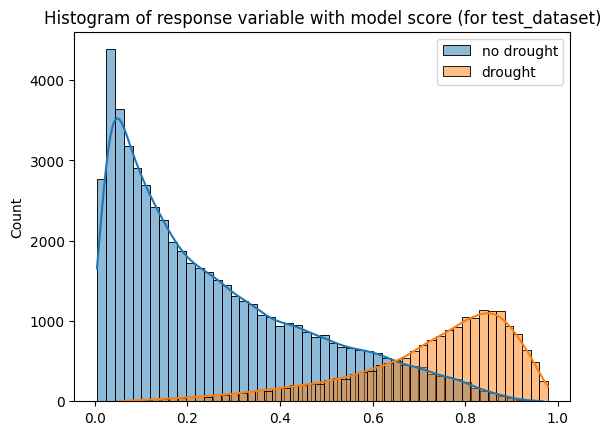

In [24]:
plt.title('Histogram of response variable with model score (for test_dataset)')
sns.histplot(pred_test[y_test==0], bins=50, stat='count', kde=True, label='no drought')
sns.histplot(pred_test[y_test==1], bins=50, stat='count', kde=True, label='drought')
plt.legend()

<Axes: title={'center': 'Histogram of response variable with model score (for oot_dataset)'}, ylabel='Count'>

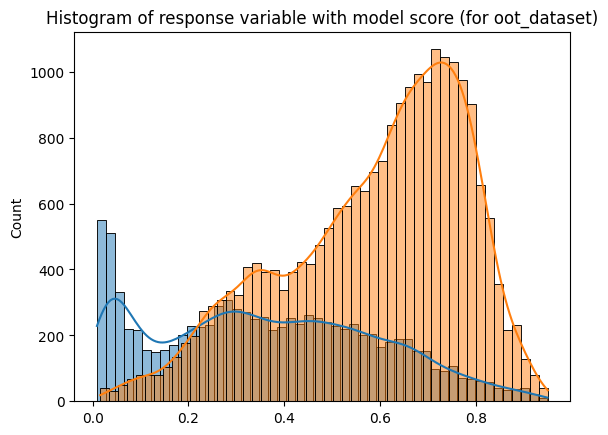

In [25]:
plt.title('Histogram of response variable with model score (for oot_dataset)')
sns.histplot(pred_oot[y_oot==0], bins=50, kde=True, stat='count', label='no drought')
sns.histplot(pred_oot[y_oot==1], bins=50, kde=True, stat='count', label='drought')

In [33]:
municipal_information

,geometry,representative_coordinate,nombre_municipio,entidad_federativa,org_cuenca,clv_oc,con_cuenca,cve_conc
mun_id,,,,,,,,
01_008,"POLYGON ((2463679.819 1122454.043, 2463636.551...",POINT (-102.53016 22.14257),San José de Gracia,Aguascalientes,Lerma-Santiago-Pacífico,VIII,Rio Santiago,16
01_009,"POLYGON ((2483386.269 1147520.506, 2483452.327...",POINT (-102.19271 22.24361),Tepezalá,Aguascalientes,Lerma-Santiago-Pacífico,VIII,Rio Santiago,16
01_010,"POLYGON ((2510504.977 1104537.995, 2511266.668...",POINT (-102.00073 21.92874),El Llano,Aguascalientes,Lerma-Santiago-Pacífico,VIII,Rio Santiago,16
01_011,"POLYGON ((2485534.556 1117425.794, 2485536.613...",POINT (-102.25178 22.02192),San Francisco de los Romo,Aguascalientes,Lerma-Santiago-Pacífico,VIII,Rio Santiago,16
01_001,"POLYGON ((2489959.178 1111683.059, 2489874.765...",POINT (-102.30547 21.84777),Aguascalientes,Aguascalientes,Lerma-Santiago-Pacífico,VIII,Rio Santiago,16
...,...,...,...,...,...,...,...,...
32_014,"POLYGON ((2410098.027 1380469.811, 2410689.823...",POINT (-102.76093 24.12900),General Francisco R. Murguía,Zacatecas,Cuencas Centrales Del Norte,VII,Nazas-Aguanaval,13
32_043,"POLYGON ((2386521.517 1172577.752, 2386366.855...",POINT (-103.19284 22.62991),Susticacán,Zacatecas,Lerma-Santiago-Pacífico,VIII,Rio Santiago,16
32_045,"POLYGON ((2380644.199 1069179.271, 2380573.883...",POINT (-103.36460 21.61454),Tepechitlán,Zacatecas,Lerma-Santiago-Pacífico,VIII,Rio Santiago,16


In [60]:
f_info_oot = f.loc[y_oot.index]
f_info_oot['future_date'] = f_info_oot.standard_date + pd.DateOffset(months=6)
f_info_oot['num_drought_index_future'] = y_oot
f_info_oot['num_drought_index_pred'] = pred_oot
f_info_oot['num_drought_index_future_numbers'] = target['num_drought_index_future']

In [148]:
last_info = f_info_oot[f_info_oot.future_date==pd.to_datetime('2024-06-15')]
last_info.set_index('mun_id', inplace=True)
last_info['geometry'] = municipal_information['geometry']
last_info['nombre_municipio'] = municipal_information['nombre_municipio']
last_info['entidad_federativa'] = municipal_information['entidad_federativa']
last_info['proyection'] = (last_info['num_drought_index_pred'] > 0.40).astype('int')
last_info = gpd.GeoDataFrame(last_info)

<Axes: >

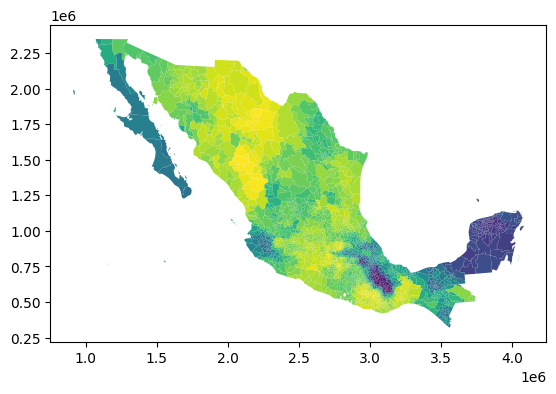

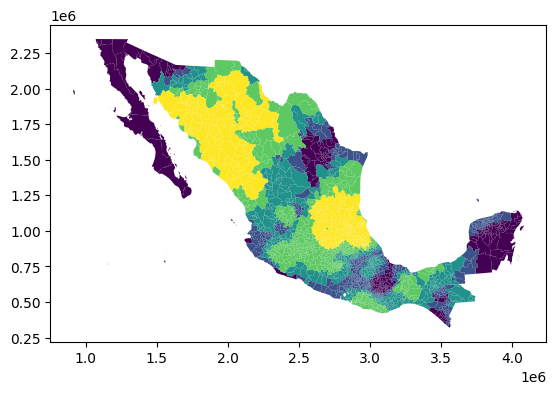

In [150]:
last_info.plot(column='num_drought_index_pred')
last_info.plot(column='num_drought_index_future_numbers')

## Conclusions

In [22]:
model_path_file = join_paths(general_path, MODEL_PATH, MODEL_FILE)
save_as_pickle(what=model, where=model_path_file)